In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import pandas as pd
from datetime import timedelta as td
import ruptures as rpt
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.log.importer.xes import importer as xes_importer
from datetime import date
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import seaborn as sns
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
import pm4py
import random

import datetime
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn import tree,metrics
from imblearn.over_sampling import RandomOverSampler,ADASYN,SMOTE

weighingtimedict={}

C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Inputs

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

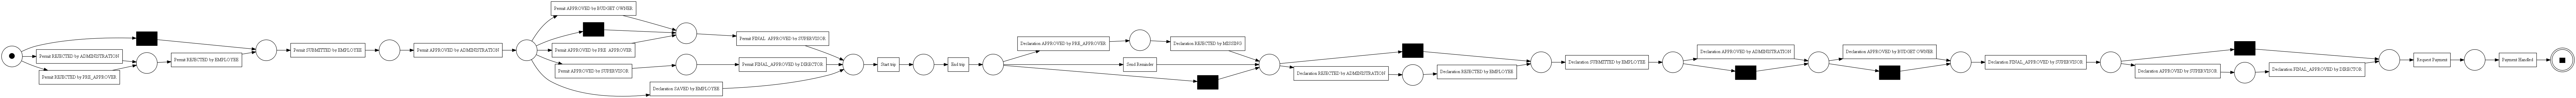

In [4]:

log = xes_importer.apply('../data/BPI2020IRFit.xes')

net, initial_marking, final_marking = pnml_importer.apply("../data/petrinetbpi2020IR.pnml")    

gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [5]:
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)
net

replaying log with TBR, completed variants ::   0%|          | 0/123 [00:00<?, ?it/s]

places: [ n1, n10, n11, n12, n13, n14, n15, n16, n17, n18, n19, n2, n20, n21, n22, n3, n4, n5, n6, n7, n8, n9 ]
transitions: [ (n23, None), (n24, 'Permit REJECTED by PRE_APPROVER'), (n25, 'Permit REJECTED by ADMINISTRATION'), (n26, 'Permit REJECTED by EMPLOYEE'), (n27, 'Permit SUBMITTED by EMPLOYEE'), (n28, 'Permit APPROVED by ADMINISTRATION'), (n29, 'Permit APPROVED by SUPERVISOR'), (n30, 'Permit FINAL_APPROVED by DIRECTOR'), (n31, None), (n32, 'Permit APPROVED by PRE_APPROVER'), (n33, 'Permit APPROVED by BUDGET OWNER'), (n34, 'Permit FINAL_APPROVED by SUPERVISOR'), (n35, 'Declaration SAVED by EMPLOYEE'), (n36, 'Start trip'), (n37, 'End trip'), (n38, None), (n39, 'Declaration APPROVED by PRE_APPROVER'), (n40, 'Declaration REJECTED by MISSING'), (n41, 'Send Reminder'), (n42, None), (n43, 'Declaration REJECTED by ADMINISTRATION'), (n44, 'Declaration REJECTED by EMPLOYEE'), (n45, 'Declaration SUBMITTED by EMPLOYEE'), (n46, None), (n47, 'Declaration APPROVED by ADMINISTRATION'), (n48, Non

# Generic Methods

In [6]:
##usage= get_labels_set(input_transition_set)
def get_labels_set(input_transition_set):
    label_set=set()
    for transition in input_transition_set:
        label_set.add(transition._Transition__get_label())
    return label_set

##usage= get_input_transitions('n4')
def get_initial_start(intial_place):
    for place in net.places:
        if place._Place__get_name()==intial_place:
            initial_start=place
    return initial_start

##usage= get_input_transitions(net,initial_start)
def get_input_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_target()==place:
                if arc._Arc__get_source()._Transition__get_label() is None:
                    transition.append(arc._Arc__get_source())
                    for new_place in arc._Arc__get_source()._Transition__get_in_arcs():
                        transition.extend(get_input_transitions(net,new_place._Arc__get_source()))
                else:
                    transition.append(arc._Arc__get_source())
        return transition
    else:
        return None
    
##usage= get_output_transitions(net,initial_start)
def get_output_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_source()==place:
                transition.append(arc._Arc__get_target())
        return transition
    else:
        return None
    
def filter_none(input_transition_set):
    transition_set=set()
    for transition in input_transition_set:
        if transition._Transition__get_label() is not None:
            transition_set.add(transition)
    return transition_set

In [8]:
def listweightingtime(log, event):
    if event in weighingtimedict:
        return weighingtimedict[event]
    waitingtime=[]
    for case in log:
        time=None
        lasttime=None
        for events in case:
            if events['concept:name']==event:
                time=events['time:timestamp']
                break
            else :
                lasttime=events['time:timestamp']
        if time is not None and lasttime is not None:
            waitingtime.append(pd.to_datetime(time, utc=True)-pd.to_datetime(lasttime, utc=True))
    weighingtimedict[event]=waitingtime
    return waitingtime

def fit(net,aligned_traces,log):
    iter=0
    index=1
    for trace,login in zip(aligned_traces,log):
        try:
            iter=0
            index=index+1
            if trace['fitness']<1:
                for item in trace['alignment']:
                #move on model- adding an activity
                    if (item[0]!=item[1]) and item[0]=='>>' and item[1] is not None:
                        print('adding:',item[1])
                        newitem=lastitem.__copy__()
                        print(len(login))
                        if len(login)<iter:
                            nextitemtime=login.__getitem__(iter).__getitem__('time:timestamp')
                        else :
                            nextitemtime=0
                        newitem.__setitem__('concept:name',item[1])
                        time=lastitem.__getitem__('time:timestamp')
                        weightingtime=random.choices(listweightingtime(log,item[1]))[0]
                        print(weightingtime)
                        if nextitemtime==0 or nextitemtime-time>weightingtime:
                            newitem.__setitem__('time:timestamp',time+weightingtime)
                        else :
                            print("here:",(nextitemtime-time)/2)
                            newitem.__setitem__('time:timestamp',time+(nextitemtime-time)/2)
                        login.insert(iter,newitem)
                        iter=iter+1
                    #move on log- deleting an activity
                    elif (item[0]!=item[1]) and item[1]=='>>' and item[0] is not None:
                        print('deleting',item[0],"-",iter)
                        login.__getitem__(iter).__setitem__('concept:name','readytodelete')
                        #login.__setitem__(iter,None)
                        #print(login)
                    if item[0]!='>>' and item[0]!='readytodelete' and item[0] is not None:
                        lastitem=login.__getitem__(iter)
                        iter=iter+1
        except:
            print("error")
    log = pm4py.filter_event_attribute_values(log, "concept:name", ["readytodelete"], level="event", retain=False)
    return log

# Log Fitness

In [9]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
aligned_traces = pm4py.conformance_diagnostics_alignments(log, net, initial_marking, final_marking)
print(replay_fitness.evaluate(aligned_traces, variant=replay_fitness.Variants.ALIGNMENT_BASED))
newlog=fit(net,aligned_traces,log)

aligning log, completed variants ::   0%|          | 0/123 [00:00<?, ?it/s]

{'percFitTraces': 99.95348115986975, 'averageFitness': 0.9998631798819698, 'percentage_of_fitting_traces': 99.95348115986975, 'average_trace_fitness': 0.9998631798819698, 'log_fitness': 0.9998592282091575}


In [13]:
newlog=pm4py.filter_event_attribute_values(log, "concept:name", ["readytodelete"], level="event", retain=False)

In [24]:
def createZone(replayed_traces,log,placeSet):
    input_transition_set=set()
    input_transition_label_set=set()
    output_transition_set=set()
    output_transition_label_set=set()
    all_transition_set=set()
    all_transition_label_set=set()
    for start in placeSet:
        print(start)
        initial_start=get_initial_start(start)
        input_transition_set|=set(get_input_transitions(net,initial_start))
        output_transition_set|=set(get_output_transitions(net,initial_start))
    
    all_transition_set|=input_transition_set
    all_transition_set|=output_transition_set
    temp=input_transition_set.difference(output_transition_set)
    output_transition_set.difference_update(input_transition_set)
    input_transition_set=temp

    input_transition_set=filter_none(input_transition_set)
    all_transition_set.difference_update(input_transition_set)
    all_transition_set=filter_none(all_transition_set)
    
    input_transition_label_set|=get_labels_set(input_transition_set)    
    output_transition_label_set|=get_labels_set(output_transition_set)
    all_transition_label_set|=get_labels_set(all_transition_set)
    
    print(all_transition_set)
    print(all_transition_label_set)
    print(input_transition_set)
    print(input_transition_label_set)
    print(output_transition_set)
    print(output_transition_label_set)

    token_produced=0
    token_consumed=0
    token_left=0
    dataframe=pd.DataFrame(columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
    for trace,case in zip(replayed_traces, log):
        last_event=None
        first_event=None
        goodstart=False
        if trace['trace_is_fit']==True or True:
            backupstart=None
            backup_event=None
            for active_trace in trace['activated_transitions']:
                if active_trace in input_transition_set :
                    goodstart=True
                    for events in case:
                        if events['concept:name'] in input_transition_label_set:
                            last_event=events
                            backup_event=events
                if active_trace in output_transition_set:
                    for events in case:
                        if events['concept:name'] in output_transition_label_set:
                            first_event=events
                if active_trace in all_transition_set :
                    for events in case:
                        if events['concept:name'] in all_transition_label_set:
                            backup_event=events
                            if goodstart==False and backupstart is None:
                                backupstart=events
                            
            if first_event is None and backup_event is not None:
                first_event=backup_event
            if last_event is None and backupstart is not None:
                last_event=backupstart
            if last_event is not None and first_event  is not None :
                token_produced=token_produced+1
                token_consumed=token_consumed+1
                row_df = pd.DataFrame([[last_event['concept:name'], last_event['time:timestamp'],first_event['concept:name'], first_event['time:timestamp'], case.attributes['concept:name']]],columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
                dataframe = pd.concat([row_df, dataframe], ignore_index=True)
    
    print(token_produced)
    print(token_consumed)
    return dataframe

# Create Zones

In [25]:
CreatePermitZone=createZone(replayed_traces,log ,['n3','n4','n5','n6','n8','n9','n7'])
TravelZone=createZone(replayed_traces,log ,['n10'])
DeclarationZone=createZone(replayed_traces,log ,['n11','n12','n13','n15','n14','n16','n17','n18','n19','n20','n21'])
PaymentZone=createZone(replayed_traces,log ,['n22'])

n3
n4
n5
n6
n8
n9
n7
{(n36, 'Start trip'), (n26, 'Permit REJECTED by EMPLOYEE'), (n27, 'Permit SUBMITTED by EMPLOYEE'), (n28, 'Permit APPROVED by ADMINISTRATION'), (n30, 'Permit FINAL_APPROVED by DIRECTOR'), (n29, 'Permit APPROVED by SUPERVISOR'), (n32, 'Permit APPROVED by PRE_APPROVER'), (n34, 'Permit FINAL_APPROVED by SUPERVISOR'), (n33, 'Permit APPROVED by BUDGET OWNER'), (n35, 'Declaration SAVED by EMPLOYEE')}
{'Start trip', 'Permit APPROVED by PRE_APPROVER', 'Permit APPROVED by SUPERVISOR', 'Permit FINAL_APPROVED by SUPERVISOR', 'Declaration SAVED by EMPLOYEE', 'Permit FINAL_APPROVED by DIRECTOR', 'Permit APPROVED by BUDGET OWNER', 'Permit APPROVED by ADMINISTRATION', 'Permit SUBMITTED by EMPLOYEE', 'Permit REJECTED by EMPLOYEE'}
{(n24, 'Permit REJECTED by PRE_APPROVER'), (n25, 'Permit REJECTED by ADMINISTRATION')}
{'Permit REJECTED by PRE_APPROVER', 'Permit REJECTED by ADMINISTRATION'}
{(n36, 'Start trip')}
{'Start trip'}
6449
6449
n10
{(n37, 'End trip')}
{'End trip'}
{(n36, 'Sta

In [26]:
def globaldata(Zone):
    Zone['StartDateTime'] = pd.to_datetime(Zone['StartTime'], utc=True)
    Zone['StartDate'] = pd.to_datetime(Zone['StartDateTime']).dt.date
    Zone['EndDateTime'] = pd.to_datetime(Zone['EndTime'], utc=True)
    Zone['EndDate'] = pd.to_datetime(Zone['EndDateTime']).dt.date
    Zone['TotalWaitingTime']=  (pd.to_datetime(Zone['EndTime'], utc=True)-pd.to_datetime(Zone['StartTime'], utc=True))

    global minstartdate
    global maxenddate
    if minstartdate is None:
        minstartdate=min(Zone['StartDate'])
    else :
        minstartdate=min(minstartdate,min(Zone['StartDate']))
    if maxenddate is None:
        maxenddate=max(Zone['EndDate'])
    else :
        maxenddate=max(maxenddate,max(Zone['EndDate']))


In [27]:
def DataPreparation(Zone,timeFrame):
    global minstartdate
    global maxenddate
    print(minstartdate)
    print(maxenddate)
    return pd.DataFrame({'date':pd.date_range(start=minstartdate, end=maxenddate, freq=timeFrame),
                                       'tokenproduced':0,'tokenconsumed':0,'tokenleft':0,'oneframetoken':0,
                                       'TimeSpent':0,'Count':0})

def getZoneData(Zone,timeFrame):
    ZoneDataFrame=DataPreparation(Zone,timeFrame)
    if timeFrame=='H':
        timeformat='%Y-%m-%d %H'
    if timeFrame=='D':
        timeformat='%Y-%m-%d'
    if timeFrame=='W':
        timeformat='%Y-%m-%W'
    if timeFrame=='M':
        timeformat='%Y-%m'
    for index, row in ZoneDataFrame.iterrows():
        currentdate=row['date'].strftime(timeformat)
        print(currentdate)
        currentDateValue=row['date']
        produced=0
        left=0
        consumed=0
        oneFrame=0
        waiting=td(days=0)
        waitingdays=0
        #print(type(waiting))
        count=0
        itemlist=[]
        #if currentdate.strftime('%Y-%m-%d')<='1999-10-13':
        #    continue
        #print(currentdate)
        for indexdata, rowdata in Zone.iterrows():
            oneFramecheck=False
            StartDate=rowdata['StartTime'].strftime(timeformat)
            EndDate=rowdata['EndTime'].strftime(timeformat)
            #print(StartDate)
            #TotalWaitingTime=rowdata['TotalWaitingTime']
            TotalWaitingTime=rowdata['TotalWaitingTime']
            if timeFrame=='H':
                WaitingTimeTillDate=currentDateValue+td(hours=1)
            if timeFrame=='D':
                WaitingTimeTillDate=currentDateValue+td(hours=24)
            if timeFrame=='W':
                WaitingTimeTillDate=currentDateValue+td(weeks=1)
            if timeFrame=='M':
                WaitingTimeTillDate=currentDateValue+td(weeks=4)

            if currentdate==StartDate and currentdate==EndDate:
                oneFrame=oneFrame+1
                oneFramecheck=True
            if currentdate==StartDate:
                produced=produced+1
            if currentdate==EndDate:
                consumed=consumed+1
                WaitingTimeTillDate=rowdata['EndDateTime']
                itemlist.append(StartDate)
            if currentdate<EndDate and currentdate>=StartDate:
                #print(StartDate+" "+currentdate+" "+EndDate)
                left=left+1
            if currentdate<=EndDate and currentdate>=StartDate:
                TotalWaitingTime=WaitingTimeTillDate.replace(tzinfo=None)-rowdata['StartDateTime'].replace(tzinfo=None)
                if waiting is None:
                    waiting=TotalWaitingTime
                else:
                    if waiting.days<100000:
                        waiting=waiting+TotalWaitingTime
                        waitingdays=waiting.days
                    else :
                        waitingdays=TotalWaitingTime.days+waitingdays
                count=count+1
        ZoneDataFrame.at[index, 'tokenproduced']=produced
        ZoneDataFrame.at[index, 'tokenconsumed']=consumed
        ZoneDataFrame.at[index, 'oneframetoken']=oneFrame
        ZoneDataFrame.at[index, 'tokenleft']=left
        if waiting.days<100000:
            ZoneDataFrame.at[index, 'TimeSpent']=waiting
        else:
            ZoneDataFrame.at[index, 'TimeSpent']=waitingdays
        ZoneDataFrame.at[index, 'Count']=count
    return ZoneDataFrame.copy()



In [28]:
minstartdate=None
maxenddate=None
timeFrame='M'
timeFrame='W'
for zone in [CreatePermitZone,TravelZone,DeclarationZone,PaymentZone]:
    globaldata(zone)
print(minstartdate)
print(maxenddate)
if timeFrame=='H':
    maxenddate=maxenddate+td(days=1)
if timeFrame=='D':
    maxenddate=maxenddate+td(days=1)
if timeFrame=='W':
    maxenddate=maxenddate+td(days=7)
if timeFrame=='M':
    maxenddate=maxenddate+td(days=31)


2016-10-04
2020-01-10


# create process log for each zone and save them for reuse

In [29]:
  
WeeklyCreatePermitZoneDF=getZoneData(CreatePermitZone,timeFrame)
WeeklyCreatePermitZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2020IRCreatePermitZoneDFWeeklyFit.csv', index = False, header=True)

WeeklyTravelZoneDF=getZoneData(TravelZone,timeFrame)
WeeklyTravelZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2020IRTravelZoneDFWeeklyFit.csv', index = False, header=True)

WeeklyDeclarationZoneDF=getZoneData(DeclarationZone,timeFrame)
WeeklyDeclarationZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2020IRDeclarationZoneDFWeeklyFit.csv', index = False, header=True)

WeeklyPaymentZoneDF=getZoneData(PaymentZone,timeFrame)
WeeklyPaymentZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2020PaymentZoneDWeeklyFit.csv', index = False, header=True)

#backupfirst=CreateLoanApplicationZoneDF.copy()
#IncompleteZoneDF=getZoneData(IncompleteZone,timeFrame)
#backupsecond=IncompleteZoneDF.copy()
#OfferZoneDF=getZoneData(OfferZone,timeFrame)
#backupthird=OfferZoneDF.copy()

2016-10-04
2020-01-17
2016-10-40
2016-10-41
2016-10-42
2016-10-43
2016-11-44
2016-11-45
2016-11-46
2016-11-47
2016-12-48
2016-12-49
2016-12-50
2016-12-51
2017-01-00
2017-01-01
2017-01-02
2017-01-03
2017-01-04
2017-02-05
2017-02-06
2017-02-07
2017-02-08
2017-03-09
2017-03-10
2017-03-11
2017-03-12
2017-04-13
2017-04-14
2017-04-15
2017-04-16
2017-04-17
2017-05-18
2017-05-19
2017-05-20
2017-05-21
2017-06-22
2017-06-23
2017-06-24
2017-06-25
2017-07-26
2017-07-27
2017-07-28
2017-07-29
2017-07-30
2017-08-31
2017-08-32
2017-08-33
2017-08-34
2017-09-35
2017-09-36
2017-09-37
2017-09-38
2017-10-39
2017-10-40
2017-10-41
2017-10-42
2017-10-43
2017-11-44
2017-11-45
2017-11-46
2017-11-47
2017-12-48
2017-12-49
2017-12-50
2017-12-51
2017-12-52
2018-01-01
2018-01-02
2018-01-03
2018-01-04
2018-02-05
2018-02-06
2018-02-07
2018-02-08
2018-03-09
2018-03-10
2018-03-11
2018-03-12
2018-04-13
2018-04-14
2018-04-15
2018-04-16
2018-04-17
2018-05-18
2018-05-19
2018-05-20
2018-05-21
2018-06-22
2018-06-23
2018-06-24

# Start from here in case process logs already exists

In [2]:
WeeklyCreatePermitZoneDF = pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2020IRCreatePermitZoneDFWeeklyFit.csv')
WeeklyTravelZoneDF= pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2020IRTravelZoneDFWeeklyFit.csv')
WeeklyDeclarationZoneDF=pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2020IRDeclarationZoneDFWeeklyFit.csv')
WeeklyPaymentZoneDF=pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2020PaymentZoneDWeeklyFit.csv')

WeeklyCreatePermitZoneDF['TimeSpent']=pd.to_timedelta(WeeklyCreatePermitZoneDF['TimeSpent'])
WeeklyTravelZoneDF['TimeSpent']=pd.to_timedelta(WeeklyTravelZoneDF['TimeSpent'])
WeeklyDeclarationZoneDF['TimeSpent']=pd.to_timedelta(WeeklyDeclarationZoneDF['TimeSpent'])
WeeklyPaymentZoneDF['TimeSpent']=pd.to_timedelta(WeeklyPaymentZoneDF['TimeSpent'])

WeeklyCreatePermitZoneDF['date']=pd.to_datetime(WeeklyCreatePermitZoneDF['date'])
WeeklyTravelZoneDF['date']=pd.to_datetime(WeeklyTravelZoneDF['date'])
WeeklyDeclarationZoneDF['date']=pd.to_datetime(WeeklyDeclarationZoneDF['date'])
WeeklyPaymentZoneDF['date']=pd.to_datetime(WeeklyPaymentZoneDF['date'])

# More generic methods for Processing and training

In [3]:
def process(Zone):
    def categorise(row):  
        if type( row['TimeSpent']) is int :
            return row['TimeSpent']
        return row['TimeSpent'].days
    Zone['DaysSpent'] = Zone.apply(lambda row: categorise(row), axis=1)

    def categorise(row):   
        if row['Count']==0:
            return 0
        return row['DaysSpent']/row['Count']
    Zone['AverageTimeSpent'] = Zone.apply(lambda row: categorise(row), axis=1)
    index=Zone.index.values
    try:
        Zone.insert(0, column='index',value = index+1)
    except:
        print("index already exists")

def AnalyzeZone(Zone,featurelist,penalty,target=False):
    global timeFrame
    global timeFrameValue
    #reduced=pca_reduction(Zone[featurelist],len(featurelist), normalize = True, normalize_function="max")
    Zone['drift'] = 0
    for feature in featurelist:
        
        algo_python = rpt.Pelt(model="rbf",min_size=1,jump=1).fit(Zone[[feature]])  # written in pure python
        result = algo_python.predict(penalty)
        Zone.loc[Zone['index'].isin(result),'drift']=1
        fig, ax_array = rpt.display(Zone[feature], result)
        
        fig.suptitle('Change in Behavior of token left in Payment Zone over '+ timeFrameValue, fontsize=12)
        plt.ylabel('Number of token left')
        plt.xlabel(timeFrameValue)
        
        Zone['chunkmean'] = 0
        Zone['chunkindex'] = 1
        Zone['chunkstd']=0
        start=0
        sns.set(rc={'figure.figsize':(11.7,3.27)})
        i=1
        for index in result:
            Zone['chunkmean'].iloc[start:index]=Zone[ [feature] ].iloc[start:index].mean(axis=0)[0]
            Zone['chunkstd'].iloc[start:index]=Zone[ [feature] ].iloc[start:index].std(axis=0)[0]
            Zone['chunkindex'].iloc[start:index]=i
            i=i+1
            start=index
        Zone['pthreshold'] = Zone['chunkmean']+1*(Zone['chunkstd'])
        Zone['nthreshold'] = Zone['chunkmean']-1*(Zone['chunkstd'])
        
        if target==True:
            Zone['Strange_'+feature]=0
            def categorise(row,feature):
                if row['pthreshold'] < row[feature] or row['nthreshold']>row[feature] :
                    return 1
                return 0
            Zone['Strange_'+feature] = Zone.apply(lambda row: categorise(row,feature), axis=1)
        
        f, ax = plt.subplots()
        result=result[:-1]
        print(Zone.name,feature,result)
        
        plt.vlines(result,min(Zone[feature]),max(Zone[feature]) , linestyles ="dashed", colors ="gray",label='Changepoints')

        sns.lineplot(data=Zone, x='index', y=feature, color='b',label=feature).set(title=feature+', baseline and threshold over timeframe('+timeFrameValue+') superimposed with Changepoints')
        sns.lineplot(data=Zone, x='index', y='chunkmean',color='orange', label="Baseline")
        sns.lineplot(data=Zone, x='index', y='pthreshold',color='g',label="Threshold")
        sns.lineplot(data=Zone, x='index', y='nthreshold',color='g')
        plt.xlabel(timeFrameValue)
        plt.legend()
        
def max_lag(x,y):
    corr = np.correlate(x, y, mode='full')
    # find lag with highest correlation
    lag = np.argmax(corr) - len(x) + 1
    # create lagged variable
    lagged_y = y.shift(lag)
    # calculate correlation between x and lagged_y
    corr = x.corr(lagged_y)
    return lag,corr

sns.set(rc={'figure.figsize':(30.7,11.27)})
def traindtmultiple(x,y,columnlist,feature,i):
    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    ros = RandomOverSampler(random_state=0)
    
    try: 
        X_resampled, y_resampled = ros.fit_resample(x, y)
        x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3)
    except: 
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    
    
    clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=4,min_samples_leaf=15)
    clf = clf.fit(x_train, y_train)
    prediction=clf.predict(x_test)
    Y_test_pred = pd.DataFrame(prediction).applymap(lambda x: 1 if x>0.5 else 0)
    #Y_test_pred = pd.DataFrame(prediction)
    if accuracy_score(y_test, Y_test_pred)>0.8 and accuracy_score(y_test, Y_test_pred)<1 and f1_score(y_test, Y_test_pred, average="macro")>0.8:
        print('feature-',feature,':',' Day :',i)
        print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
        metrics.mean_squared_error(y_test, Y_test_pred)
        print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
        print("Accuracy:",accuracy_score(y_test, Y_test_pred))
        print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
        print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
        print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
        tree.plot_tree(clf,feature_names=columnlist,fontsize=16)
        cm = confusion_matrix(y_test, Y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()



def predict(targetZone,predictorZone,featurelist,predictionDelay):
    for feature in featurelist:
        combineddata=None
        for i in range(len(predictorZone)):
            if combineddata is None:
                combineddata=pd.merge(predictorZone[0],predictorZone[1],on=['date'],how='left',suffixes=("_"+predictorZone[0].name, "_"+predictorZone[1].name))
                combineddata['tokenproduced']=0
                combineddata['tokenconsumed']=0
                combineddata['tokenleft']=0
                combineddata['Count']=0
                combineddata['oneframetoken']=0
                combineddata['AverageTimeSpent']=0
            elif i>1:
                combineddata=combineddata.merge(predictorZone[i],on=['date'],how='left',suffixes=(None,"_"+predictorZone[i].name))
            
        def categorise(row,numdays):   
            return row['date'] -  datetime.timedelta(days=7)
        for j in range (predictionDelay):
            combineddata=combineddata.merge(targetZone[['date',feature]].rename({feature: feature+'_'+str(j)}, axis=1), on='date', how='left')
            targetZone['date'] = targetZone.apply(lambda row: categorise(row,j), axis=1)
        combineddata=combineddata.dropna()
        for j in range (predictionDelay):
            combineddata[feature+'_'+str(j)] = combineddata[feature+'_'+str(j)].astype(int)
        
        columnlist=[]
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('token')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('oneframetoken')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('AverageTimeSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('Count')].columns)
        x = combineddata[columnlist]
        columnlistnew = [s.replace('token', 'token ') for s in columnlist]
        columnlistnew = [s.replace('oneframetoken', 'one frame token') for s in columnlistnew]
        columnlistnew = [s.replace('AverageTimeSpent', 'Time Spent') for s in columnlistnew]
        
        for i in range(predictionDelay):
            
            y = combineddata[feature+'_'+str(i)].fillna(0).copy()
            x = combineddata[columnlist].copy()
            traindtmultiple(x,y,columnlistnew,feature,i)


# Task 1- Analysis of Zones

Permit Zone tokenproduced [14, 66, 92, 112]
Permit Zone tokenconsumed [17, 70, 115]
Permit Zone tokenleft [16, 68, 77, 90, 101, 107, 113]
Permit Zone oneframetoken [17, 66, 114]
Permit Zone Count [17, 68, 78, 90, 105, 114]
Permit Zone AverageTimeSpent [21, 115, 122, 129, 145]
Travel Zone tokenproduced [17, 70, 115]
Travel Zone tokenconsumed [14, 67, 116]
Travel Zone tokenleft [23, 73, 115]
Travel Zone oneframetoken [16, 70, 115]
Travel Zone Count [18, 72, 115]
Travel Zone AverageTimeSpent [25, 56, 66, 93, 115, 128, 139, 145]
Declaration Zone tokenproduced [14, 67, 116]
Declaration Zone tokenconsumed [16, 67, 76, 116]
Declaration Zone tokenleft [24, 70, 75, 86, 106, 115]
Declaration Zone oneframetoken [16, 67, 116]
Declaration Zone Count [26, 70, 79, 112, 116]
Declaration Zone AverageTimeSpent [42, 67, 118, 126, 145, 151]
Payment Zone tokenproduced [16, 67, 76, 116]
Payment Zone tokenconsumed [19, 68, 79, 119]
Payment Zone tokenleft [16, 67, 73, 118]
Payment Zone oneframetoken [19, 74, 

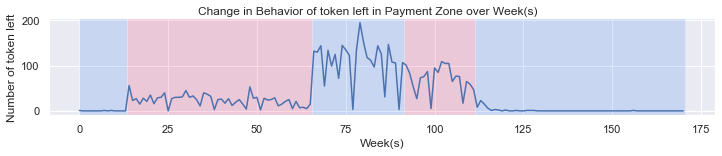

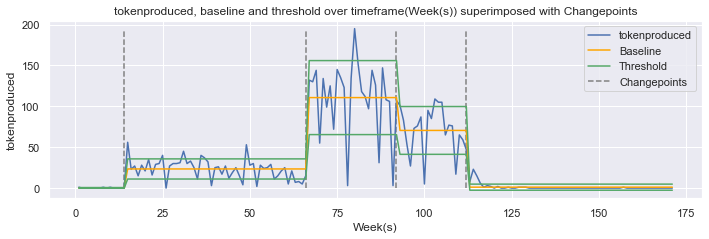

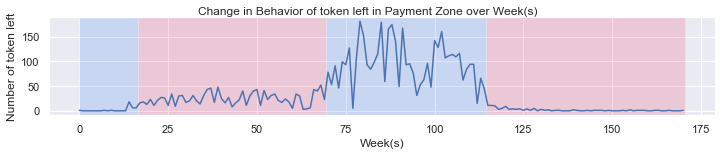

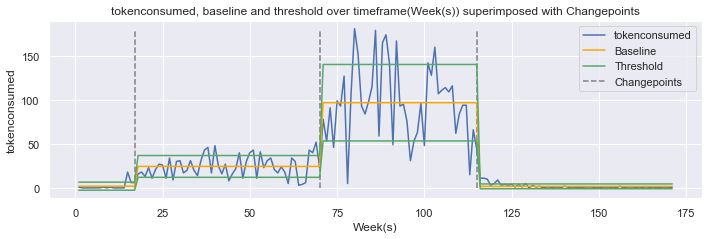

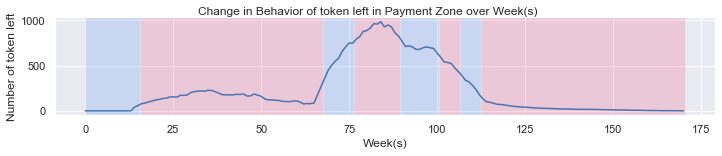

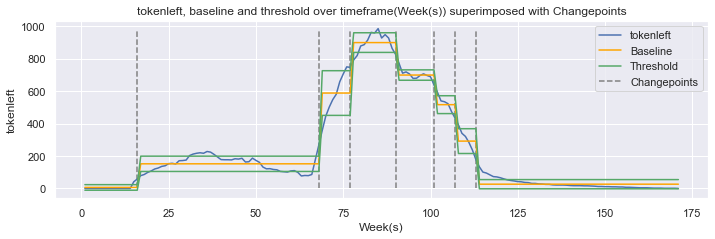

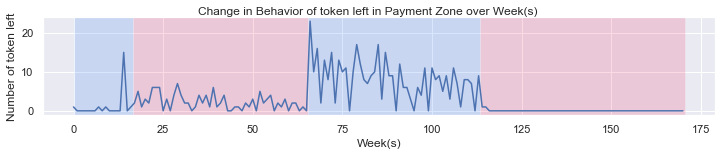

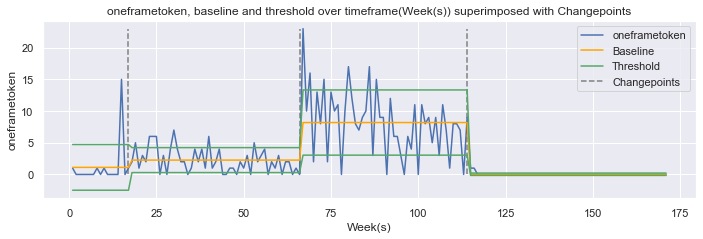

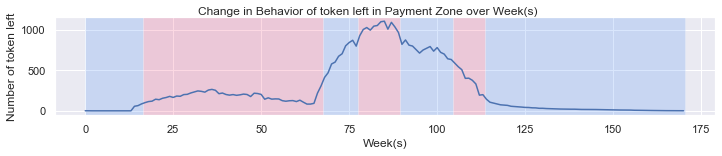

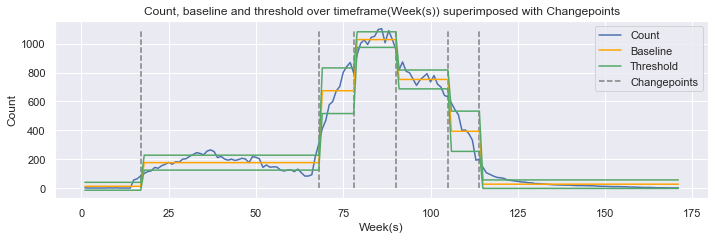

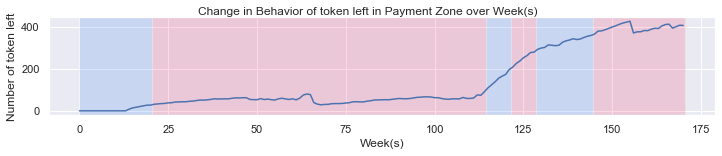

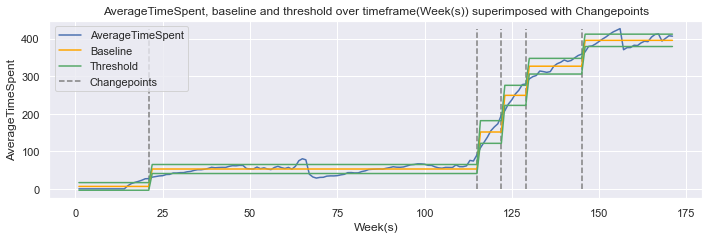

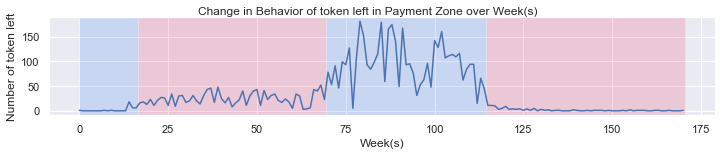

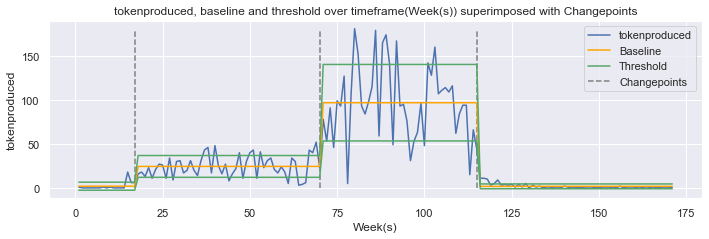

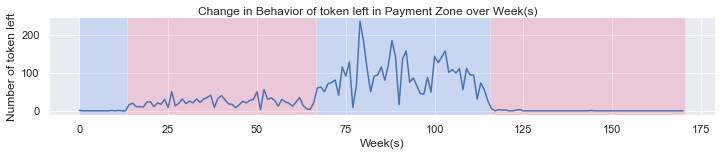

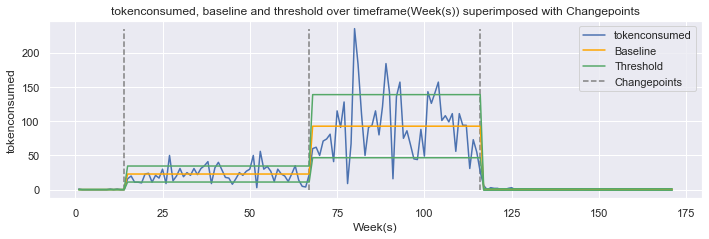

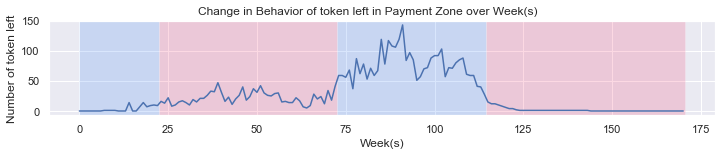

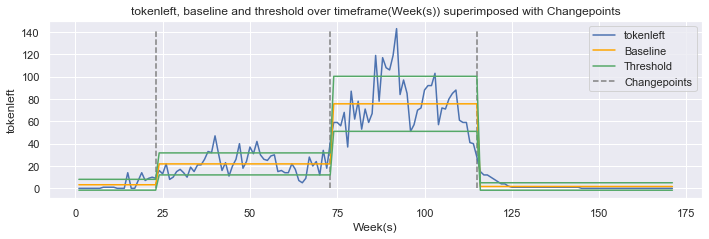

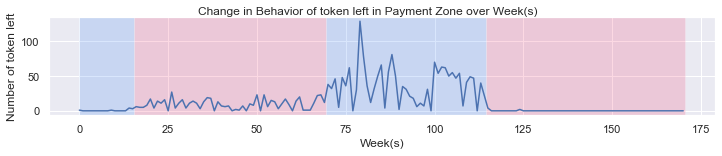

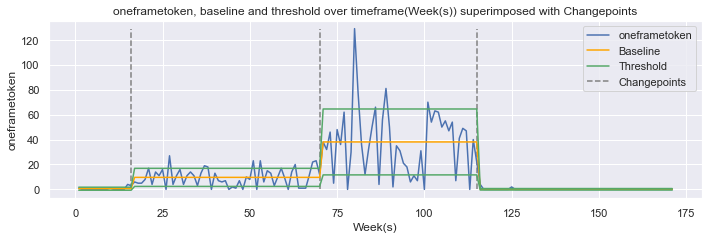

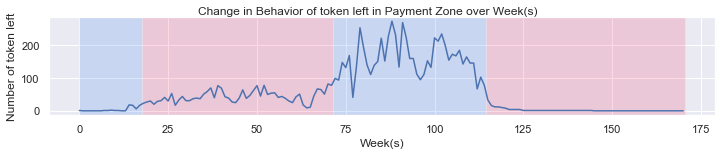

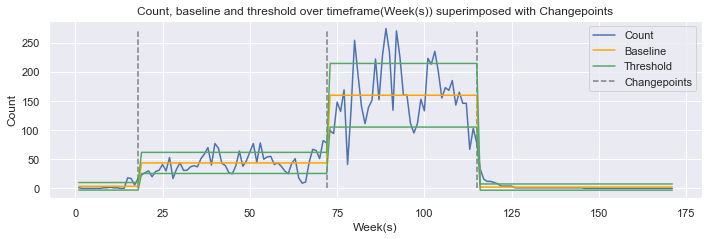

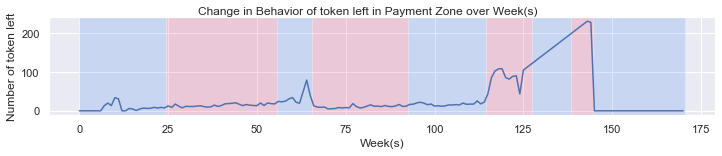

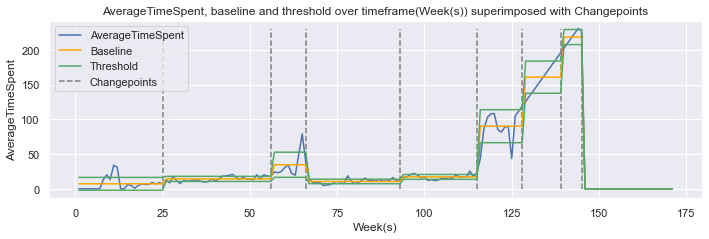

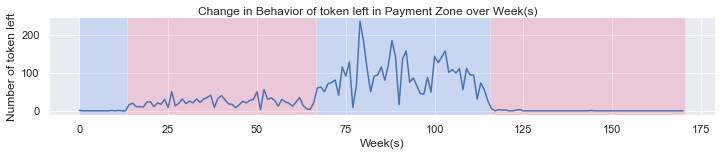

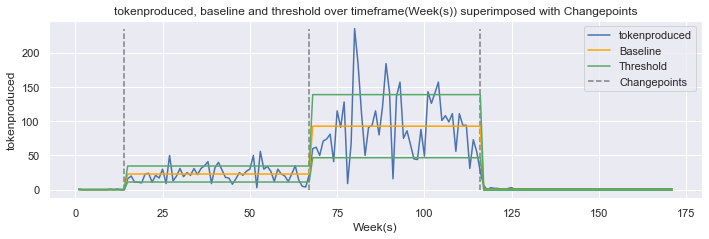

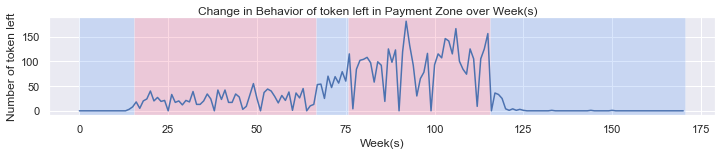

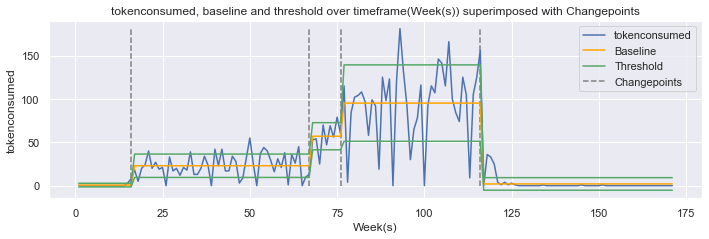

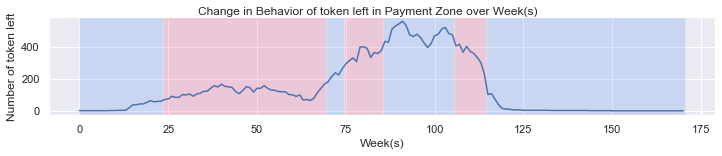

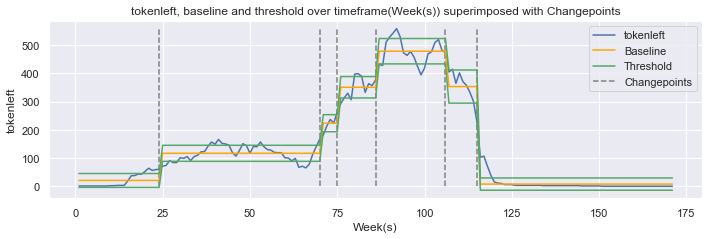

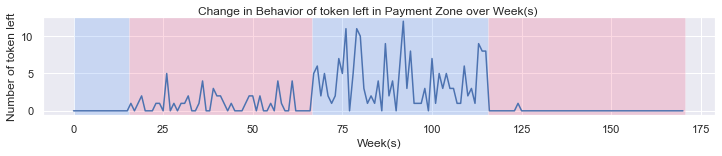

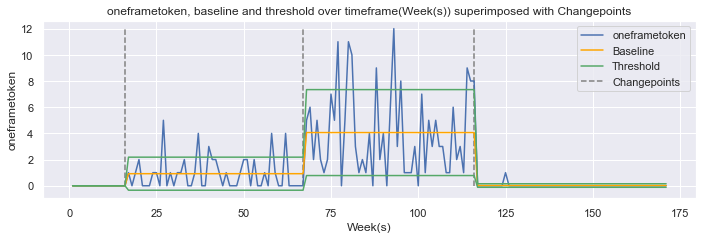

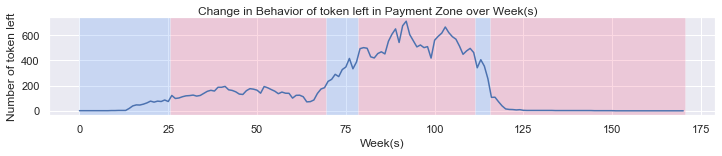

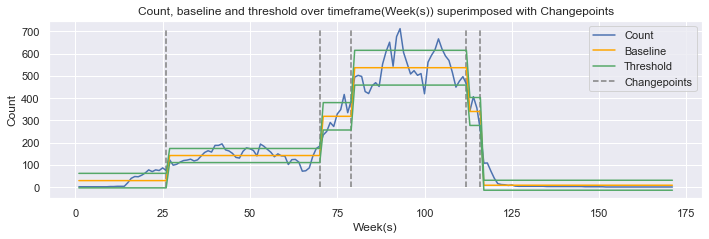

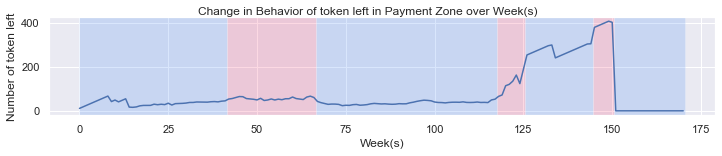

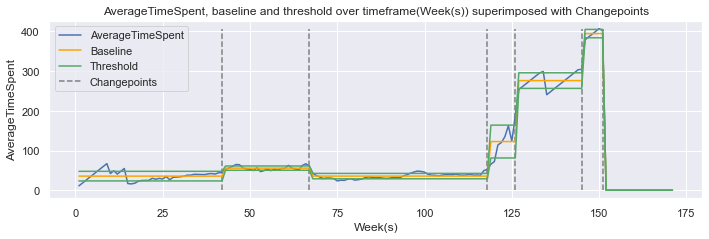

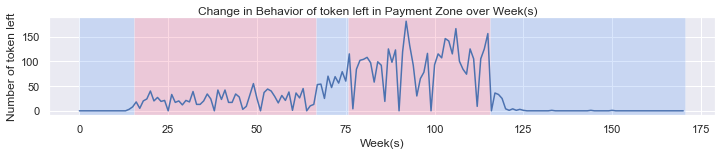

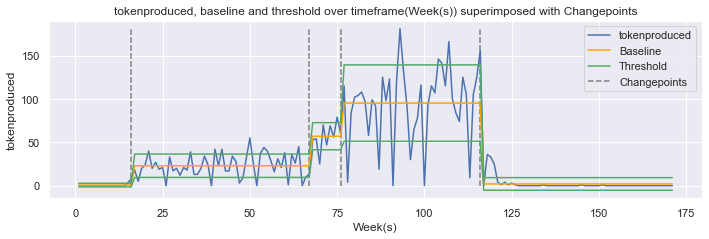

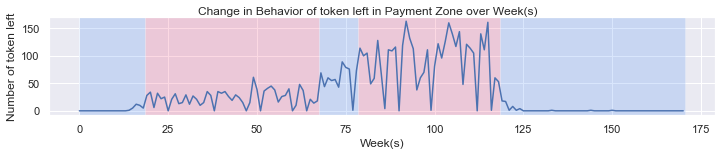

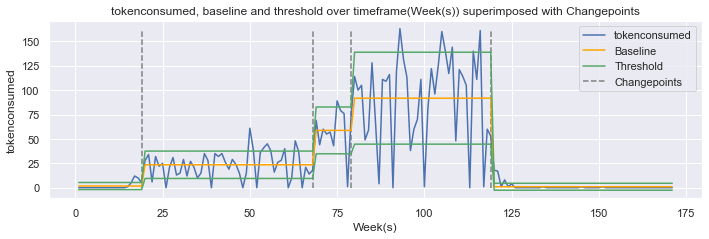

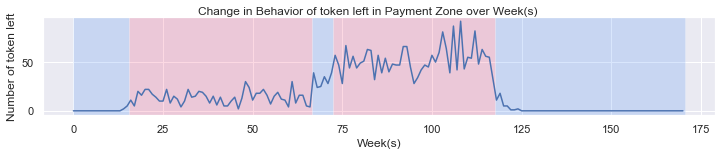

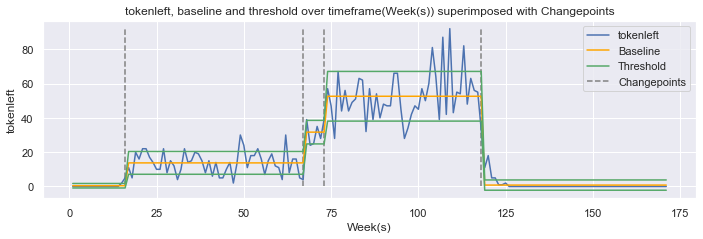

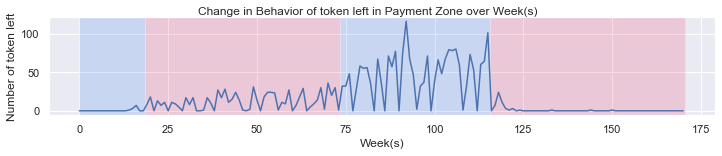

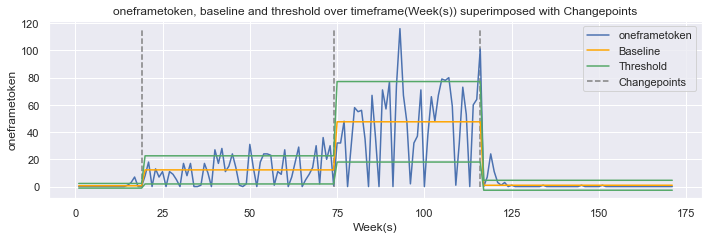

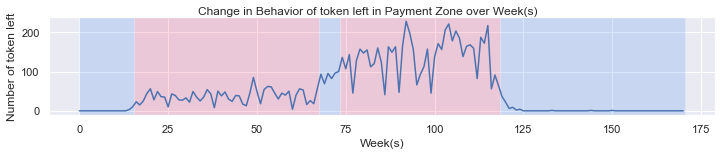

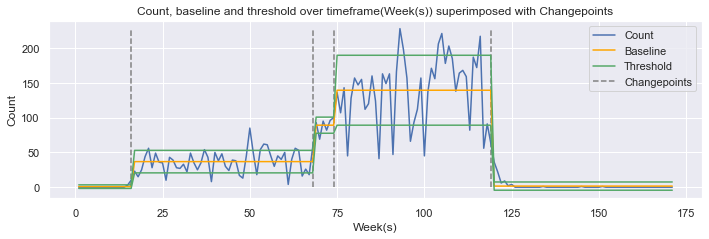

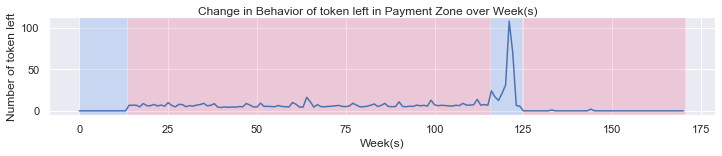

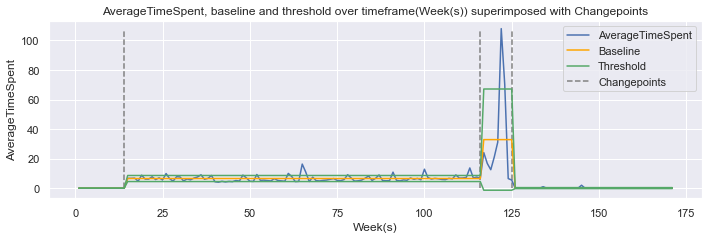

In [4]:
import warnings
warnings.filterwarnings('ignore')

timeFrame='W'
if timeFrame=='H':
    timeFrameValue='Hour(s)'
if timeFrame=='D':
    timeFrameValue='Day(s)'
if timeFrame=='W':
    timeFrameValue='Week(s)'
if timeFrame=='M':
    timeFrameValue='Month(s)'

WeeklyCreatePermitZoneDF.name = 'Permit Zone'
WeeklyTravelZoneDF.name = 'Travel Zone'
WeeklyDeclarationZoneDF.name = 'Declaration Zone'
WeeklyPaymentZoneDF.name = 'Payment Zone'

zonelist=[]  
featurelist=['tokenproduced', 'tokenconsumed', 'tokenleft','oneframetoken', 'Count', 'AverageTimeSpent']

targetzonelist=[WeeklyCreatePermitZoneDF,WeeklyTravelZoneDF,WeeklyDeclarationZoneDF,WeeklyPaymentZoneDF]

pen=3

for zone in  targetzonelist:
    process(zone)

for zone in targetzonelist:
    AnalyzeZone(zone,featurelist,pen,True)

zonelist=[]
for zone in targetzonelist:
    newzone=zone.iloc[:, :-6].copy()
    newzone.name=zone.name
    zonelist.append(newzone)  

# Task 2- Analysis of Interconnection

In [64]:

WeeklyCreatePermitZoneDF.name = 'Create Permit Zone'
WeeklyDeclarationZoneDF.name = 'Declaration Zone'
WeeklyTravelZoneDF.name = 'Travel Zone'
WeeklyPaymentZoneDF.name='Payment Zone'
targetZone=WeeklyDeclarationZoneDF.copy()
predictorZone=[WeeklyCreatePermitZoneDF.copy(),WeeklyTravelZoneDF.copy()]
zonelist=[WeeklyCreatePermitZoneDF,WeeklyDeclarationZoneDF,WeeklyTravelZoneDF,WeeklyPaymentZoneDF]
featurelist=['tokenproduced', 'tokenconsumed', 'tokenleft','oneframetoken', 'Count', 'AverageTimeSpent']

Corrdataframe=pd.DataFrame(columns= ['targetZone','targetFeature','sourceZone','sourceFeature','lag','MaxCorr'])     

for targetZone in zonelist:
    for targetFeature in featurelist:
        for zone in zonelist:
            lagsum=0
            for feature in featurelist:
                maxlag,maxcorr = max_lag(targetZone[targetFeature].dropna(),zone[feature].dropna())
                corrow_df = pd.DataFrame([[targetZone.name, targetFeature,zone.name, feature, maxlag,maxcorr]],columns=  ['targetZone','targetFeature','sourceZone','sourceFeature','lag','MaxCorr'])
                Corrdataframe = pd.concat([corrow_df, Corrdataframe], ignore_index=True)
Data=Corrdataframe[Corrdataframe['MaxCorr']>0.7].sort_values(by='MaxCorr', ascending=False)

In [82]:
Data[Data['lag']>1].sort_values(by=['lag'], ascending=False)

targetZone     targetFeature          sourceZone sourceFeature lag  \
165       Travel Zone  AverageTimeSpent  Create Permit Zone     tokenleft  81   
163       Travel Zone  AverageTimeSpent  Create Permit Zone         Count  80   
151       Travel Zone  AverageTimeSpent         Travel Zone         Count  74   
153       Travel Zone  AverageTimeSpent         Travel Zone     tokenleft  74   
157       Travel Zone  AverageTimeSpent    Declaration Zone         Count  73   
..                ...               ...                 ...           ...  ..   
129      Payment Zone     tokenproduced         Travel Zone     tokenleft   2   
79       Payment Zone         tokenleft         Travel Zone         Count   2   
57       Payment Zone     oneframetoken         Travel Zone     tokenleft   2   
111      Payment Zone     tokenconsumed    Declaration Zone     tokenleft   2   
321  Declaration Zone             Count         Travel Zone     tokenleft   2   

      MaxCorr  
165  0.792190  
163  0.792097  
151  0.779230  
153  0.871481  
157  0.904577  
..        ...  
129  0.847106  
79   0.846602  
57   0.764759  
111  0.832695  
321  0.973731  

[71 rows x 6 columns]

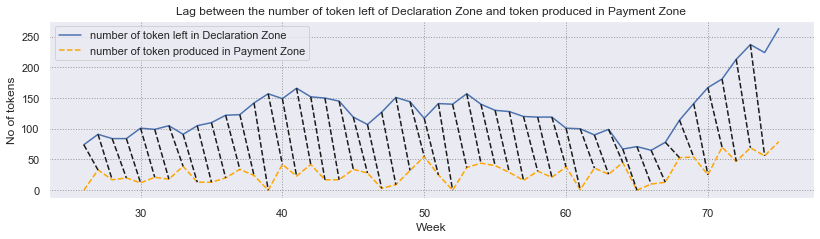

In [5]:

sns.set(rc={'figure.figsize':(13.7,3.27)})
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
gfg=sns.lineplot(data=WeeklyDeclarationZoneDF[25:75], x='index',markers=True, y='tokenleft', color='b',label='number of token left in Declaration Zone').set(title='Lag between the number of token left of Declaration Zone and token produced in Payment Zone')
gfg=sns.lineplot(data=WeeklyPaymentZoneDF[25:75], x='index',markers=True, y='tokenproduced',linestyle='--',color='orange', label="number of token produced in Payment Zone")
for i in range(25,73):
    gfg.plot([WeeklyDeclarationZoneDF['index'][i], WeeklyPaymentZoneDF["index"][i+1]],
             [WeeklyDeclarationZoneDF['tokenleft'][i], WeeklyPaymentZoneDF["tokenproduced"][i+1]],"k--")
#plt.axvline(x[np.argmax(y)], color='red')
plt.xlabel('Week')
plt.ylabel('No of tokens')
plt.show()

# Task 3- Prediction 

Declaration Zone
feature- Strange_tokenleft :  Day : 41
Mean absolute error LR- 0.1111111111111111
Mean Squared error LR- 0.3333333333333333
Accuracy: 0.8888888888888888
F1: 0.8875
Precision: 0.8875
Recall: 0.8875


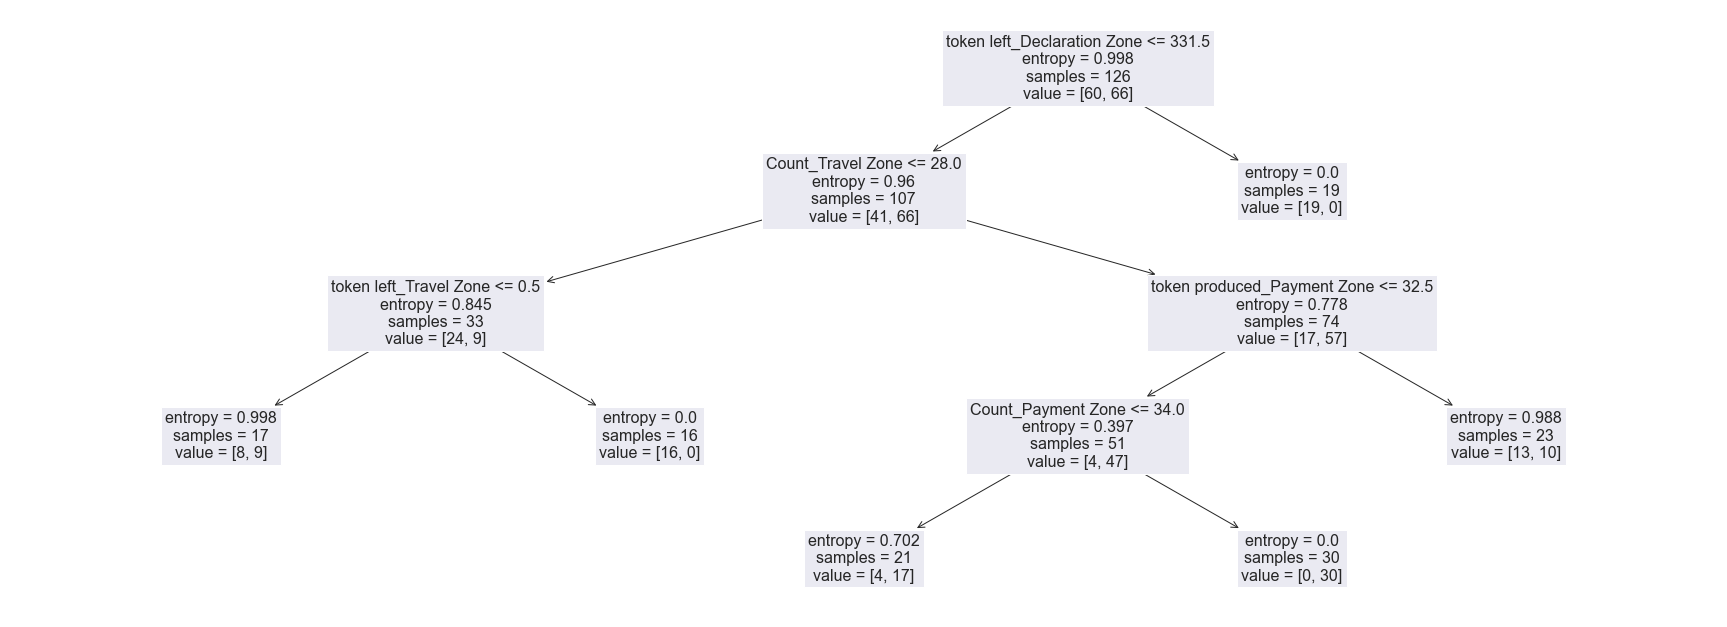

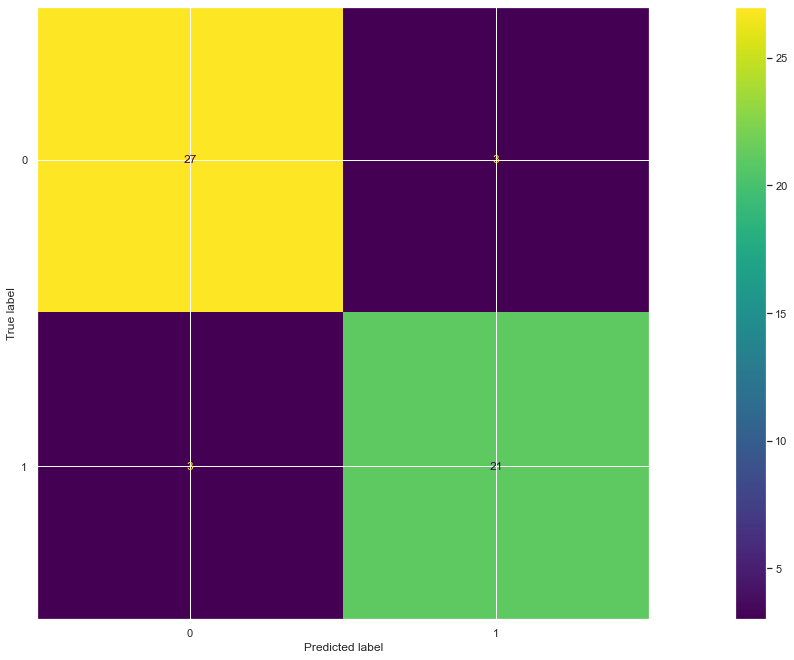

feature- Strange_tokenleft :  Day : 44
Mean absolute error LR- 0.17857142857142858
Mean Squared error LR- 0.4225771273642583
Accuracy: 0.8214285714285714
F1: 0.8177083333333334
Precision: 0.8154838709677419
Recall: 0.8221343873517787


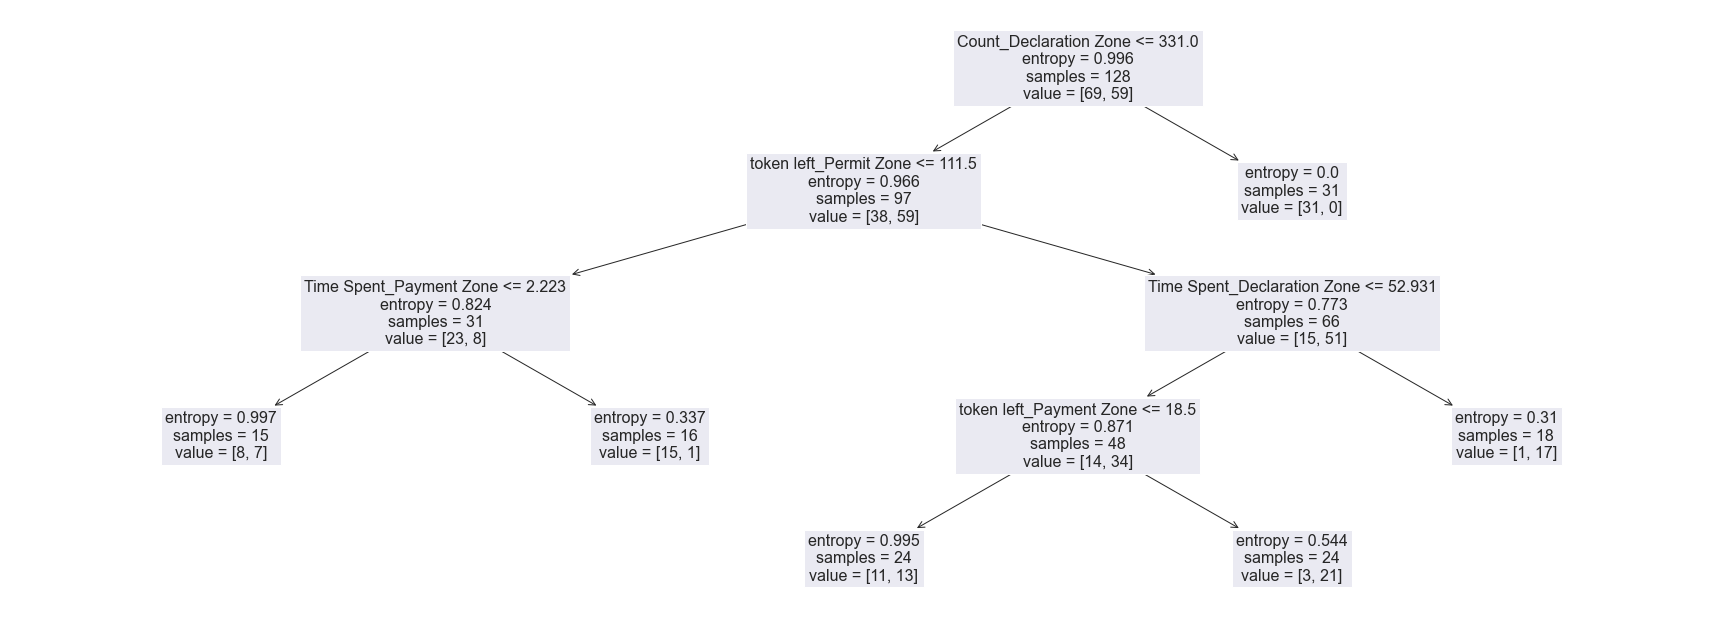

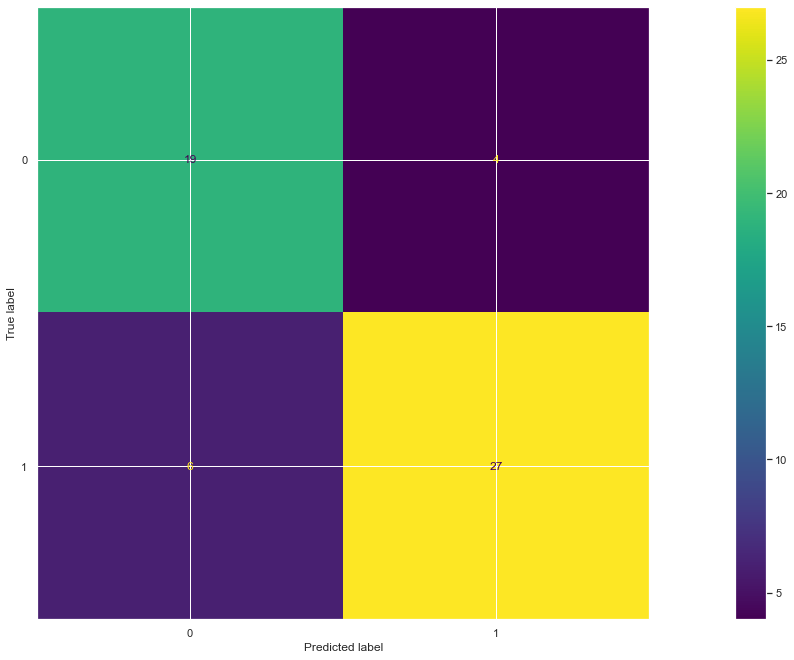

feature- Strange_tokenleft :  Day : 45
Mean absolute error LR- 0.17857142857142858
Mean Squared error LR- 0.4225771273642583
Accuracy: 0.8214285714285714
F1: 0.8205128205128205
Precision: 0.8214285714285714
Recall: 0.828125


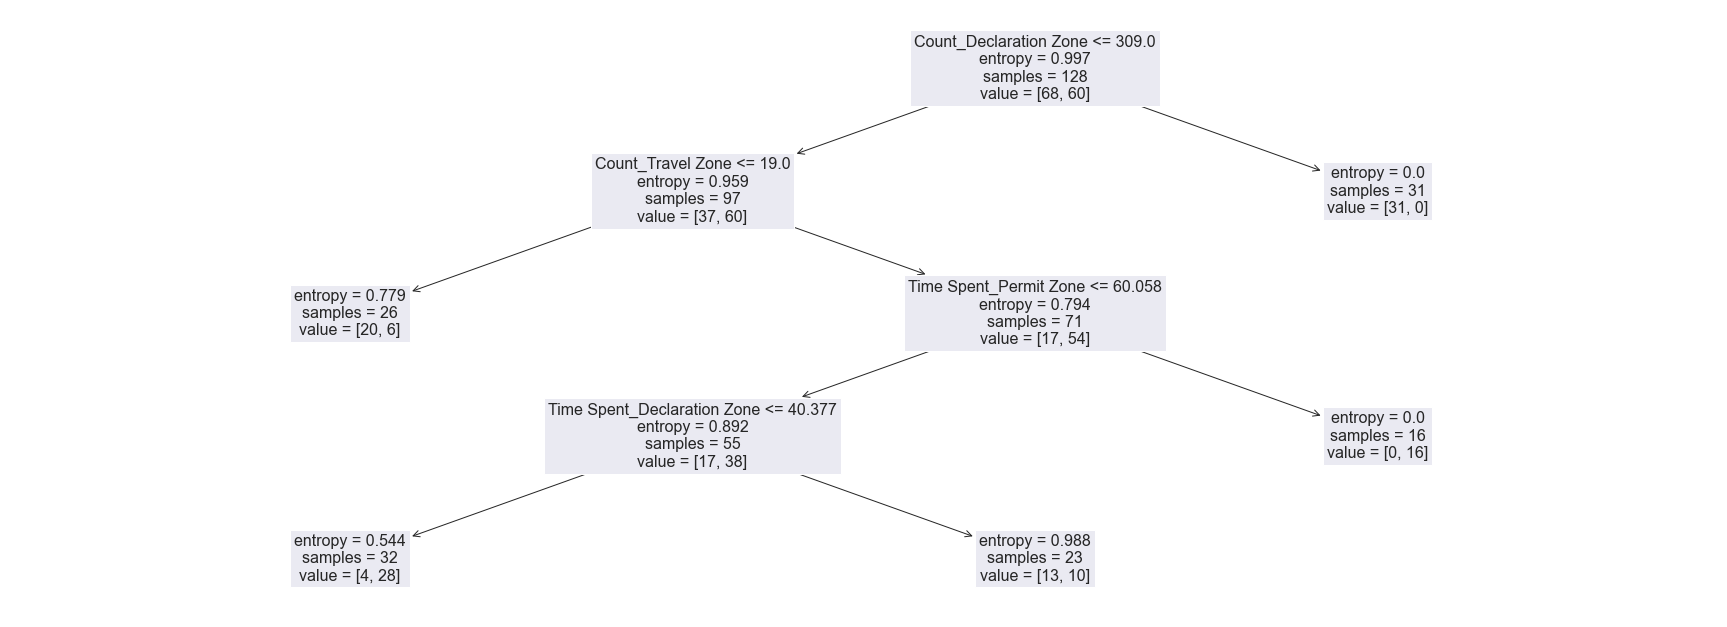

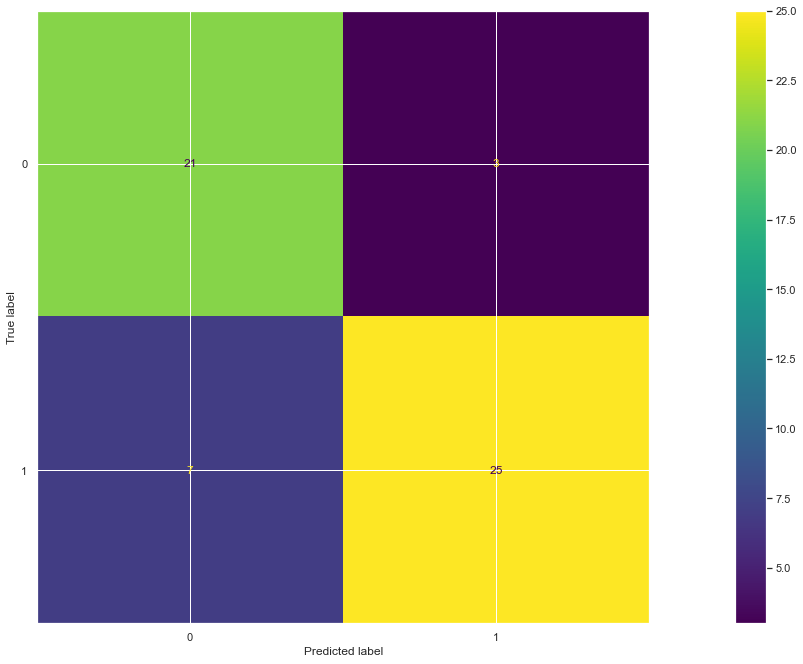

feature- Strange_oneframetoken :  Day : 32
Mean absolute error LR- 0.15789473684210525
Mean Squared error LR- 0.39735970711951313
Accuracy: 0.8421052631578947
F1: 0.8416666666666666
Precision: 0.8571428571428572
Recall: 0.8695652173913043


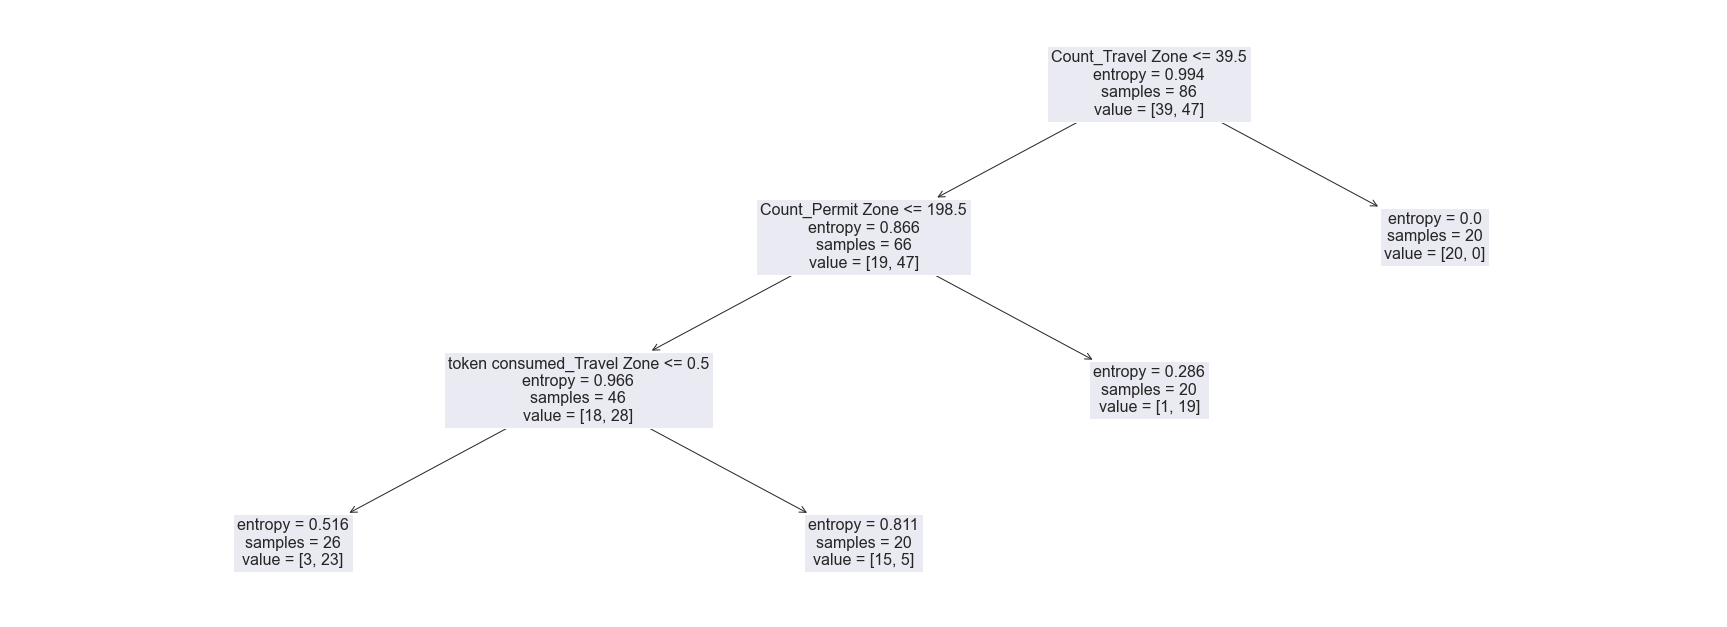

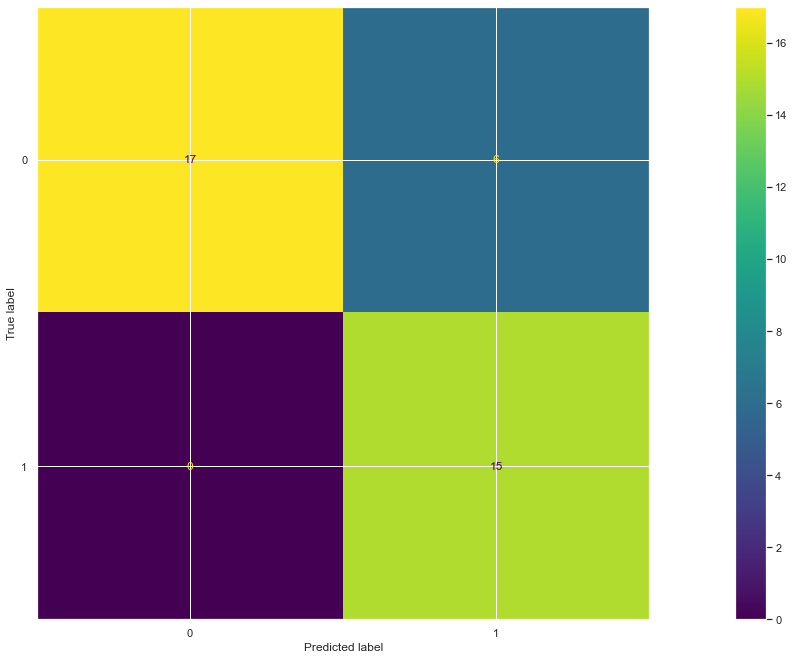

feature- Strange_oneframetoken :  Day : 34
Mean absolute error LR- 0.13157894736842105
Mean Squared error LR- 0.3627381250550058
Accuracy: 0.868421052631579
F1: 0.8637992831541219
Precision: 0.8607954545454546
Recall: 0.8681159420289855


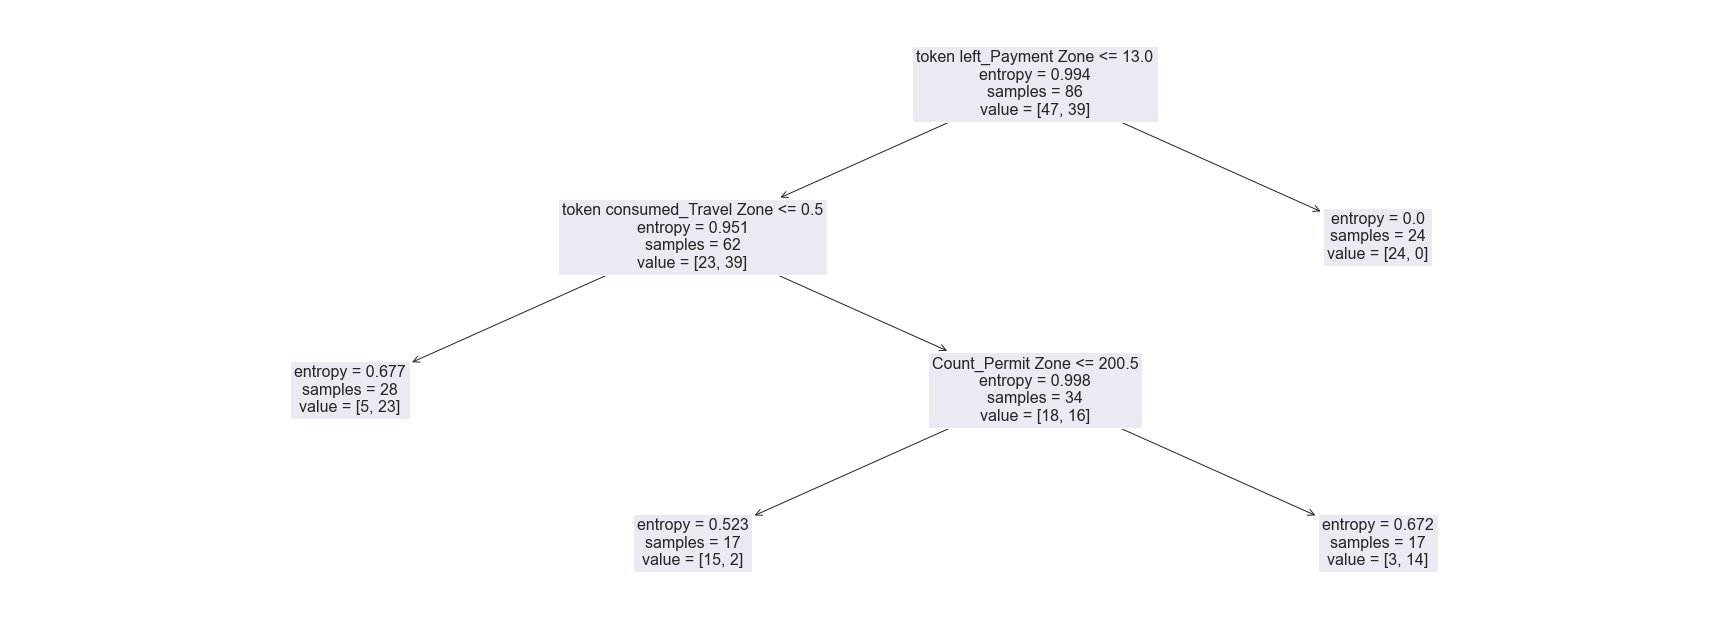

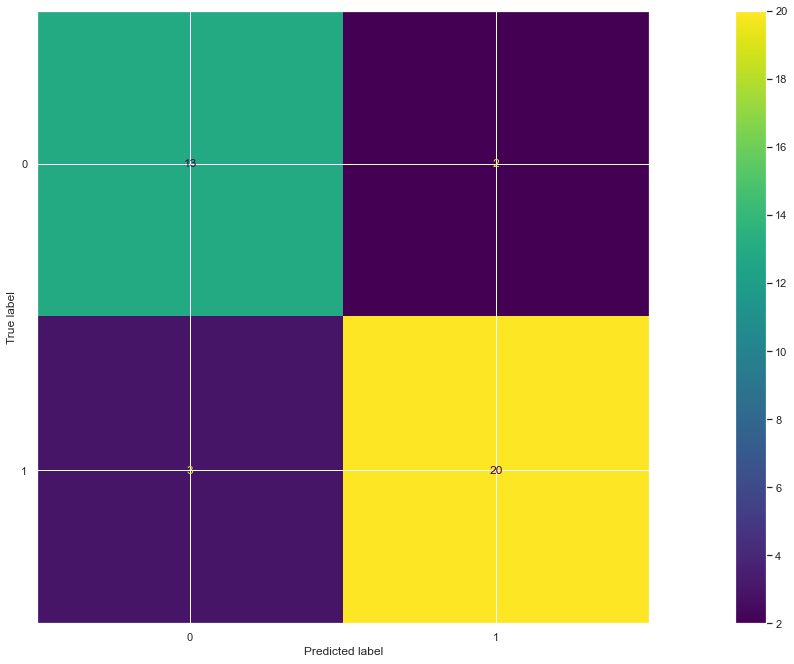

feature- Strange_oneframetoken :  Day : 36
Mean absolute error LR- 0.13157894736842105
Mean Squared error LR- 0.3627381250550058
Accuracy: 0.868421052631579
F1: 0.8637992831541219
Precision: 0.8607954545454546
Recall: 0.8681159420289855


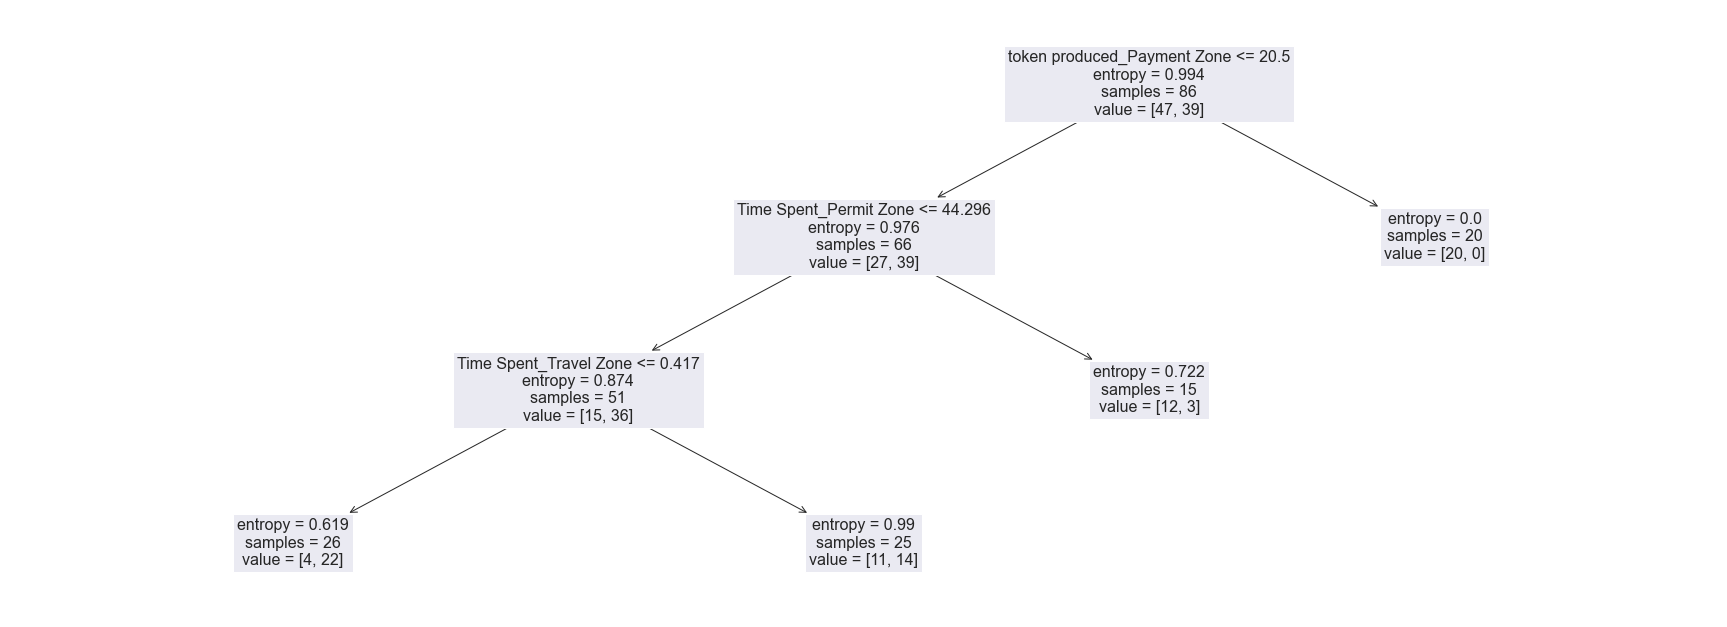

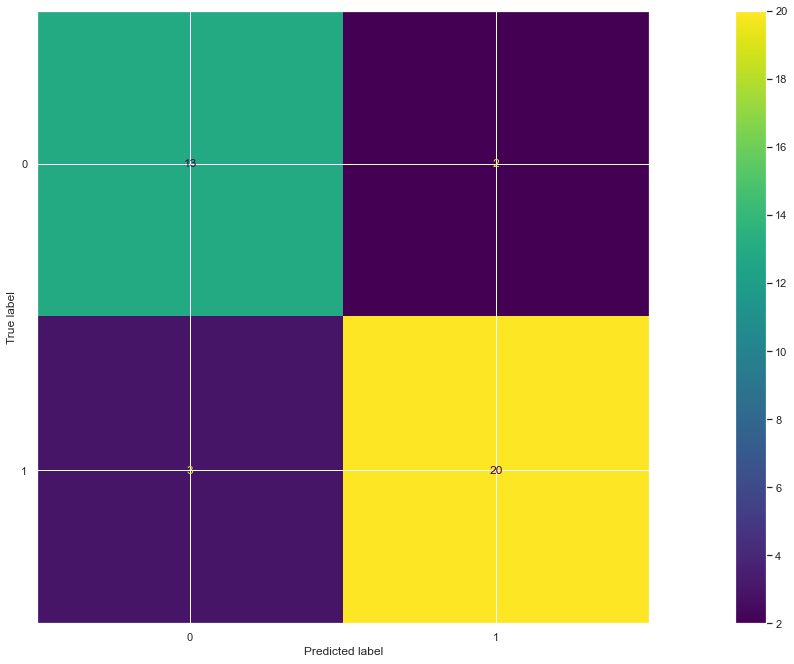

feature- Strange_oneframetoken :  Day : 40
Mean absolute error LR- 0.1794871794871795
Mean Squared error LR- 0.4236592728681617
Accuracy: 0.8205128205128205
F1: 0.8205128205128205
Precision: 0.8253968253968254
Recall: 0.8253968253968254


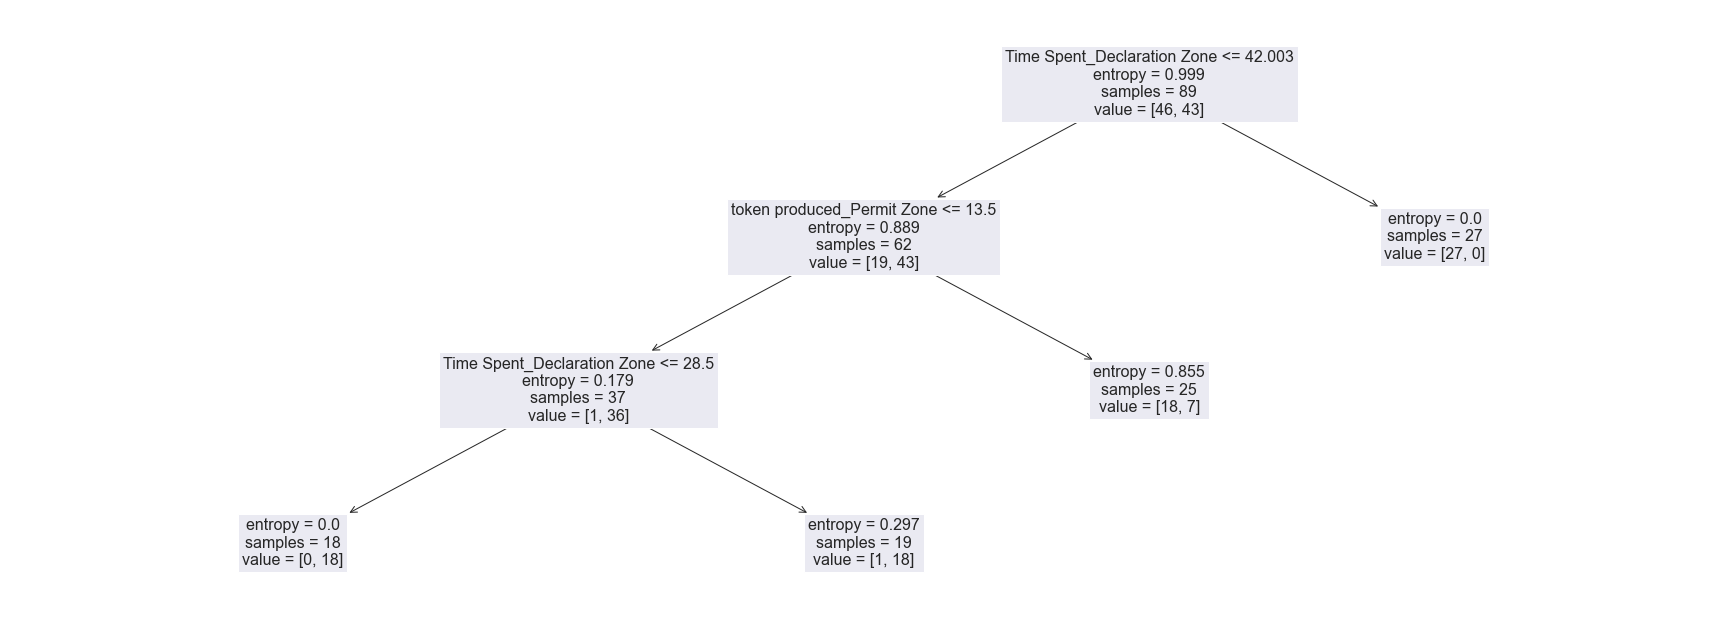

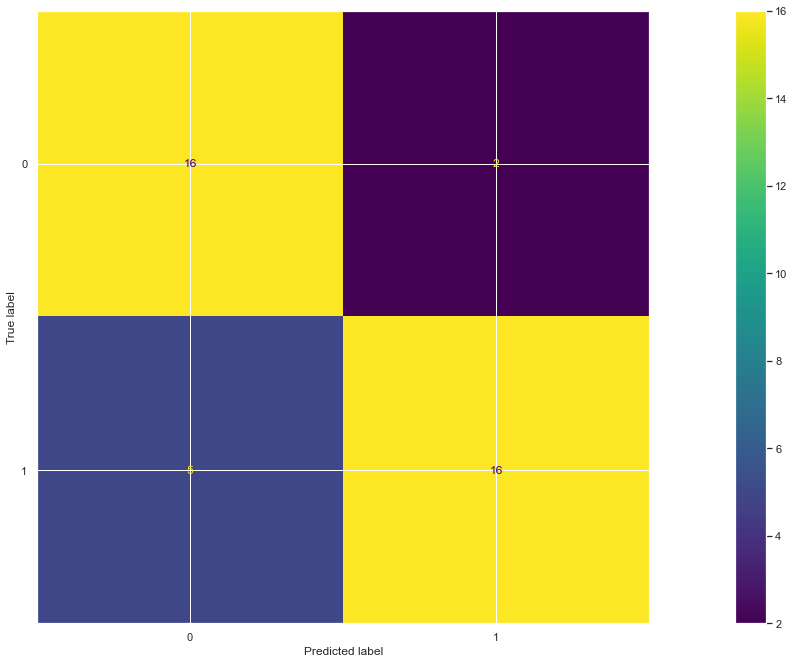

feature- Strange_oneframetoken :  Day : 41
Mean absolute error LR- 0.07692307692307693
Mean Squared error LR- 0.2773500981126146
Accuracy: 0.9230769230769231
F1: 0.9116981132075472
Precision: 0.9464285714285714
Recall: 0.8928571428571428


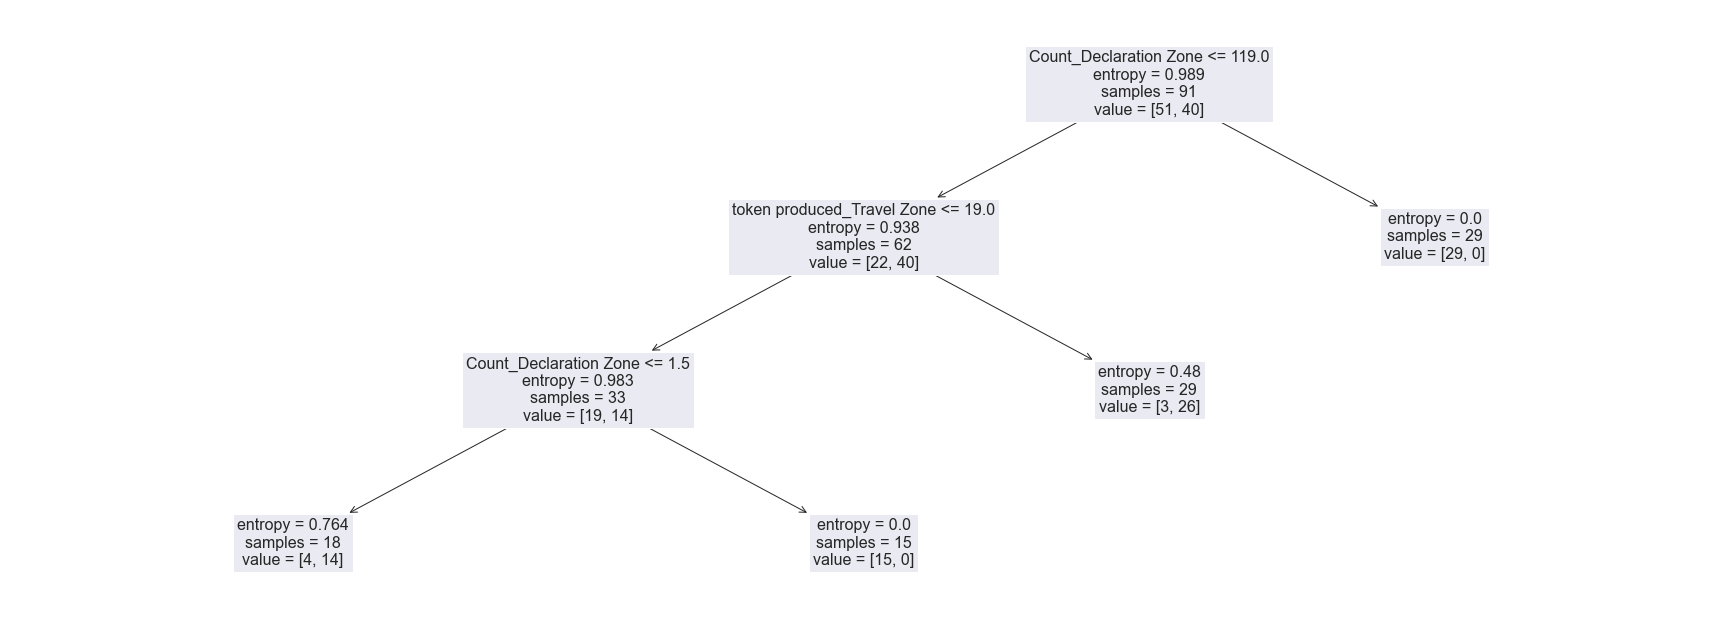

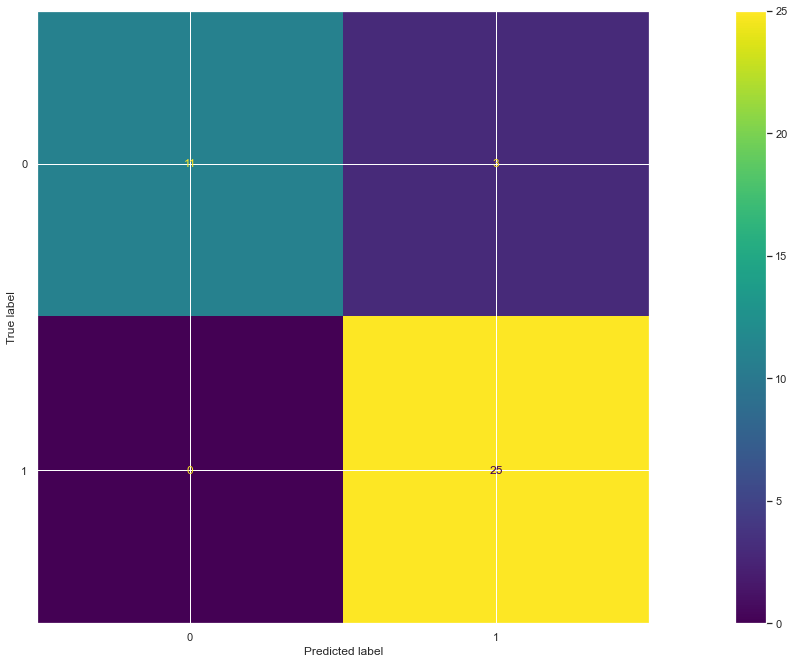

feature- Strange_oneframetoken :  Day : 45
Mean absolute error LR- 0.1951219512195122
Mean Squared error LR- 0.4417261042993862
Accuracy: 0.8048780487804879
F1: 0.8047619047619048
Precision: 0.8200483091787439
Recall: 0.8247549019607843


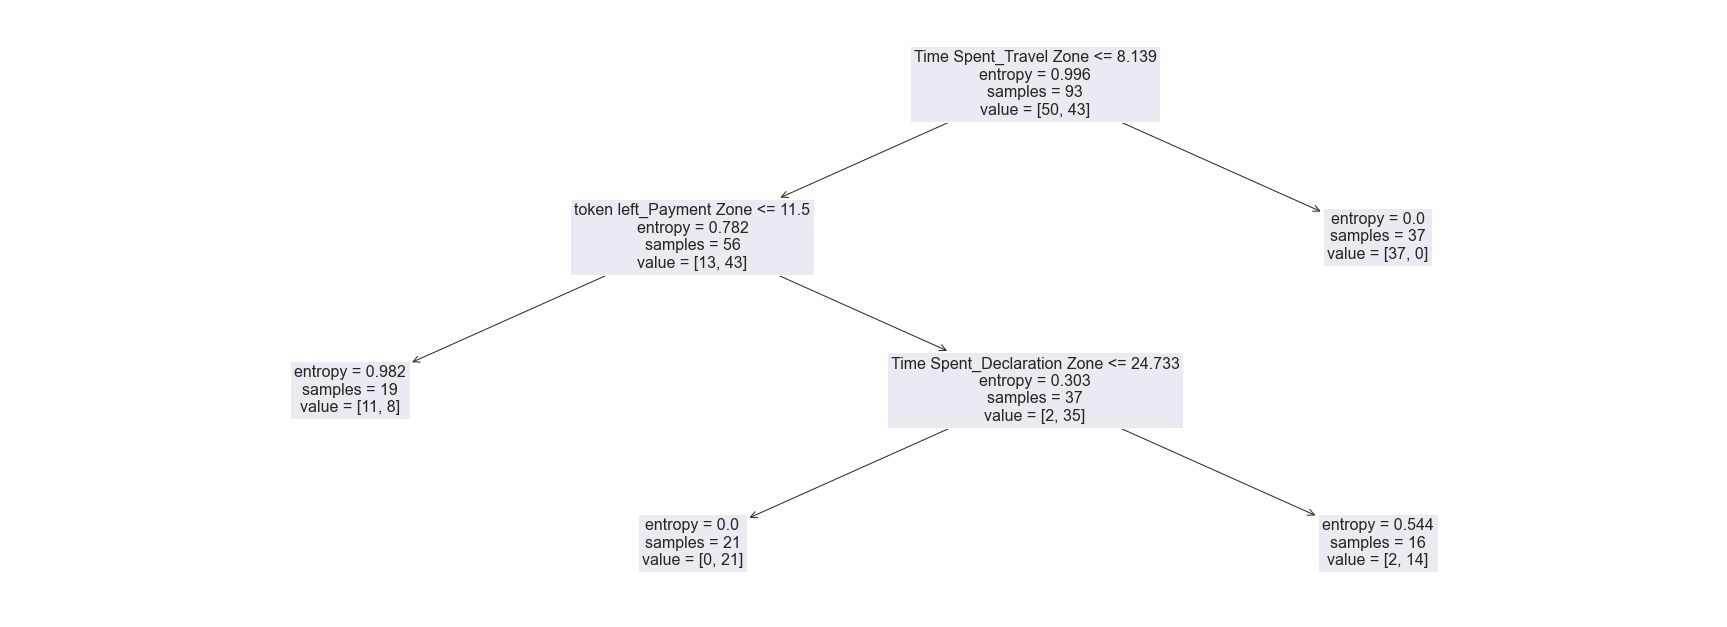

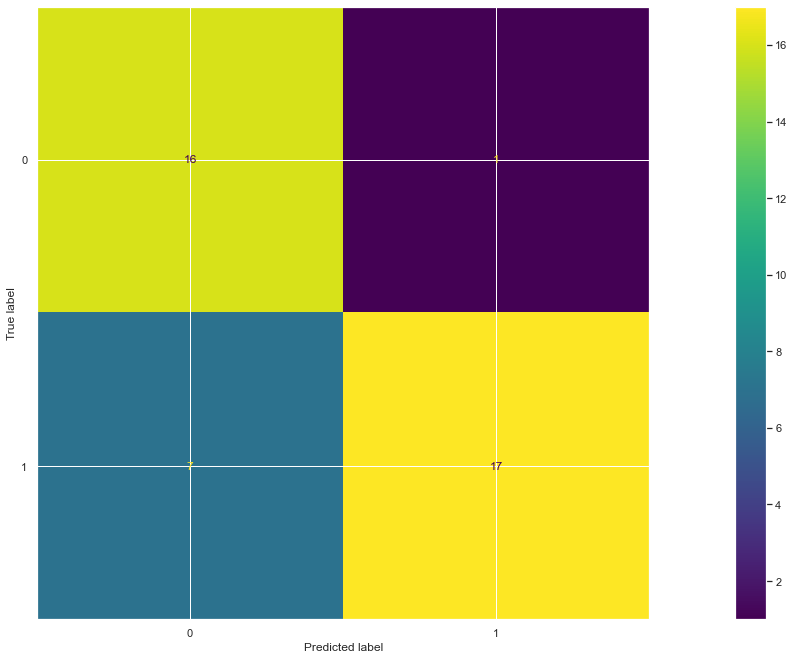

feature- Strange_oneframetoken :  Day : 46
Mean absolute error LR- 0.14634146341463414
Mean Squared error LR- 0.38254602783800296
Accuracy: 0.8536585365853658
F1: 0.8373015873015874
Precision: 0.9
Recall: 0.8235294117647058


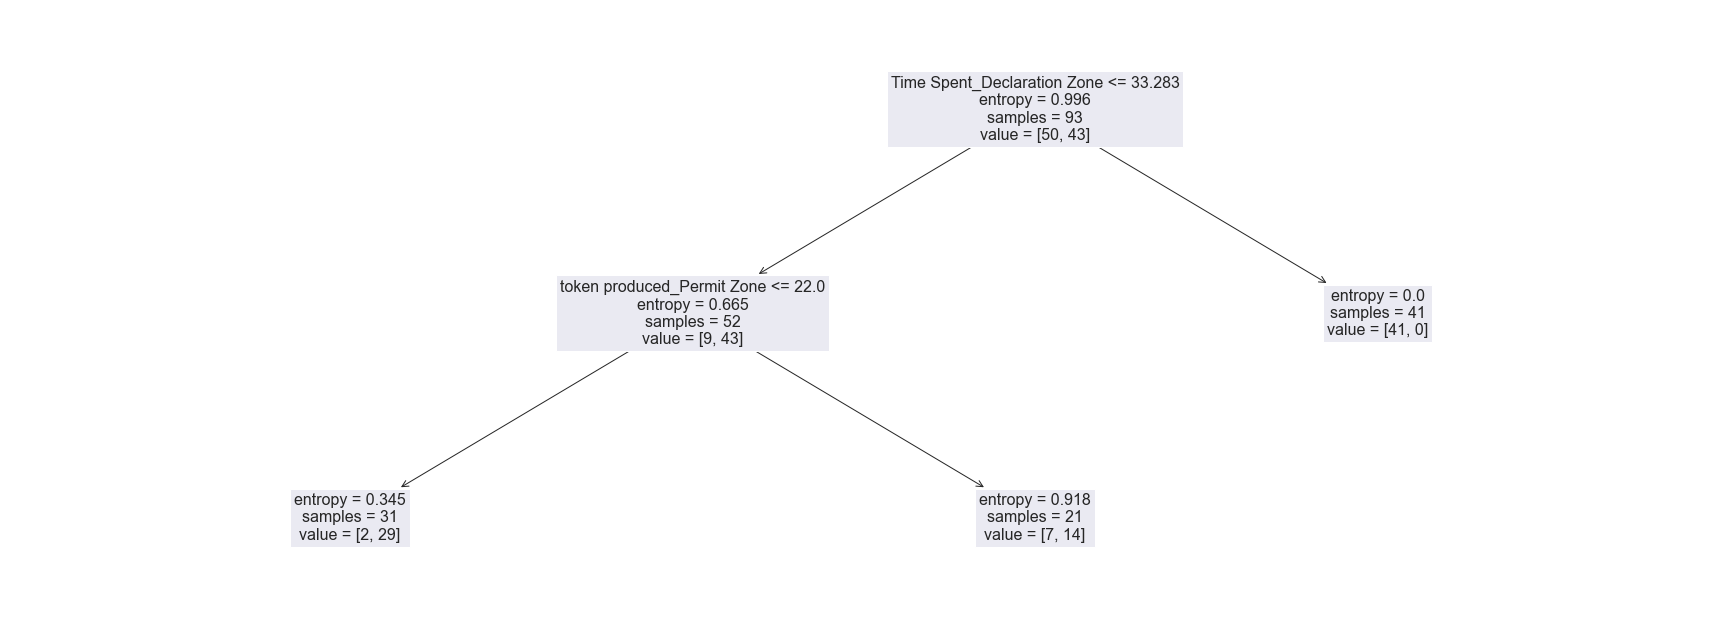

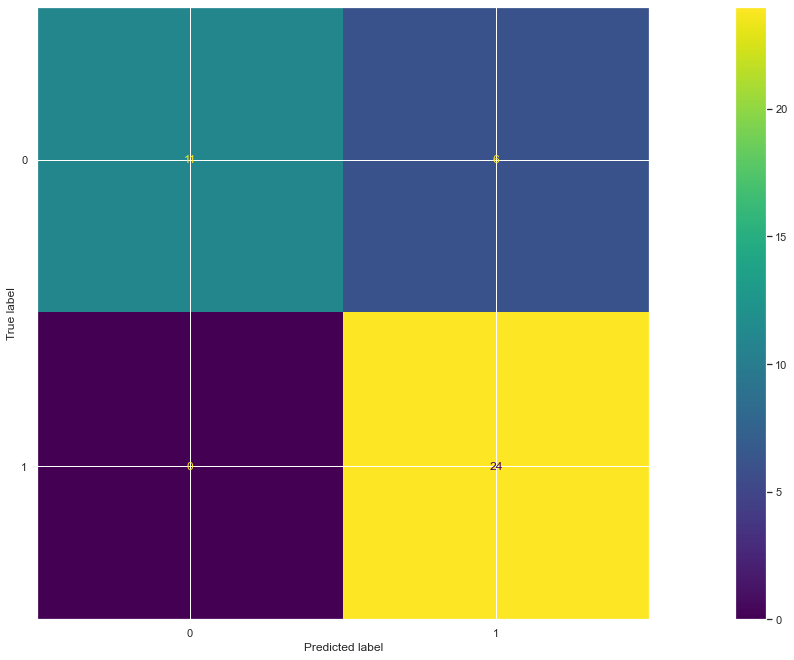

feature- Strange_oneframetoken :  Day : 47
Mean absolute error LR- 0.0975609756097561
Mean Squared error LR- 0.31234752377721214
Accuracy: 0.9024390243902439
F1: 0.9019138755980861
Precision: 0.9166666666666667
Recall: 0.9047619047619048


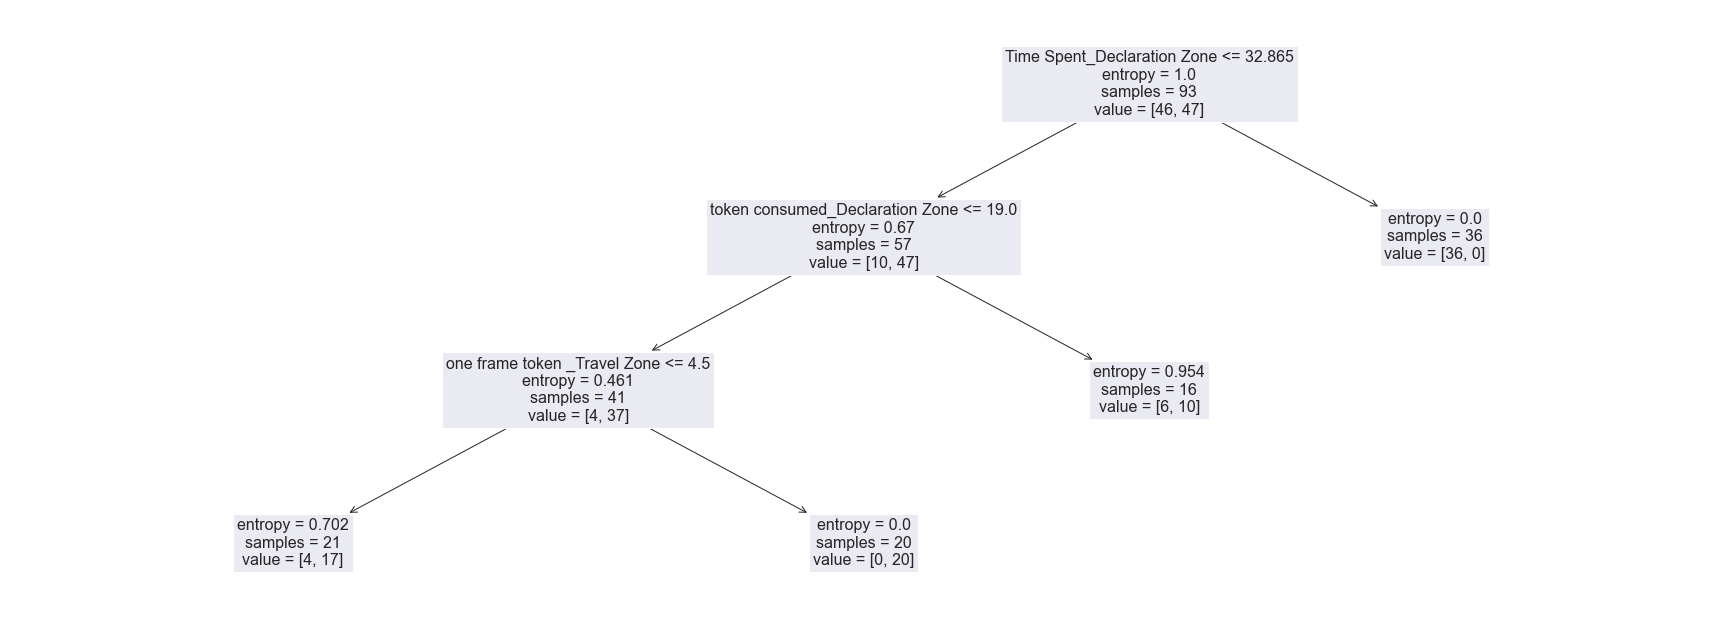

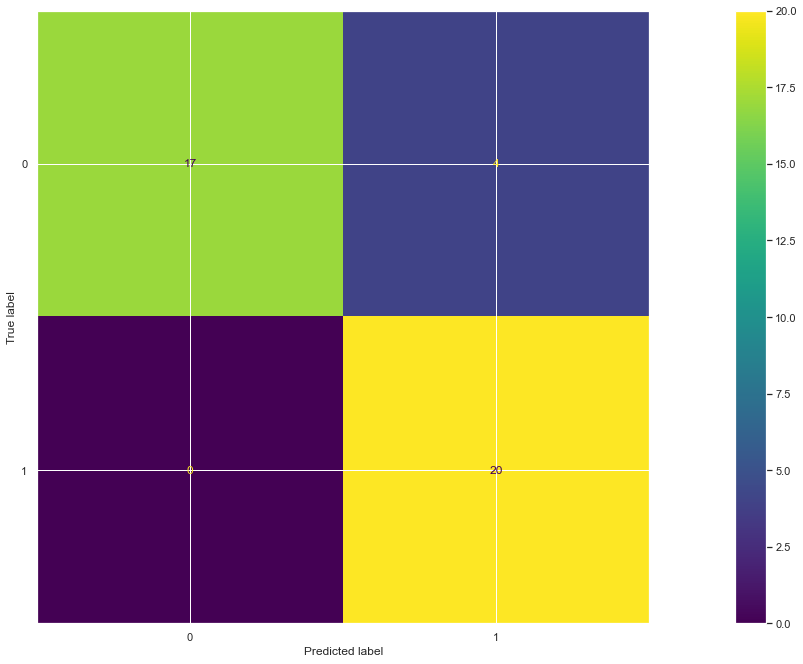

feature- Strange_oneframetoken :  Day : 49
Mean absolute error LR- 0.14634146341463414
Mean Squared error LR- 0.38254602783800296
Accuracy: 0.8536585365853658
F1: 0.849264705882353
Precision: 0.85
Recall: 0.8888888888888888


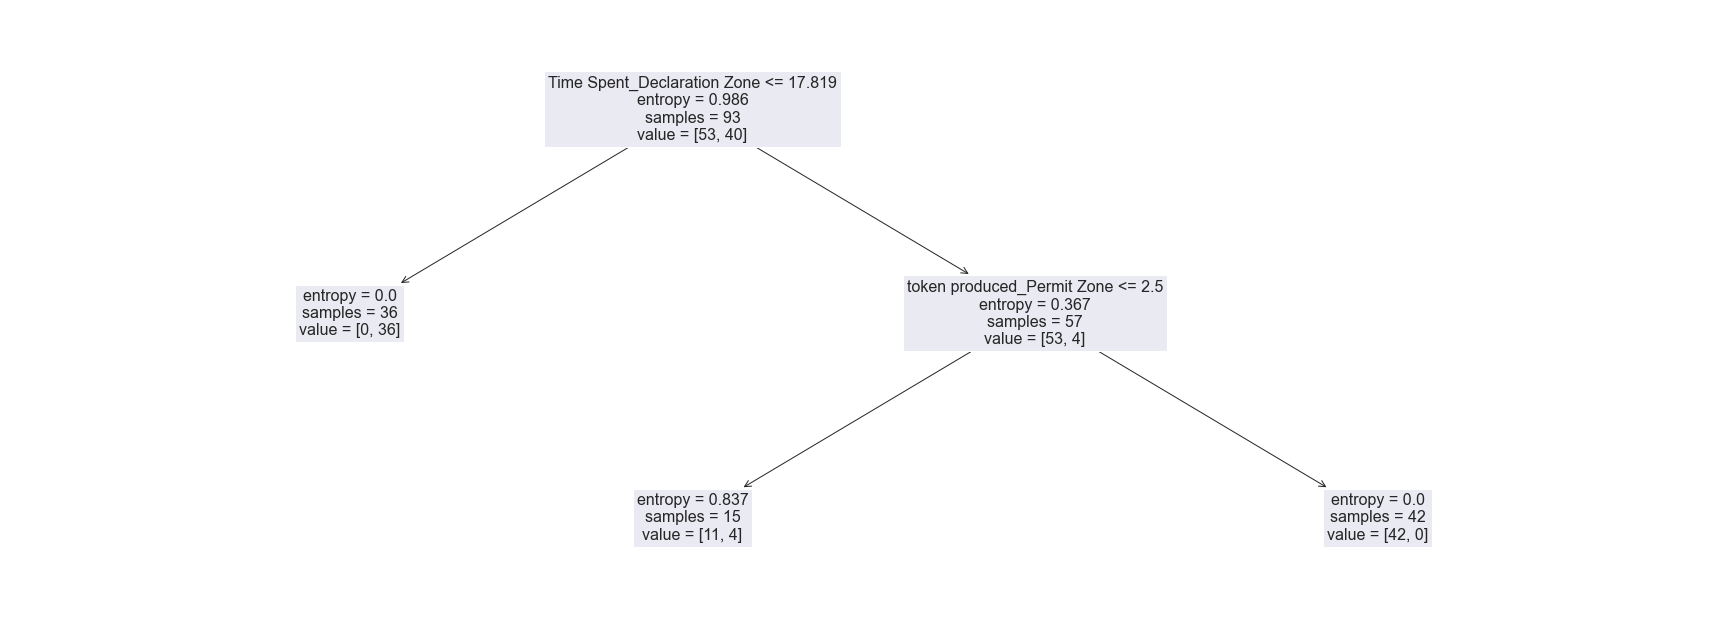

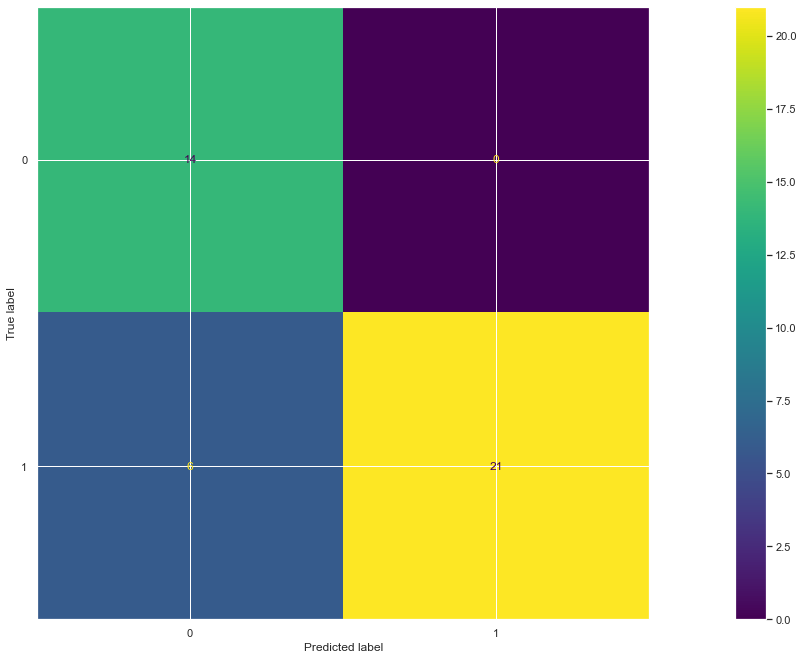

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [20]:
predictionDelay=50
targetfeaturelist=['Strange_tokenproduced', 'Strange_tokenconsumed', 'Strange_tokenleft','Strange_oneframetoken', 
             'Strange_Count', 'Strange_AverageTimeSpent']
targetzonelist=[WeeklyDeclarationZoneDF]
targetfeaturelist=['Strange_tokenleft','Strange_oneframetoken','Strange_Count', 'Strange_AverageTimeSpent']
for targetZone in targetzonelist:
    print(targetZone.name)
    predict(targetZone.copy(),zonelist.copy(),targetfeaturelist,predictionDelay)

# Appendix (Additional test and Analysis)

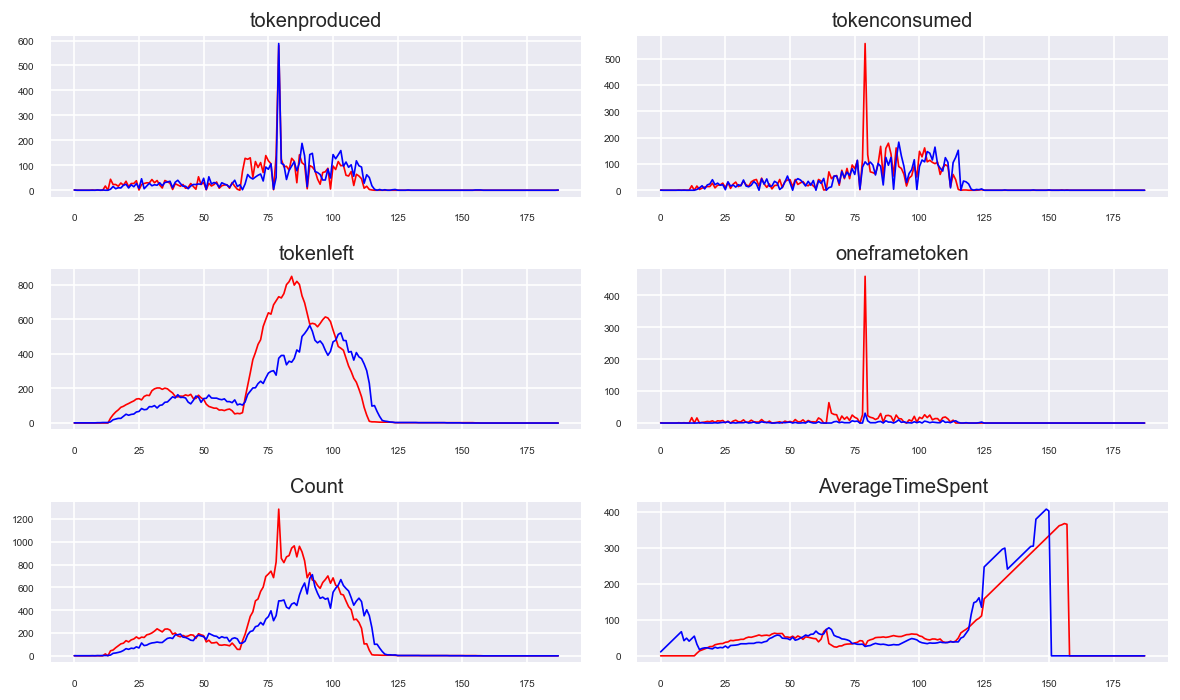

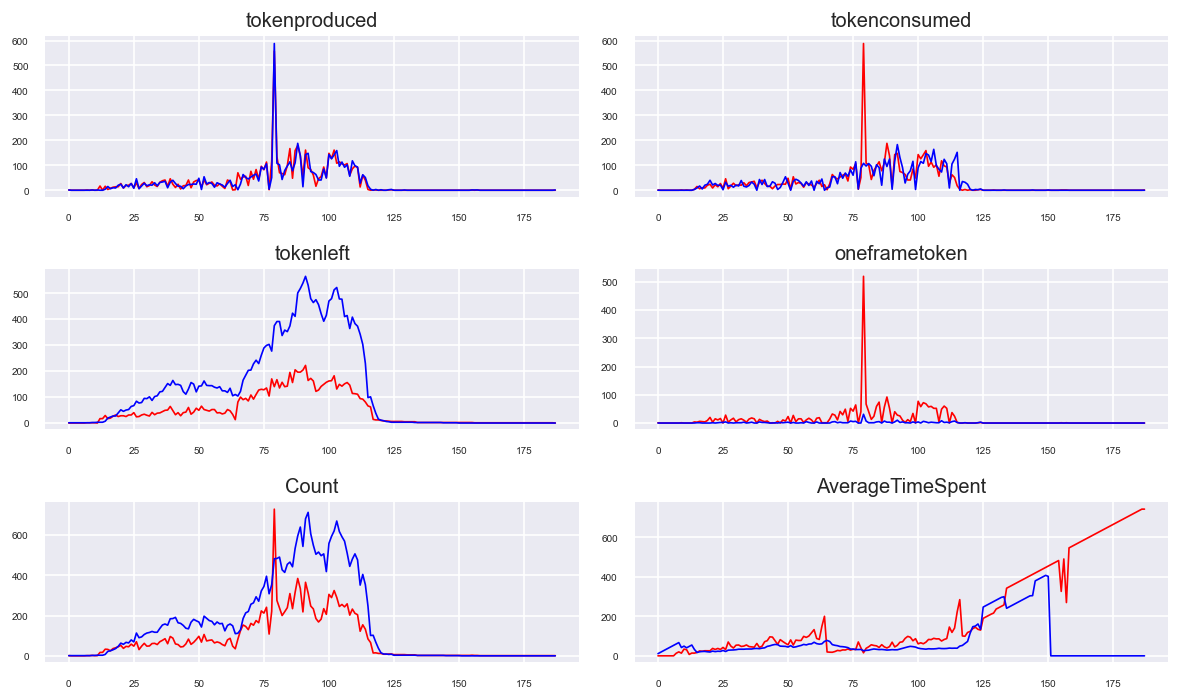

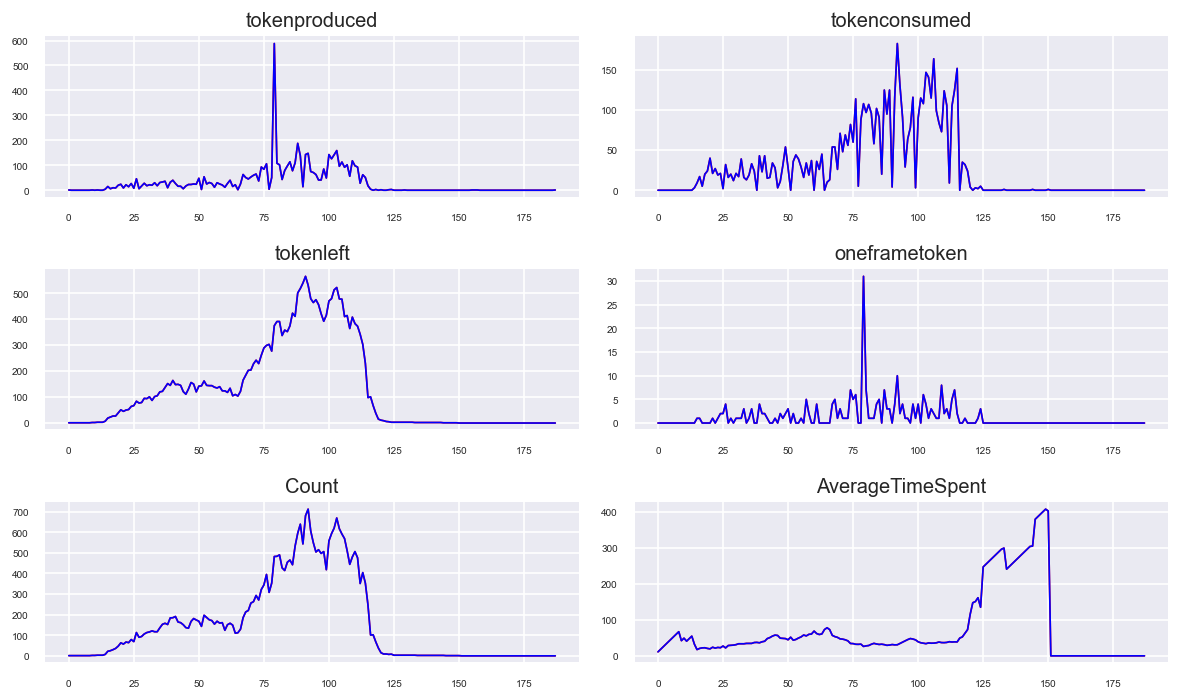

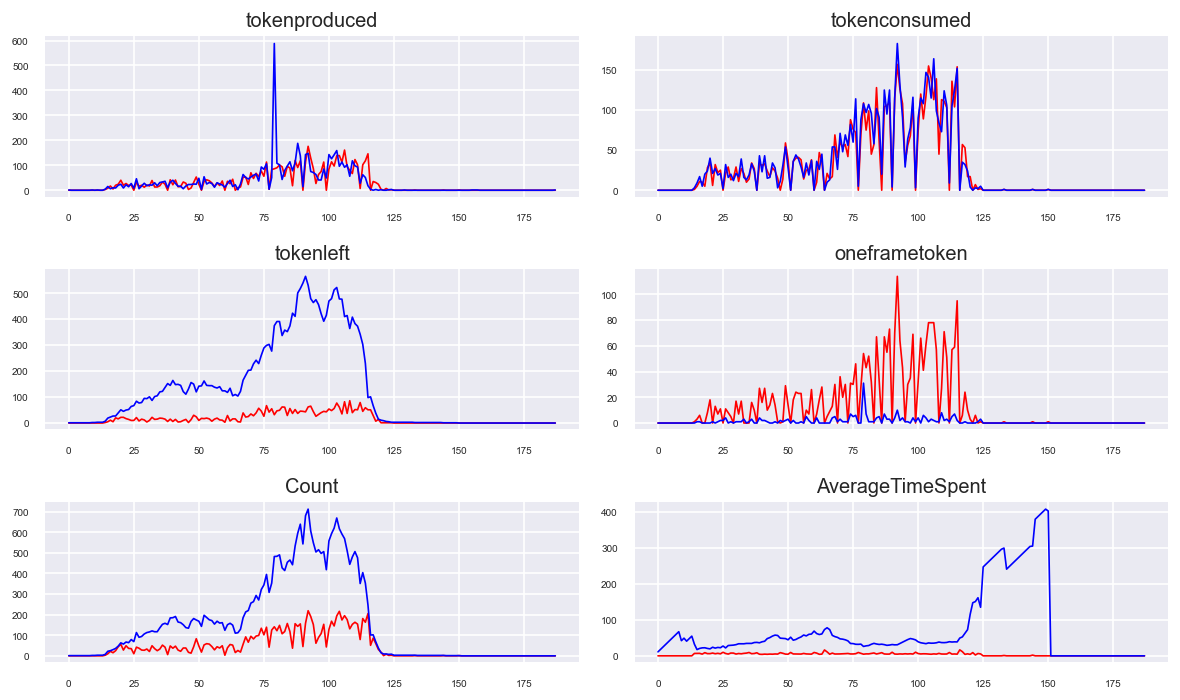

In [22]:
zonelist=[WeeklyCreatePermitZoneDF,WeeklyTravelZoneDF,WeeklyDeclarationZoneDF,WeeklyPaymentZoneDF]

featurelist=['tokenproduced', 'tokenconsumed', 'tokenleft','oneframetoken', 'Count', 'AverageTimeSpent']

for zone in zonelist:
    fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        feature=featurelist[i]
        data = zone[feature]
        ax.plot(data, color='red', linewidth=1)
        ax.plot(WeeklyDeclarationZoneDF[feature], color='blue', linewidth=1)
        
        # Decorations
        ax.set_title(feature)
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();
     

Declaration Zone
feature- Strange_tokenproduced :  Day : 0
Mean absolute error LR- 0.18032786885245902
Mean Squared error LR- 0.4246502900652006
Accuracy: 0.819672131147541
F1: 0.8063492063492064
Precision: 0.8402255639097744
Recall: 0.7983516483516484


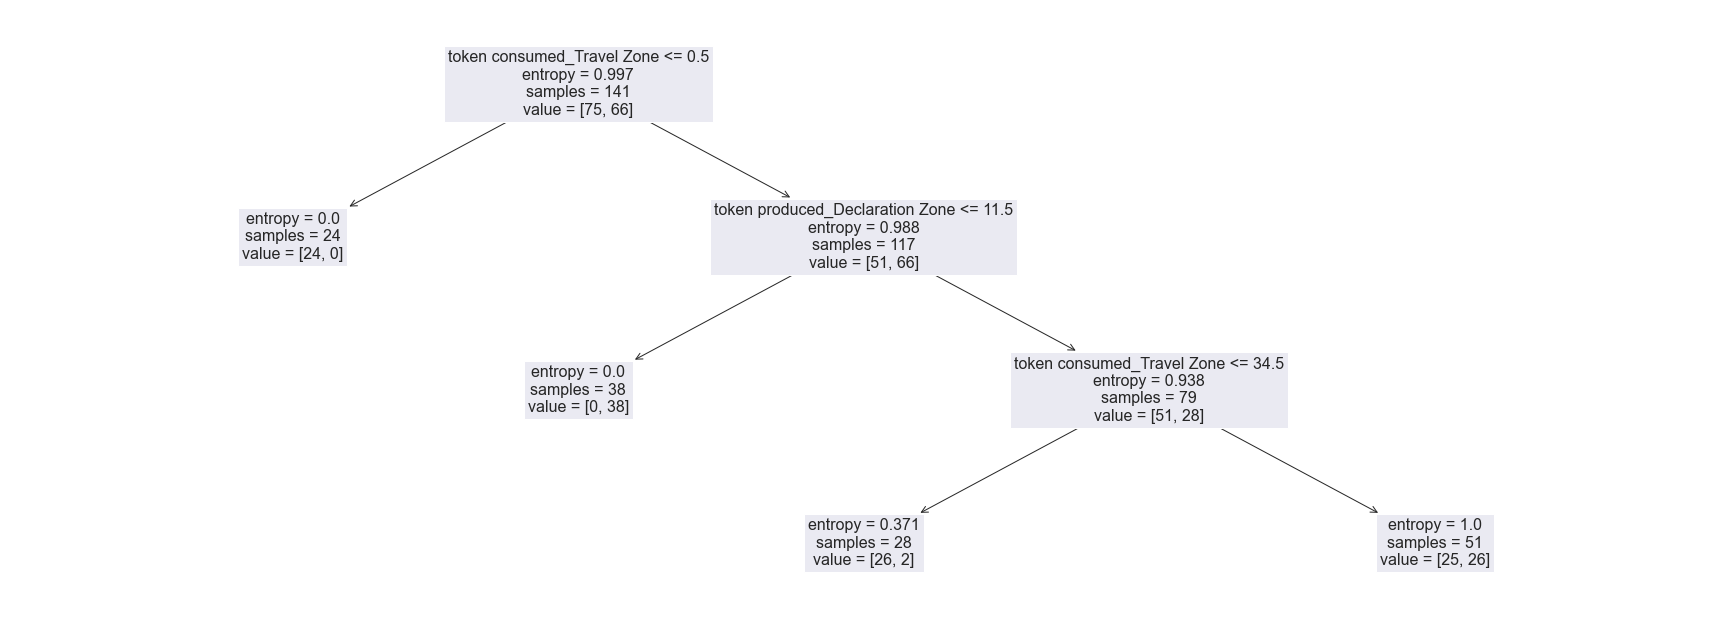

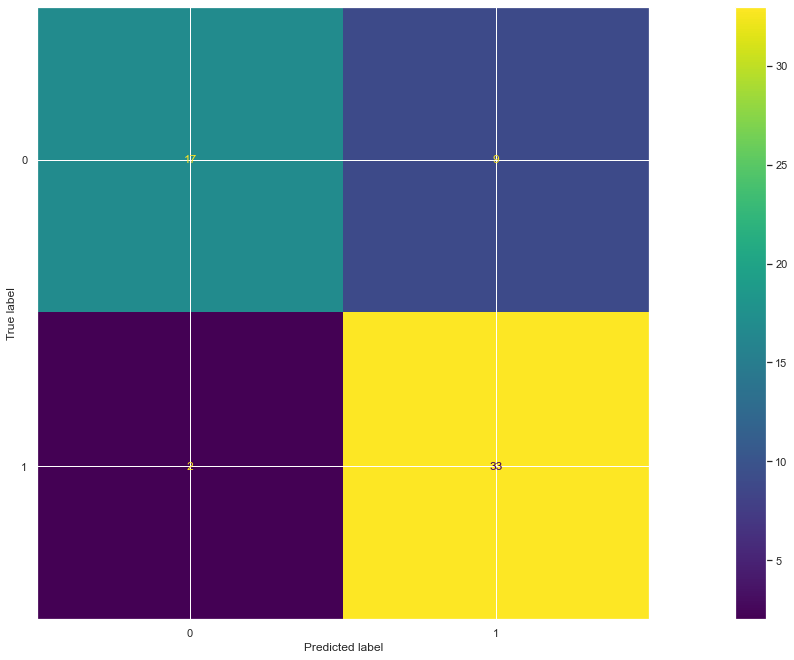

feature- Strange_tokenconsumed :  Day : 19
Mean absolute error LR- 0.16981132075471697
Mean Squared error LR- 0.4120816918460671
Accuracy: 0.8301886792452831
F1: 0.829946524064171
Precision: 0.8398550724637681
Recall: 0.835


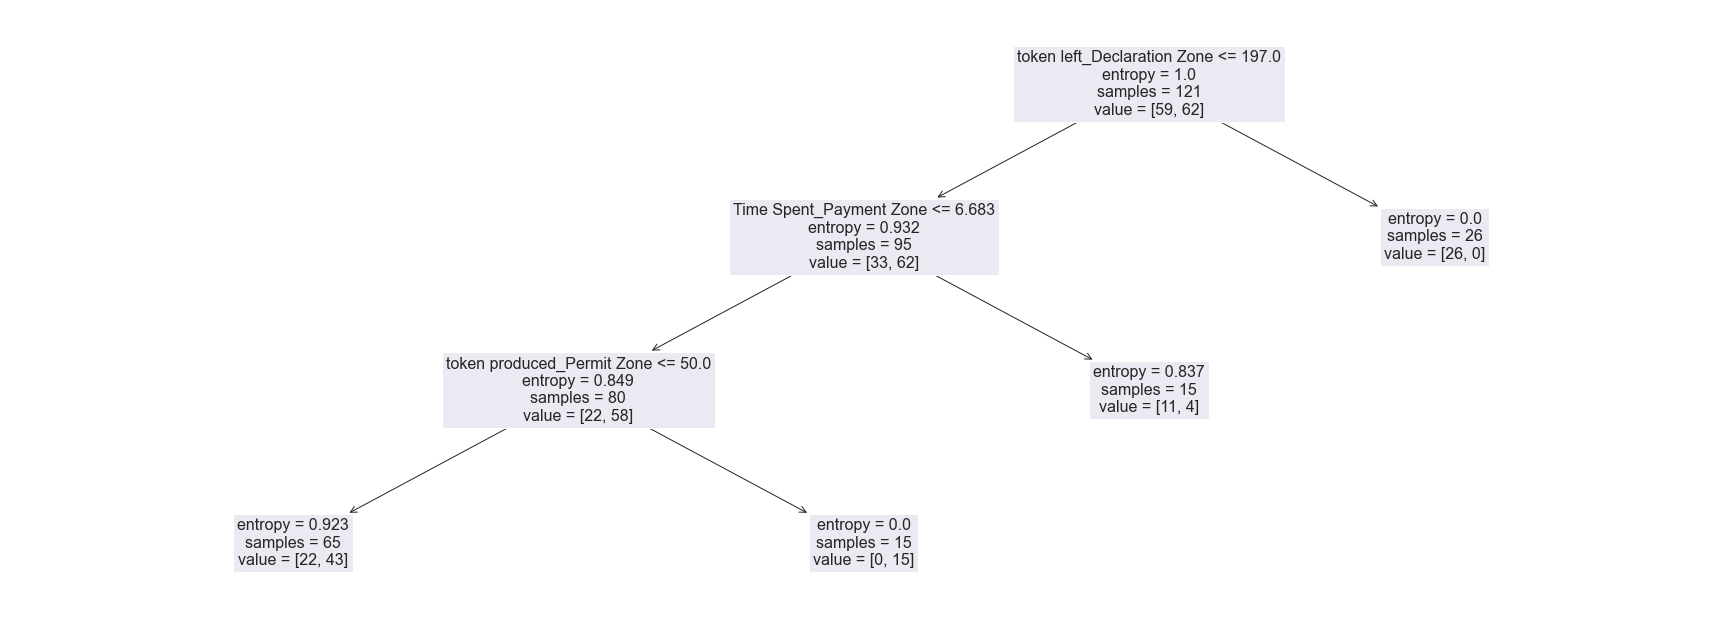

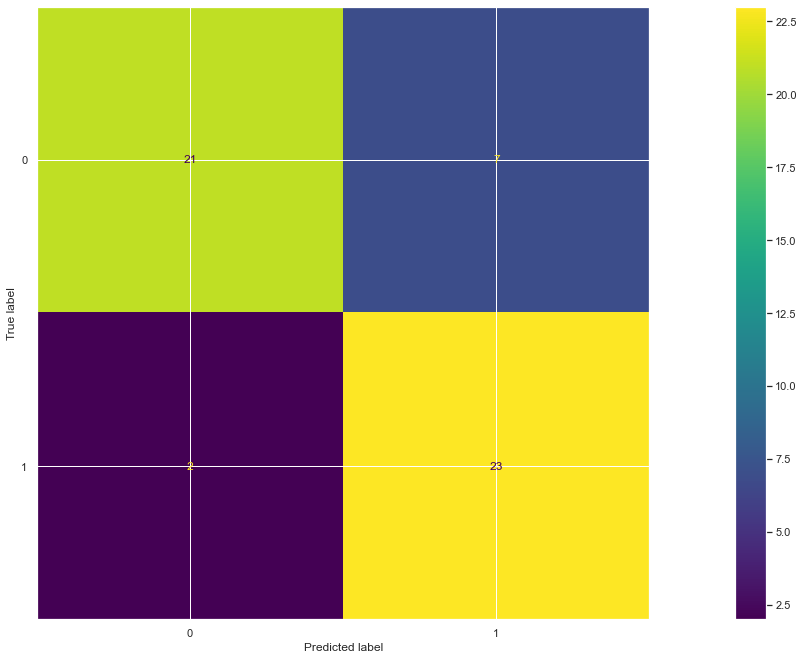

feature- Strange_tokenconsumed :  Day : 26
Mean absolute error LR- 0.17857142857142858
Mean Squared error LR- 0.4225771273642583
Accuracy: 0.8214285714285714
F1: 0.8193548387096774
Precision: 0.8476190476190476
Recall: 0.826309067688378


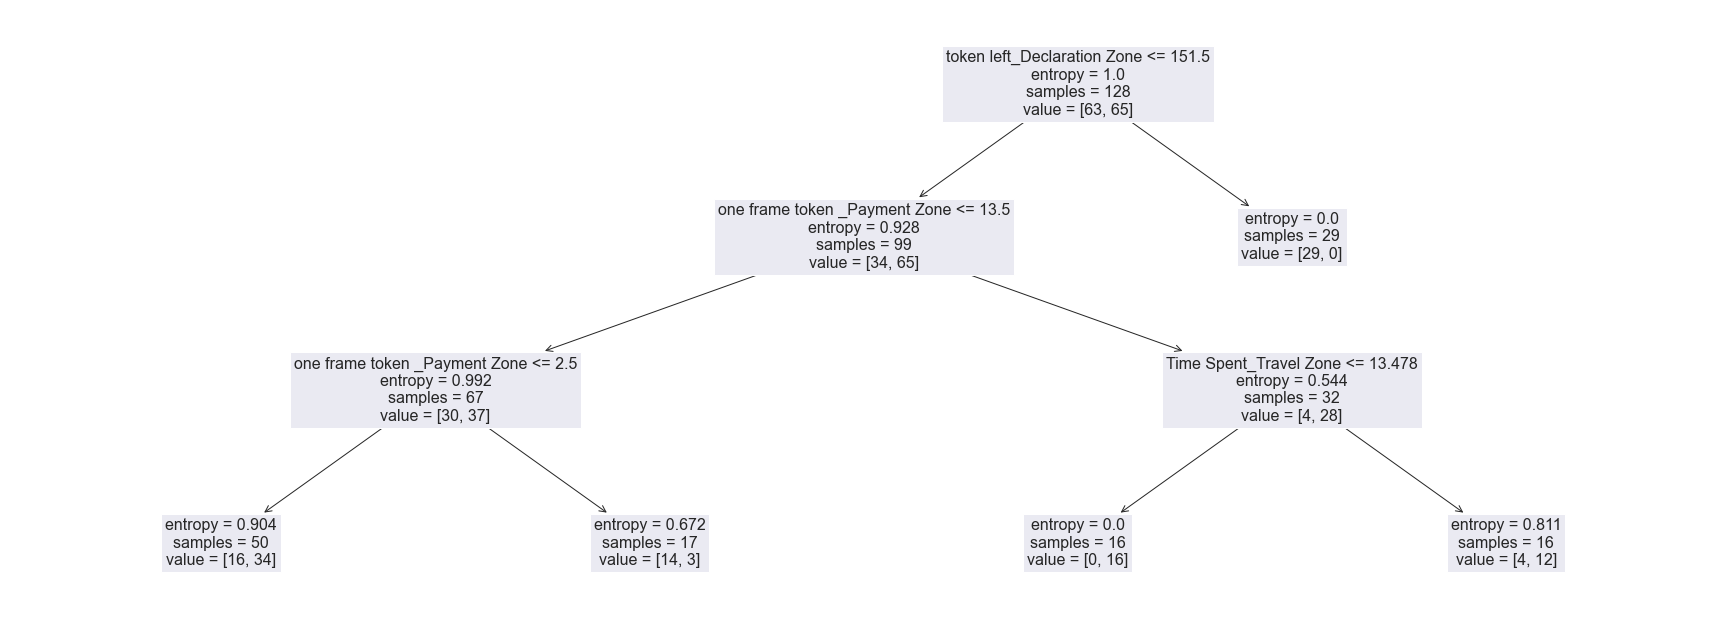

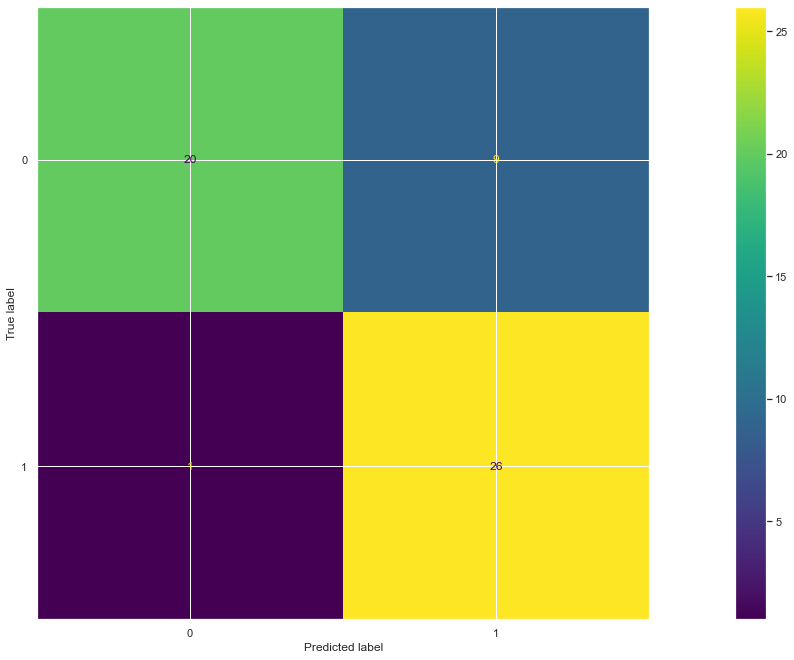

feature- Strange_tokenleft :  Day : 12
Mean absolute error LR- 0.1111111111111111
Mean Squared error LR- 0.3333333333333333
Accuracy: 0.8888888888888888
F1: 0.8795986622073578
Precision: 0.9199999999999999
Recall: 0.8666666666666667


KeyboardInterrupt: 

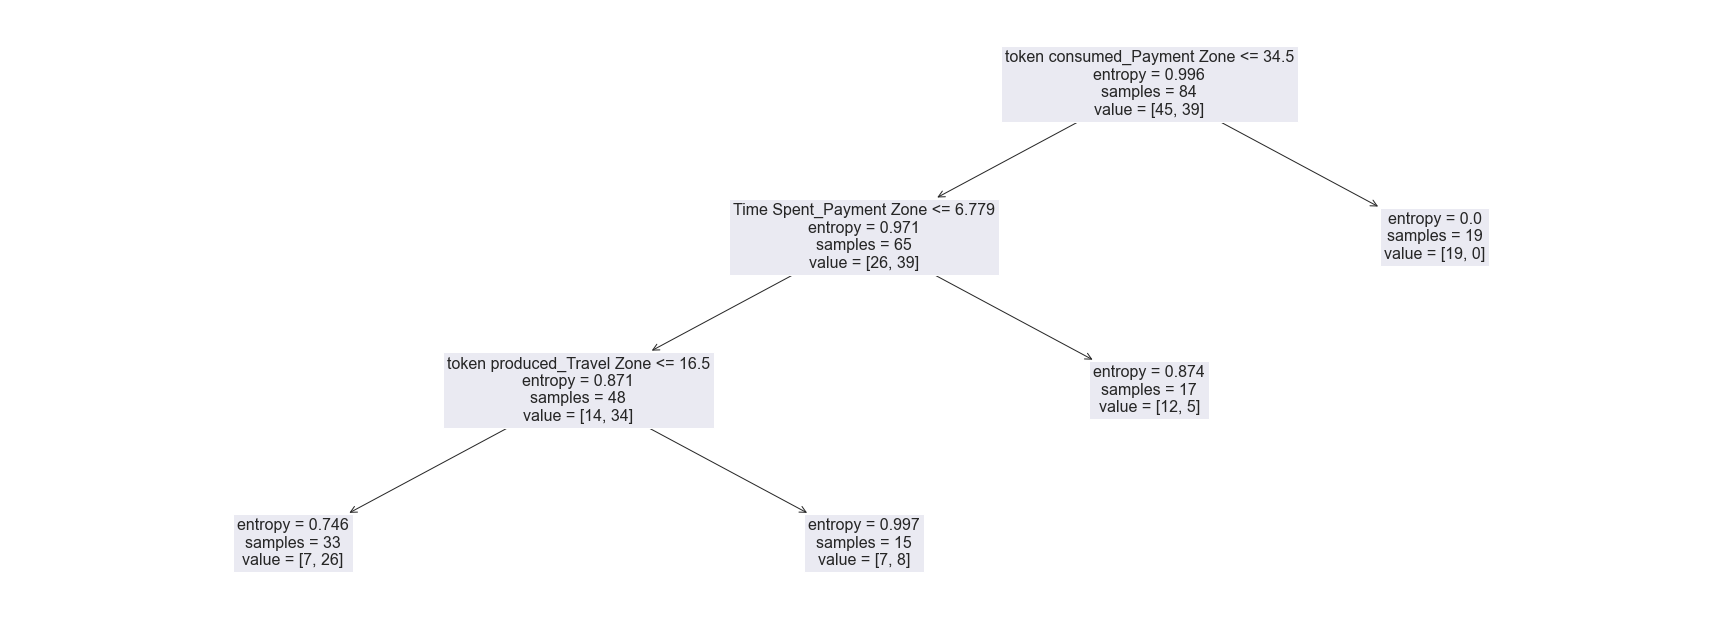

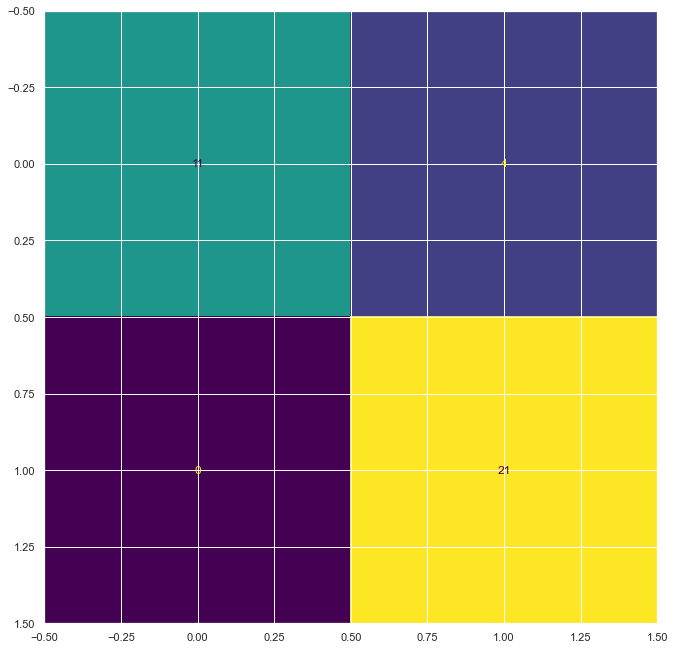

In [16]:
predictionDelay=30
targetfeaturelist=['Strange_tokenproduced', 'Strange_tokenconsumed', 'Strange_tokenleft','Strange_oneframetoken', 
             'Strange_Count', 'Strange_AverageTimeSpent']

for targetZone in targetzonelist:
    print(targetZone.name)
    predict(targetZone.copy(),zonelist.copy(),targetfeaturelist,predictionDelay)

NameError: name 'stationarize' is not defined

# Creating the combined dataframe

In [69]:
combineddata

index_x       date  tokenproduced_x  tokenconsumed_x  tokenleft_x  \
0          1 2016-10-09                1                1            0   
1          2 2016-10-16                0                0            0   
2          3 2016-10-23                0                0            0   
3          4 2016-10-30                0                0            0   
4          5 2016-11-06                0                0            0   
..       ...        ...              ...              ...          ...   
134      135 2019-05-05                0                0            2   
135      136 2019-05-12                0                0            2   
136      137 2019-05-19                0                0            2   
137      138 2019-05-26                0                0            2   
138      139 2019-06-02                0                0            2   

     oneframetoken_x       TimeSpent_x  Count_x  DaysSpent_x  \
0                  1   0 days 00:00:00        1            0   
1                  0   0 days 00:00:00        0            0   
2                  0   0 days 00:00:00        0            0   
3                  0   0 days 00:00:00        0            0   
4                  0   0 days 00:00:00        0            0   
..               ...               ...      ...          ...   
134                0 442 days 15:37:14        2          442   
135                0 456 days 15:37:14        2          456   
136                0 470 days 15:37:14        2          470   
137                0 484 days 15:37:14        2          484   
138                0 498 days 15:37:14        2          498   

     AverageTimeSpent_x  ...  Strange_tokenproduced_40  \
0                   0.0  ...                       1.0   
1                   0.0  ...                       0.0   
2                   0.0  ...                       0.0   
3                   0.0  ...                       0.0   
4                   0.0  ...                       1.0   
..                  ...  ...                       ...   
134               221.0  ...                       0.0   
135               228.0  ...                       0.0   
136               235.0  ...                       0.0   
137               242.0  ...                       0.0   
138               249.0  ...                       0.0   

     Strange_tokenproduced_41  Strange_tokenproduced_42  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       1.0   
3                         1.0                       0.0   
4                         0.0                       0.0   
..                        ...                       ...   
134                       0.0                       0.0   
135                       0.0                       0.0   
136                       0.0                       0.0   
137                       0.0                       0.0   
138                       0.0                       0.0   

     Strange_tokenproduced_43  Strange_tokenproduced_44  \
0                         0.0                       1.0   
1                         1.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                       0.0   
..                        ...                       ...   
134                       0.0                       0.0   
135                       0.0                       0.0   
136                       0.0                       0.0   
137                       0.0                       0.0   
138                       0.0                       0.0   

     Strange_tokenproduced_45  Strange_tokenproduced_46  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0

In [45]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
sns.set(rc={'figure.figsize':(40.7,11.27)})
def traindtmultiple(x,y,columnlist,feature,i):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4,random_state=42)
    clf = tree.DecisionTreeClassifier(max_depth=7,class_weight='balanced')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
    scores = cross_val_score(clf, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
    print('feature-',feature,':',' Day :',i)
        
    print('Mean ROC AUC: %.3f' % mean(scores))
    clf = clf.fit(x_train, y_train)
    prediction=clf.predict(x_test)
    Y_test_pred = pd.DataFrame(prediction).applymap(lambda x: 1 if x>0.5 else 0)
    #Y_test_pred = pd.DataFrame(prediction)
    if accuracy_score(y_test, Y_test_pred)>0.7 and accuracy_score(y_test, Y_test_pred)<1 and f1_score(y_test, Y_test_pred, average="macro")>0.7:
        print('feature-',feature,':',' Day :',i)
        print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
        metrics.mean_squared_error(y_test, Y_test_pred)
        print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
        print("Accuracy:",accuracy_score(y_test, Y_test_pred))
        print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
        print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
        print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
        tree.plot_tree(clf,feature_names=columnlist,fontsize=12)
        plt.rcParams.update({'font.size': 26})

        cm = confusion_matrix(y_test, Y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()



def predict(targetZone,predictorZone,featurelist,predictionDelay):
    for feature in featurelist:
        combineddata=None
        for i in range(len(predictorZone)):
            if combineddata is None:
                combineddata=pd.merge(predictorZone[0],predictorZone[1],on=['date'],how='left',suffixes=("_"+predictorZone[0].name, "_"+predictorZone[1].name))
                combineddata['tokenproduced']=0
                combineddata['tokenconsumed']=0
                combineddata['tokenleft']=0
                combineddata['Count']=0
                combineddata['oneframetoken']=0
                combineddata['AverageTimeSpent']=0
            elif i>1:
                combineddata=combineddata.merge(predictorZone[i],on=['date'],how='left',suffixes=(None,"_"+predictorZone[i].name))
            
        def categorise(row,numdays):   
            return row['date'] -  datetime.timedelta(days=7)
        for j in range (predictionDelay):
            combineddata=combineddata.merge(targetZone[['date',feature]].rename({feature: feature+'_'+str(j)}, axis=1), on='date', how='left')
            targetZone['date'] = targetZone.apply(lambda row: categorise(row,j), axis=1)
        combineddata=combineddata.dropna()
        for j in range (predictionDelay):
            combineddata[feature+'_'+str(j)] = combineddata[feature+'_'+str(j)].astype(int)
        
        columnlist=[]
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('token')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('oneframetoken')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('DaysSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('AverageTimeSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('Count')].columns)
        x = combineddata[columnlist]
        for i in range(predictionDelay):
            y = combineddata[feature+'_'+str(i)].fillna(0).copy()
            x = combineddata[columnlist].copy()
            traindtmultiple(x,y,columnlist,feature,i)


Travel Zone
feature- Strange_tokenleft :  Day : 0
Mean ROC AUC: 0.659
feature- Strange_tokenleft :  Day : 0
Mean absolute error LR- 0.10714285714285714
Mean Squared error LR- 0.32732683535398854
Accuracy: 0.8928571428571429
F1: 0.8916129032258064
Precision: 0.8916129032258064
Recall: 0.8916129032258064


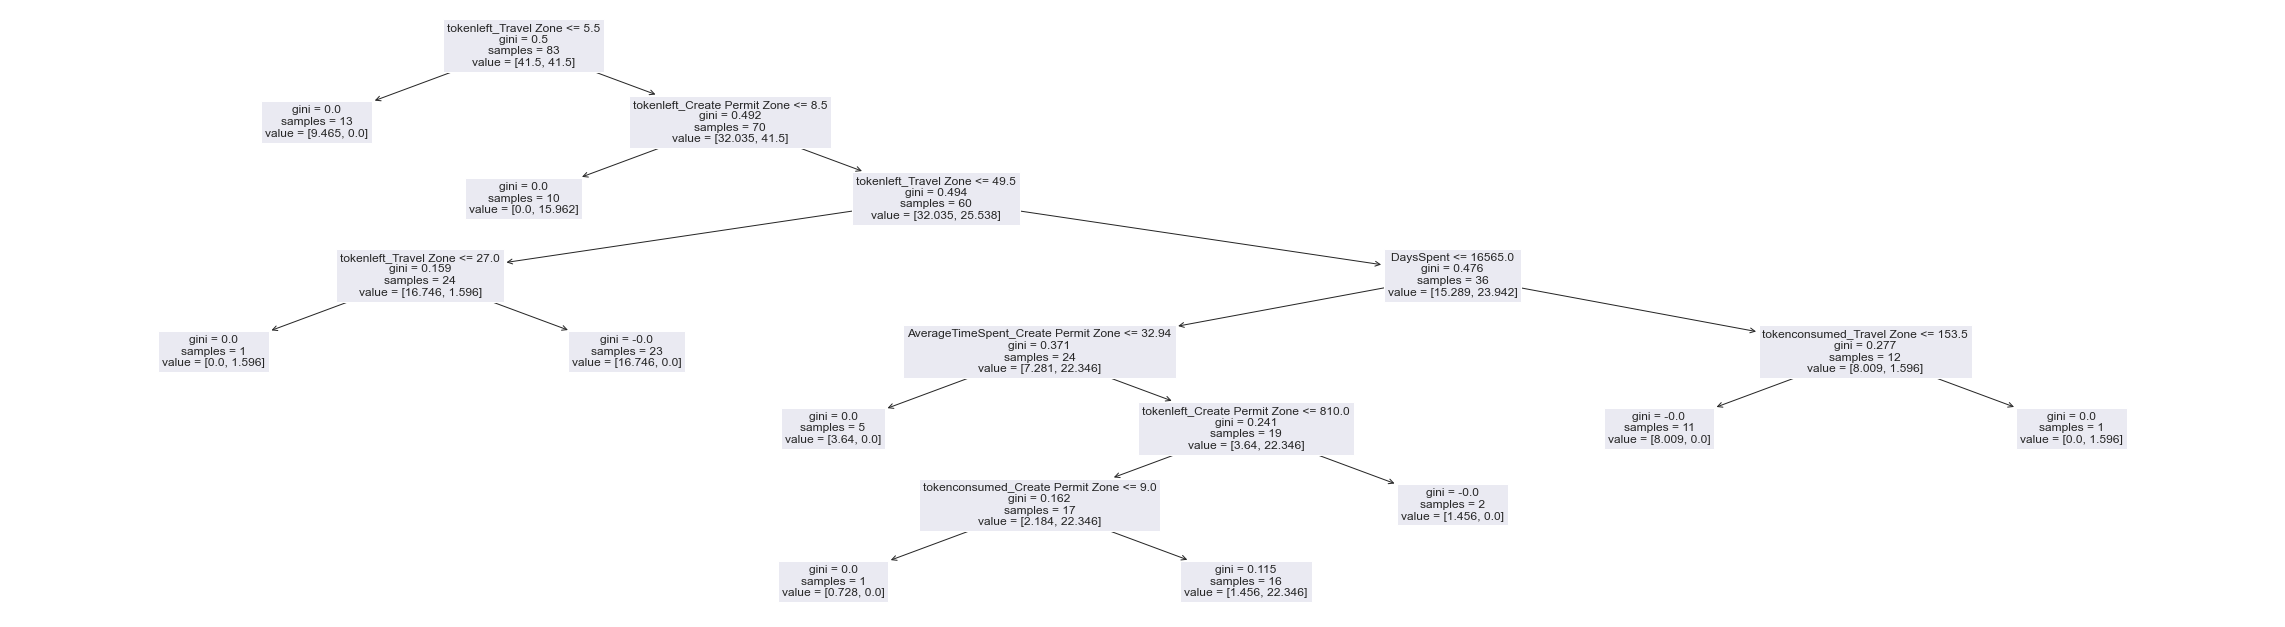

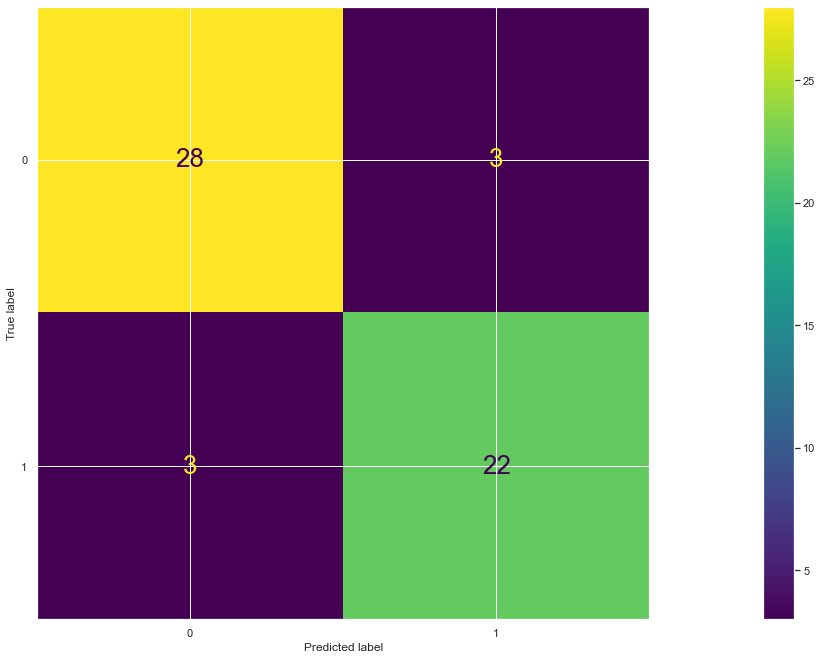

feature- Strange_tokenleft :  Day : 1
Mean ROC AUC: 0.708
feature- Strange_tokenleft :  Day : 2
Mean ROC AUC: 0.658
feature- Strange_tokenleft :  Day : 3
Mean ROC AUC: 0.560
feature- Strange_tokenleft :  Day : 4
Mean ROC AUC: 0.609
feature- Strange_tokenleft :  Day : 5
Mean ROC AUC: 0.612
feature- Strange_tokenleft :  Day : 6
Mean ROC AUC: 0.646
feature- Strange_tokenleft :  Day : 7
Mean ROC AUC: 0.556
feature- Strange_tokenleft :  Day : 8
Mean ROC AUC: 0.571
feature- Strange_tokenleft :  Day : 9
Mean ROC AUC: 0.576
feature- Strange_tokenleft :  Day : 10
Mean ROC AUC: 0.544
feature- Strange_tokenleft :  Day : 11
Mean ROC AUC: 0.632
feature- Strange_tokenleft :  Day : 12
Mean ROC AUC: 0.595
feature- Strange_tokenleft :  Day : 12
Mean absolute error LR- 0.25
Mean Squared error LR- 0.5
Accuracy: 0.75
F1: 0.7043740573152337
Precision: 0.7380952380952381
Recall: 0.6944444444444444


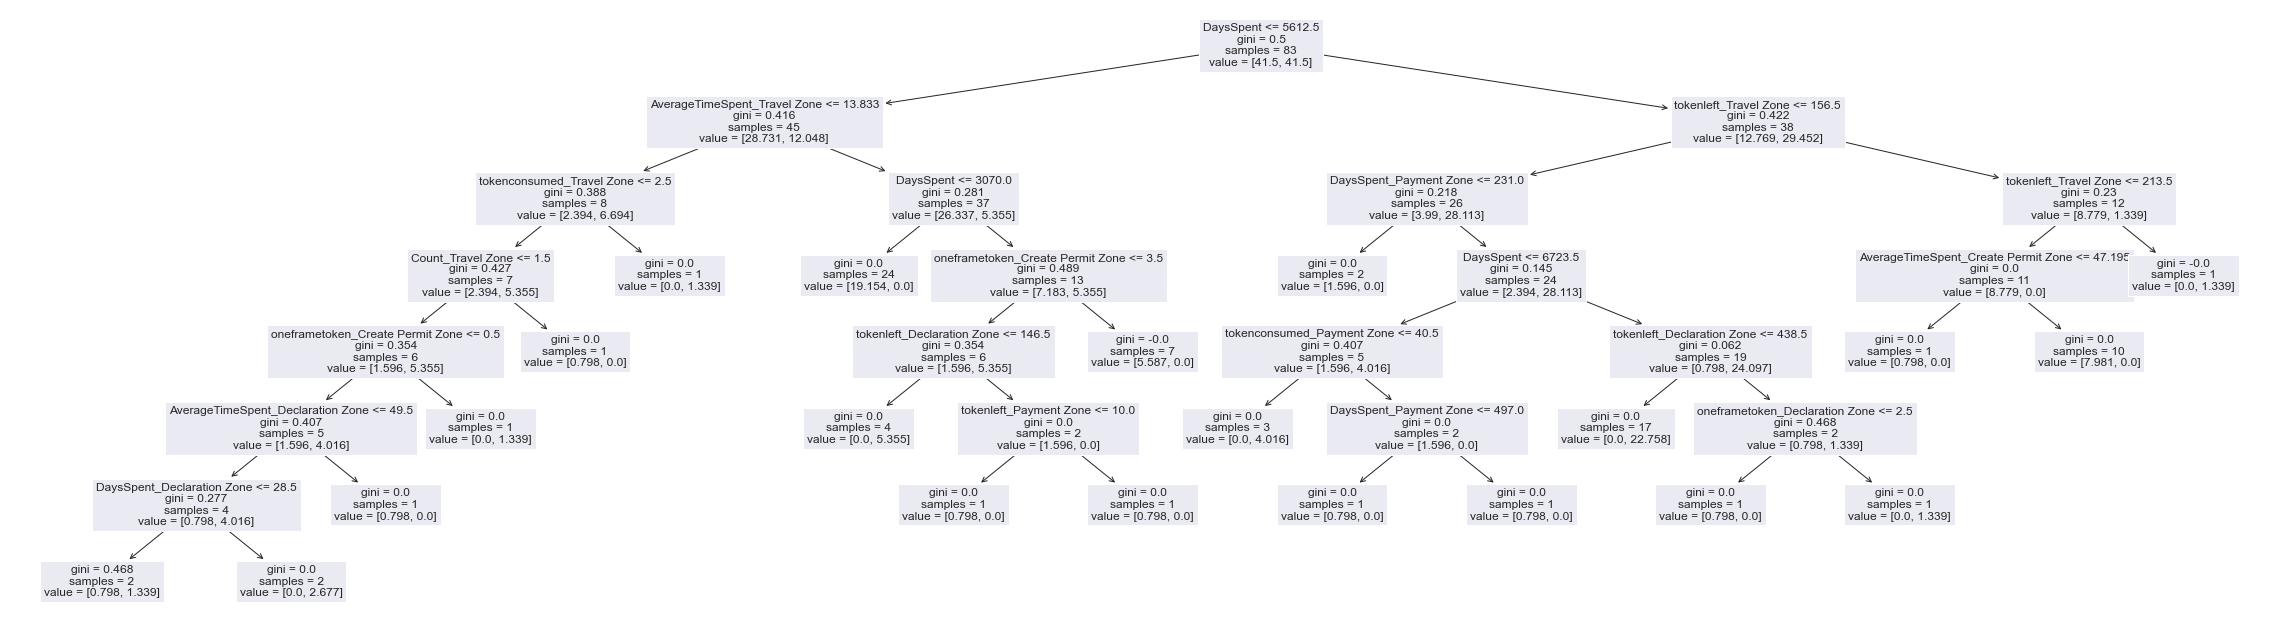

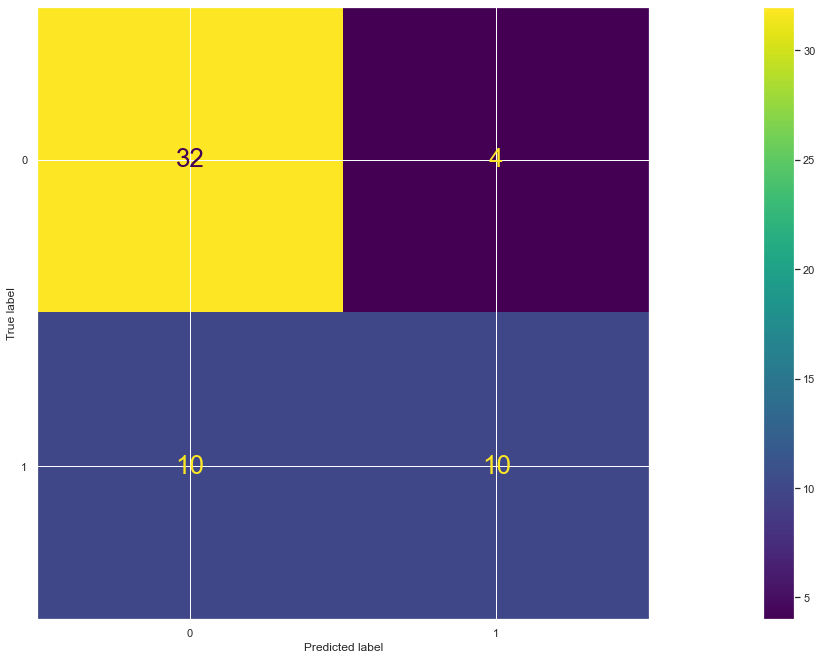

feature- Strange_tokenleft :  Day : 13
Mean ROC AUC: 0.616
feature- Strange_tokenleft :  Day : 13
Mean absolute error LR- 0.19642857142857142
Mean Squared error LR- 0.44320263021395917
Accuracy: 0.8035714285714286
F1: 0.7637130801687764
Precision: 0.78130081300813
Recall: 0.7529239766081872


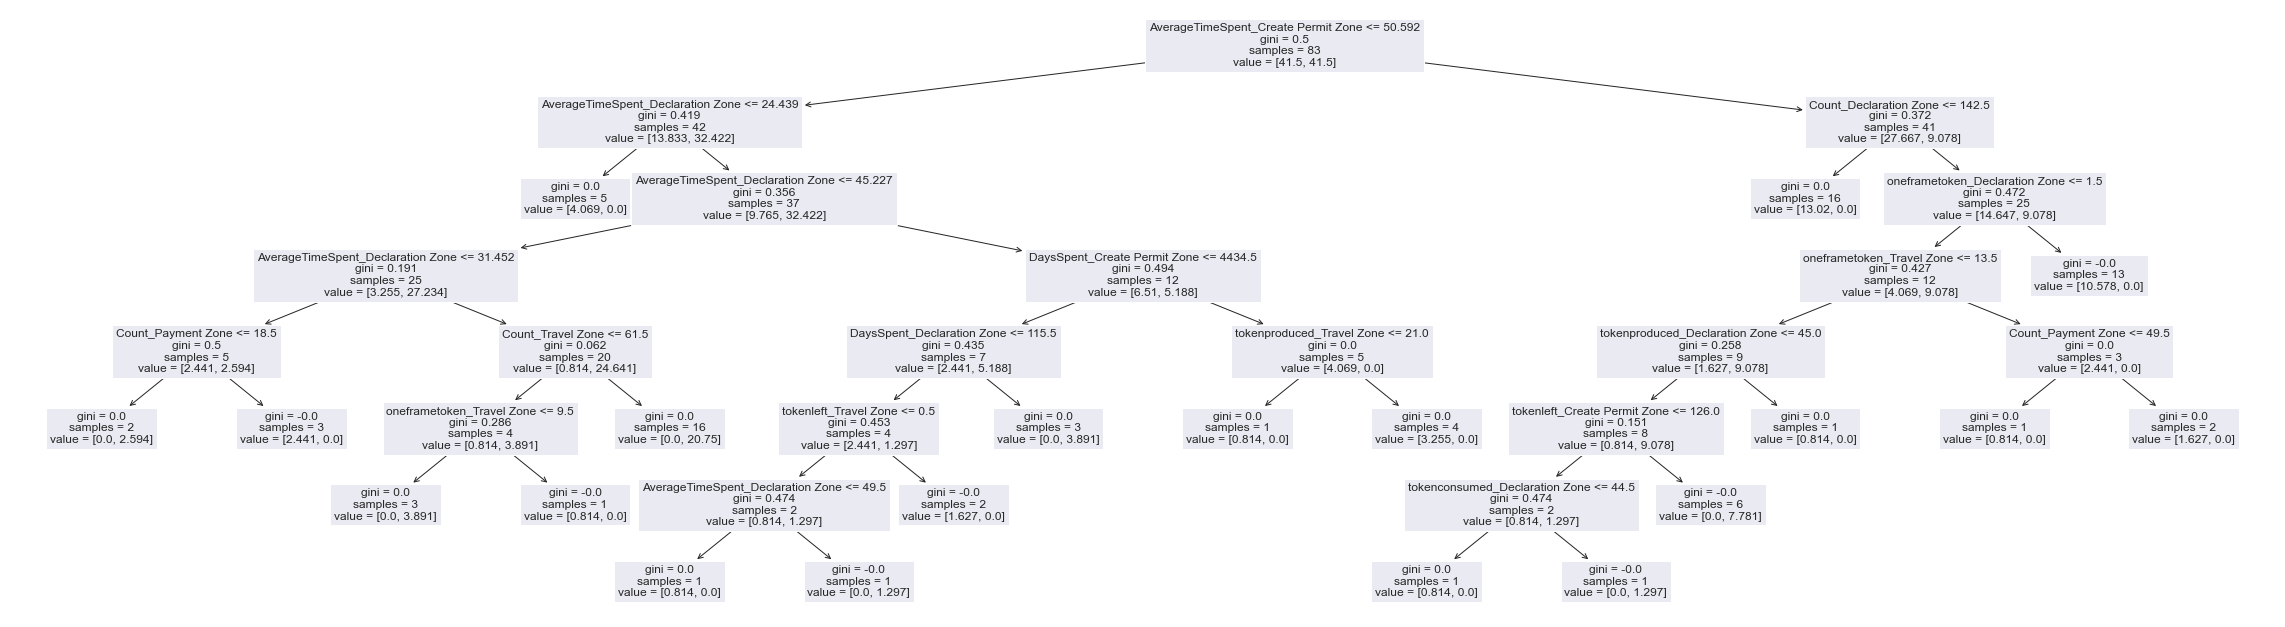

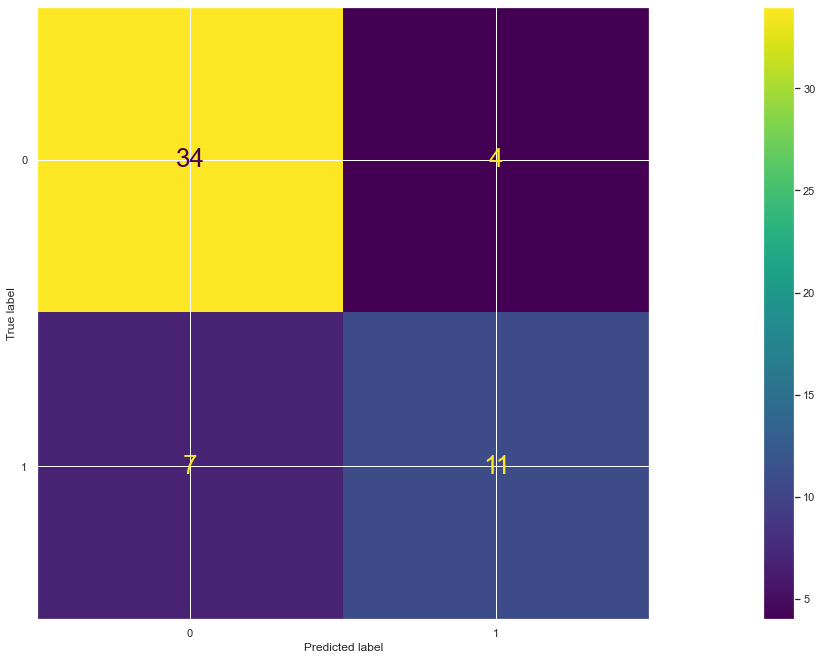

feature- Strange_tokenleft :  Day : 14
Mean ROC AUC: 0.629
feature- Strange_tokenleft :  Day : 15
Mean ROC AUC: 0.644
feature- Strange_tokenleft :  Day : 16
Mean ROC AUC: 0.610
feature- Strange_tokenleft :  Day : 16
Mean absolute error LR- 0.26785714285714285
Mean Squared error LR- 0.5175491695067657
Accuracy: 0.7321428571428571
F1: 0.7213930348258707
Precision: 0.71875
Recall: 0.7285714285714286


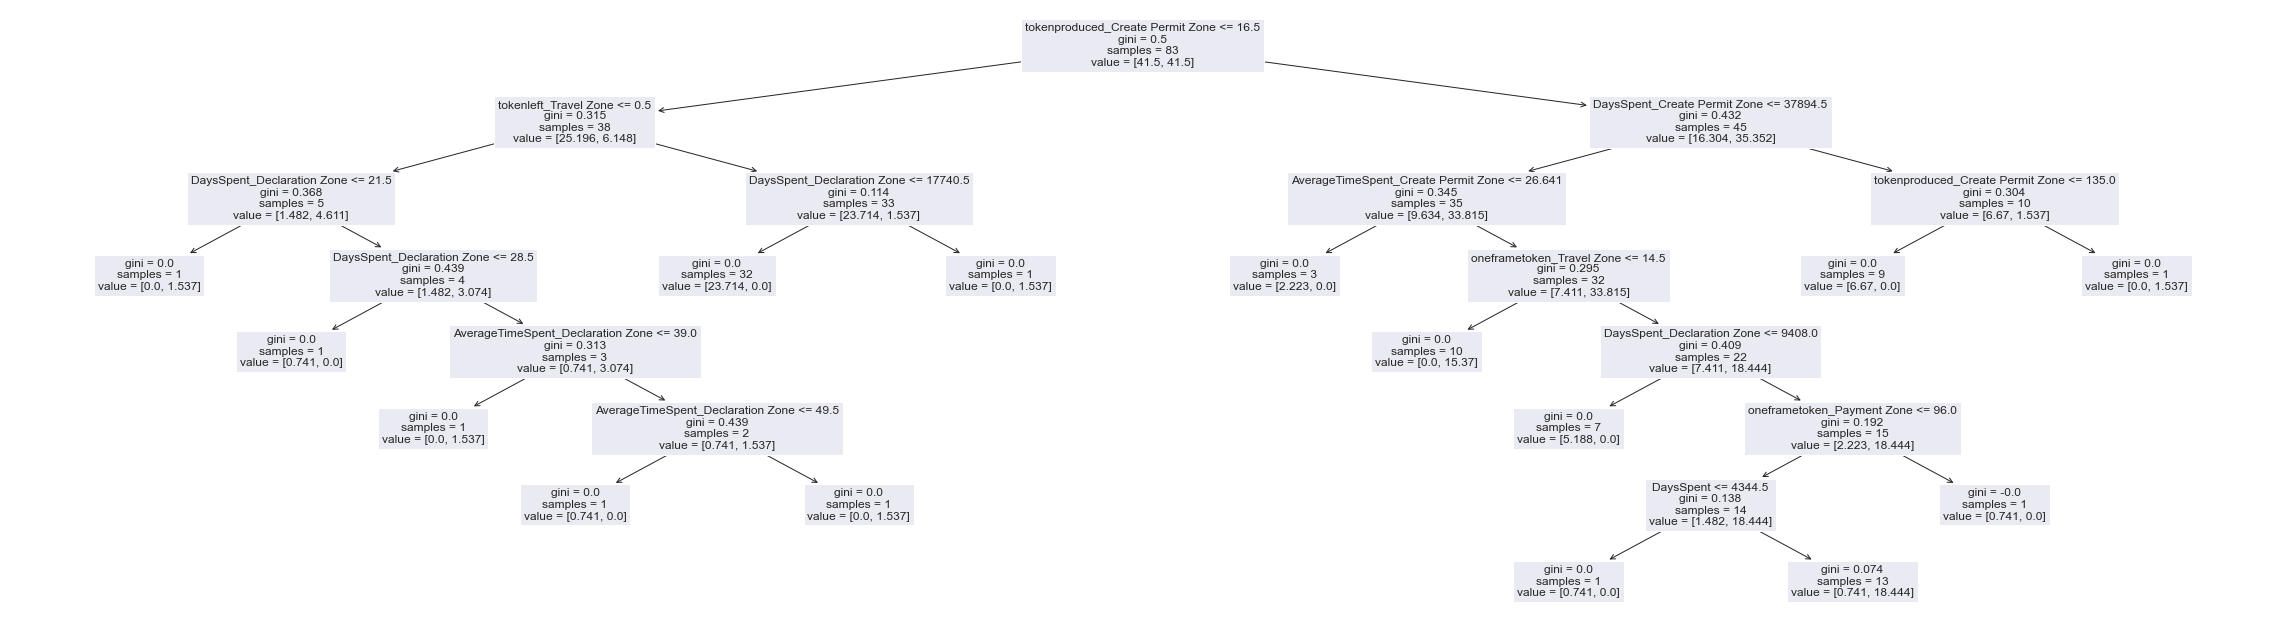

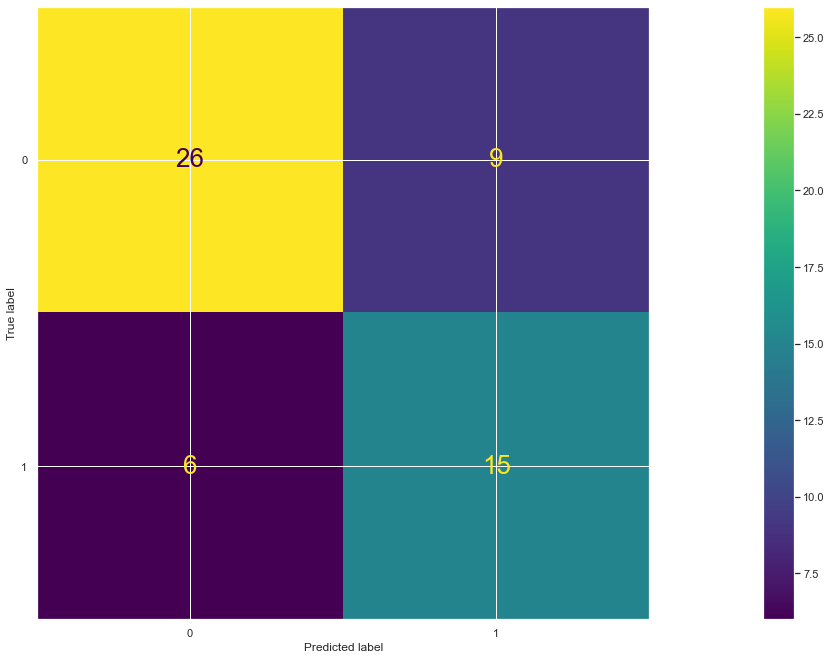

feature- Strange_tokenleft :  Day : 17
Mean ROC AUC: 0.584
feature- Strange_tokenleft :  Day : 18
Mean ROC AUC: 0.578
feature- Strange_tokenleft :  Day : 19
Mean ROC AUC: 0.616
feature- Strange_tokenleft :  Day : 20
Mean ROC AUC: 0.592
feature- Strange_tokenleft :  Day : 21
Mean ROC AUC: 0.601
feature- Strange_tokenleft :  Day : 22
Mean ROC AUC: 0.618
feature- Strange_tokenleft :  Day : 23
Mean ROC AUC: 0.618
feature- Strange_tokenleft :  Day : 24
Mean ROC AUC: 0.637
feature- Strange_tokenleft :  Day : 25
Mean ROC AUC: 0.611
feature- Strange_tokenleft :  Day : 26
Mean ROC AUC: 0.614
feature- Strange_tokenleft :  Day : 27
Mean ROC AUC: 0.729
feature- Strange_tokenleft :  Day : 28
Mean ROC AUC: 0.611
feature- Strange_tokenleft :  Day : 29
Mean ROC AUC: 0.672
feature- Strange_tokenleft :  Day : 30
Mean ROC AUC: 0.599
feature- Strange_tokenleft :  Day : 31
Mean ROC AUC: 0.743
feature- Strange_tokenleft :  Day : 31
Mean absolute error LR- 0.25
Mean Squared error LR- 0.5
Accuracy: 0.75
F1: 0

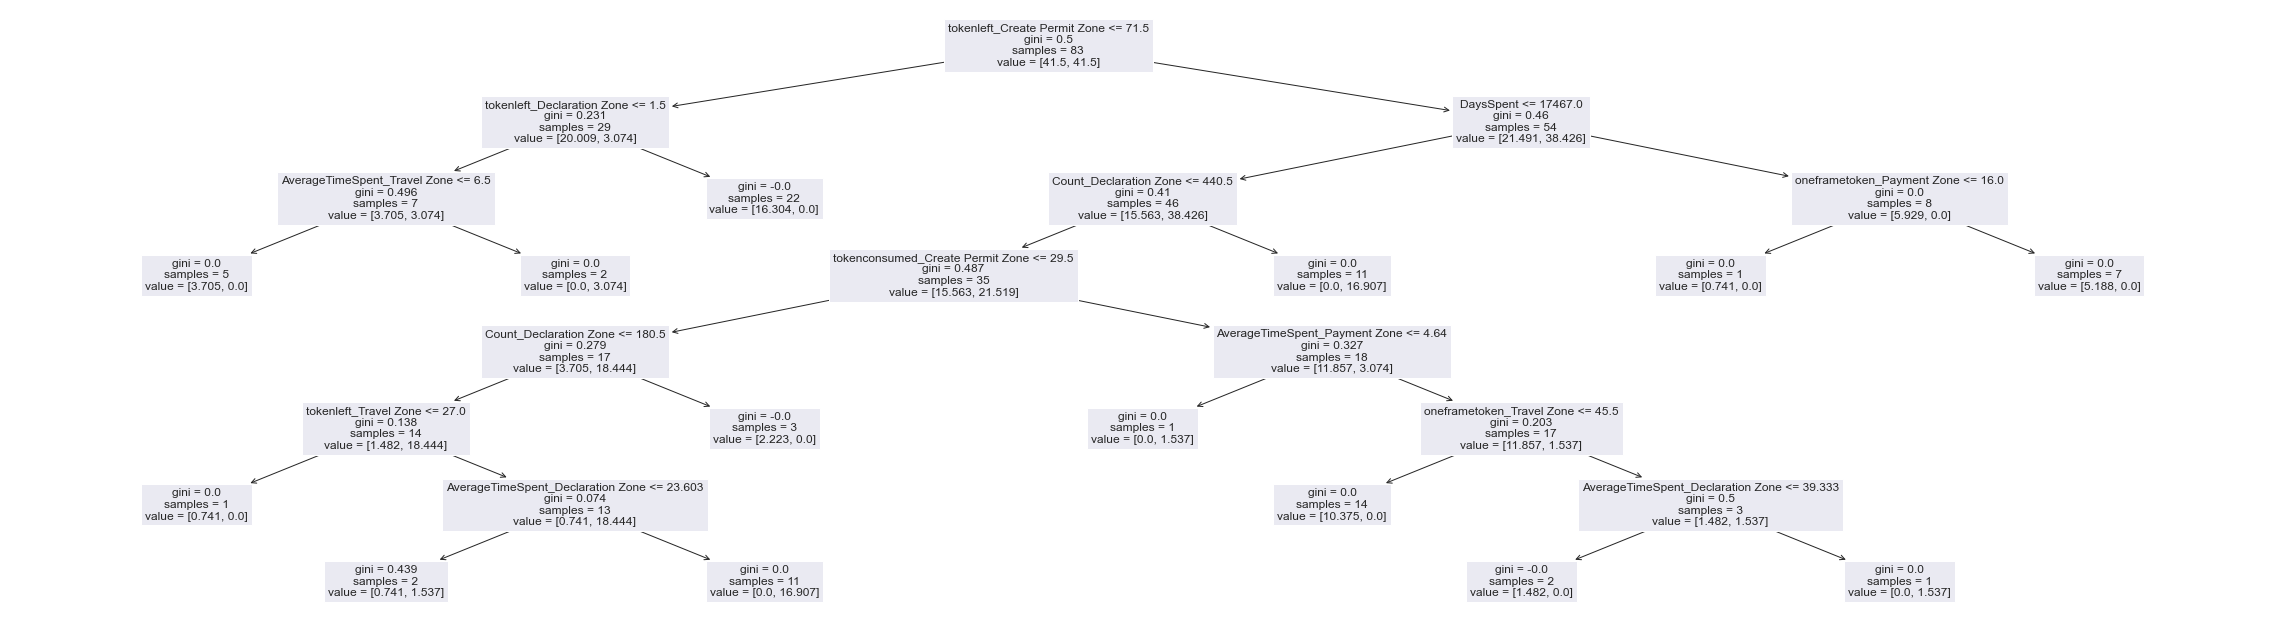

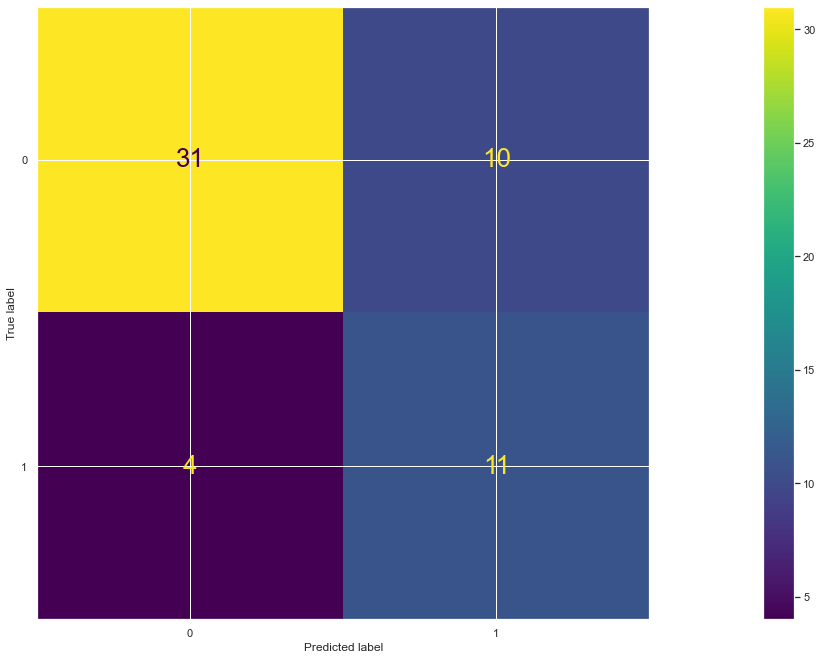

feature- Strange_tokenleft :  Day : 32
Mean ROC AUC: 0.660
feature- Strange_tokenleft :  Day : 33
Mean ROC AUC: 0.670
feature- Strange_tokenleft :  Day : 34
Mean ROC AUC: 0.706
feature- Strange_tokenleft :  Day : 35
Mean ROC AUC: 0.648
feature- Strange_tokenleft :  Day : 36
Mean ROC AUC: 0.671
feature- Strange_tokenleft :  Day : 37
Mean ROC AUC: 0.694
feature- Strange_tokenleft :  Day : 38
Mean ROC AUC: 0.660
feature- Strange_tokenleft :  Day : 39
Mean ROC AUC: 0.601
feature- Strange_tokenleft :  Day : 40
Mean ROC AUC: 0.641
feature- Strange_tokenleft :  Day : 41
Mean ROC AUC: 0.703
feature- Strange_tokenleft :  Day : 41
Mean absolute error LR- 0.16071428571428573
Mean Squared error LR- 0.4008918628686366
Accuracy: 0.8392857142857143
F1: 0.7992831541218638
Precision: 0.79375
Recall: 0.8056910569105691


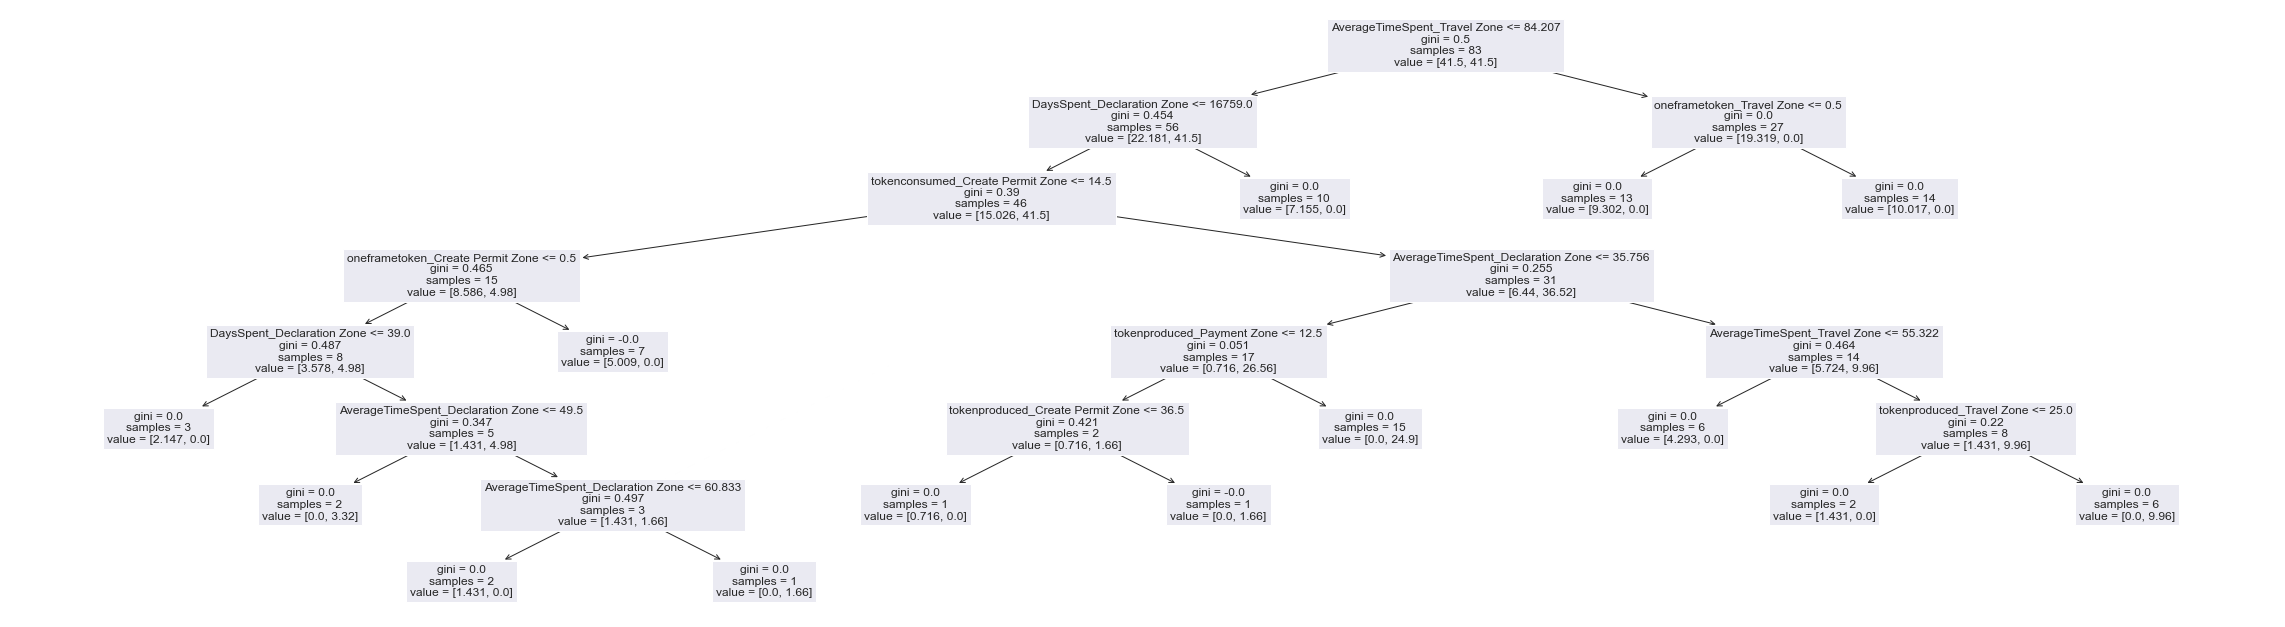

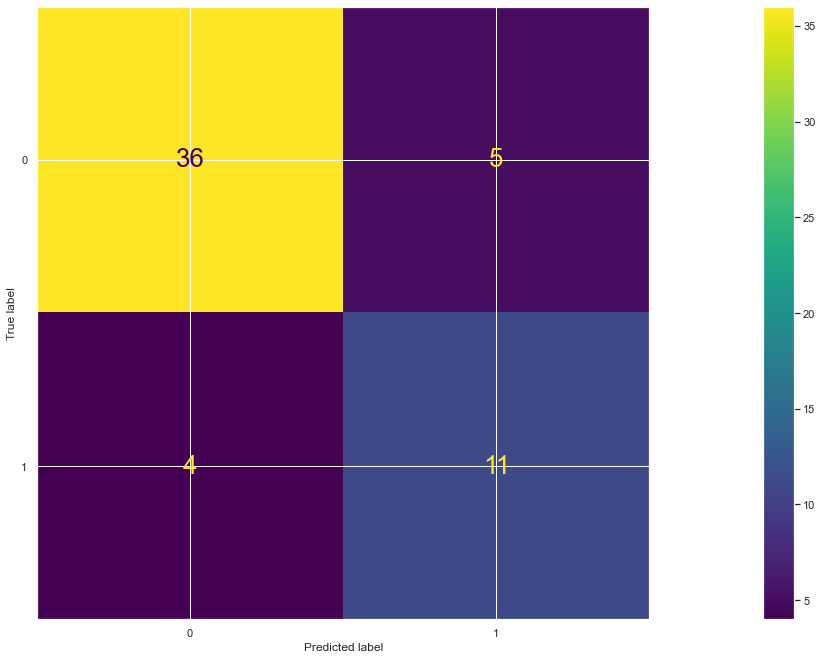

feature- Strange_tokenleft :  Day : 42
Mean ROC AUC: 0.708
feature- Strange_tokenleft :  Day : 43
Mean ROC AUC: 0.681
feature- Strange_tokenleft :  Day : 44
Mean ROC AUC: 0.591
feature- Strange_tokenleft :  Day : 45
Mean ROC AUC: 0.633
feature- Strange_tokenleft :  Day : 46
Mean ROC AUC: 0.674
feature- Strange_tokenleft :  Day : 47
Mean ROC AUC: 0.632
feature- Strange_tokenleft :  Day : 48
Mean ROC AUC: 0.658
feature- Strange_tokenleft :  Day : 49
Mean ROC AUC: 0.663
feature- Strange_oneframetoken :  Day : 0
Mean ROC AUC: 0.663
feature- Strange_oneframetoken :  Day : 0
Mean absolute error LR- 0.16666666666666666
Mean Squared error LR- 0.408248290463863
Accuracy: 0.8333333333333334
F1: 0.7339901477832512
Precision: 0.7037037037037037
Recall: 0.8193548387096774


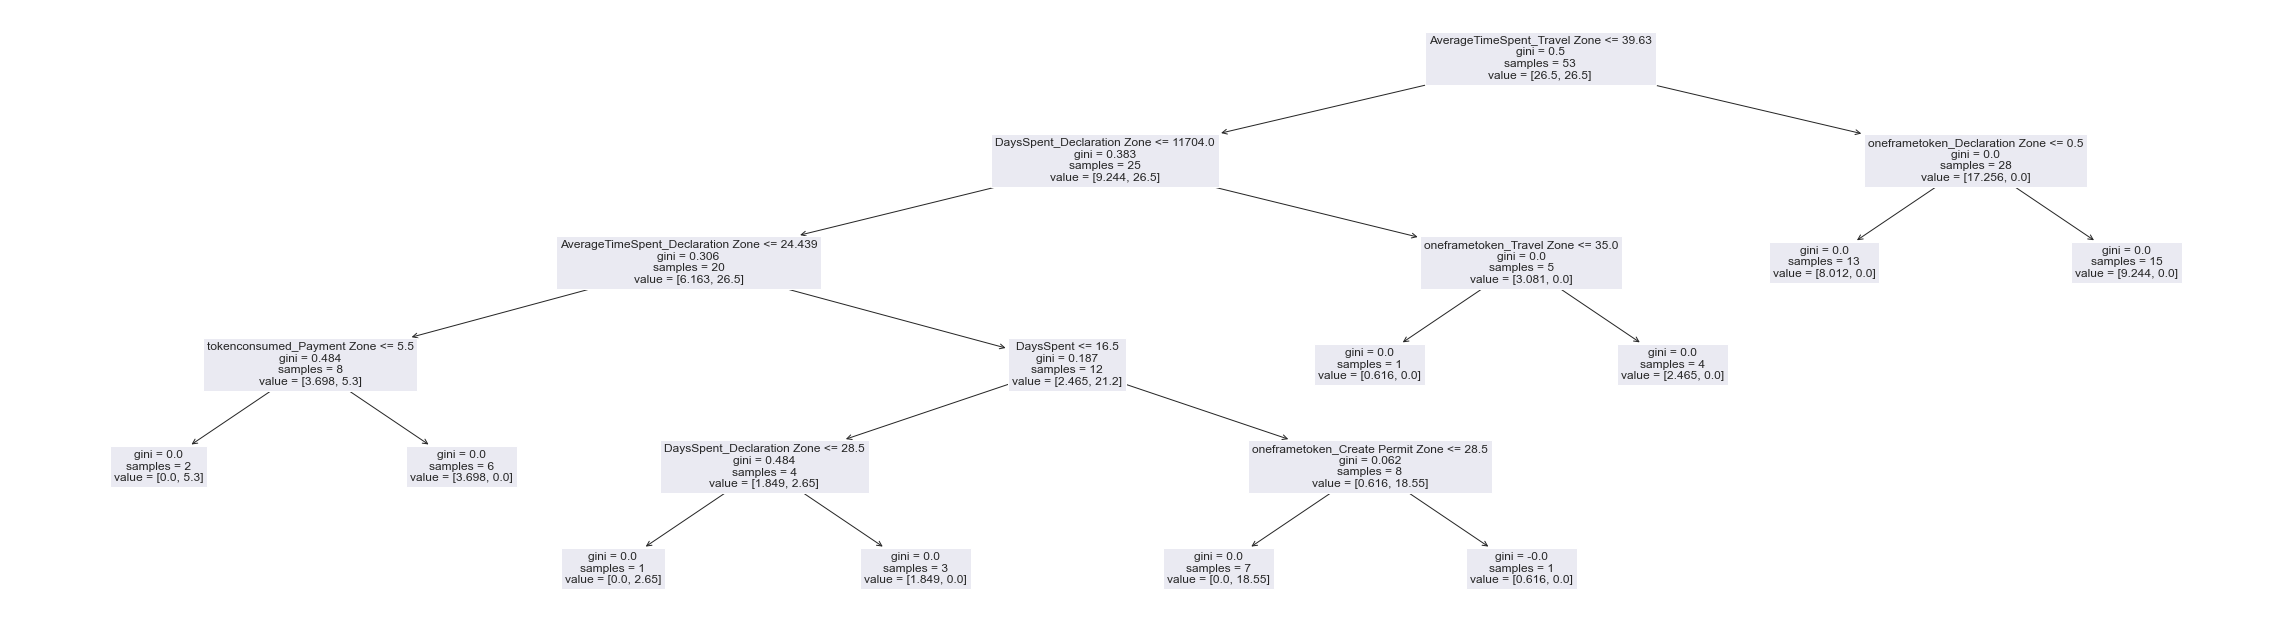

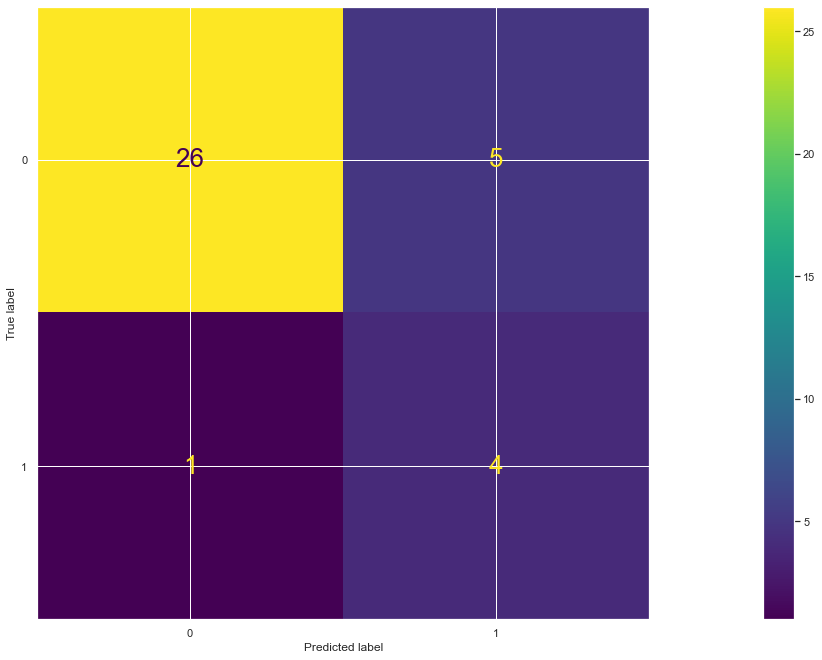

feature- Strange_oneframetoken :  Day : 1
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 1
Mean absolute error LR- 0.1111111111111111
Mean Squared error LR- 0.3333333333333333
Accuracy: 0.8888888888888888
F1: 0.8226600985221675
Precision: 0.8666666666666667
Recall: 0.7946428571428572


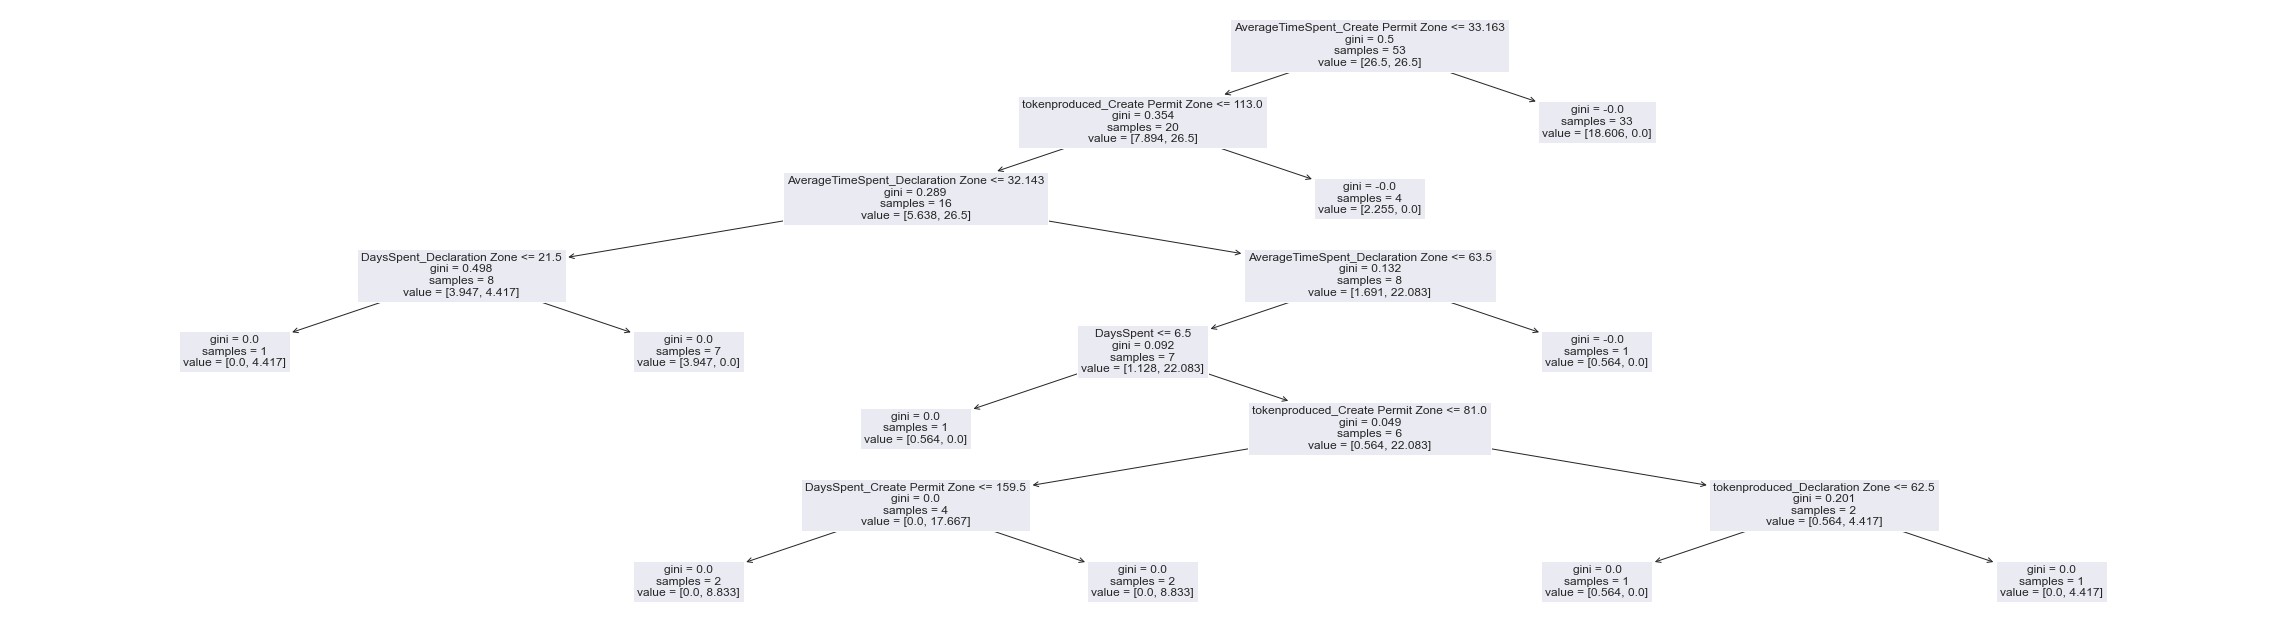

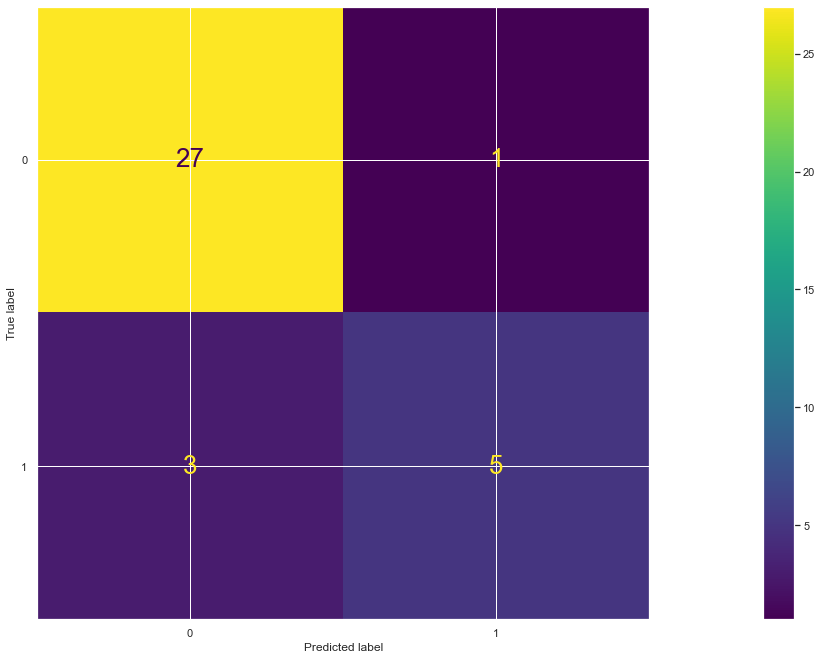

feature- Strange_oneframetoken :  Day : 2
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 3
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 4
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 4
Mean absolute error LR- 0.1388888888888889
Mean Squared error LR- 0.37267799624996495
Accuracy: 0.8611111111111112
F1: 0.7317436661698956
Precision: 0.8125
Recall: 0.6970443349753694


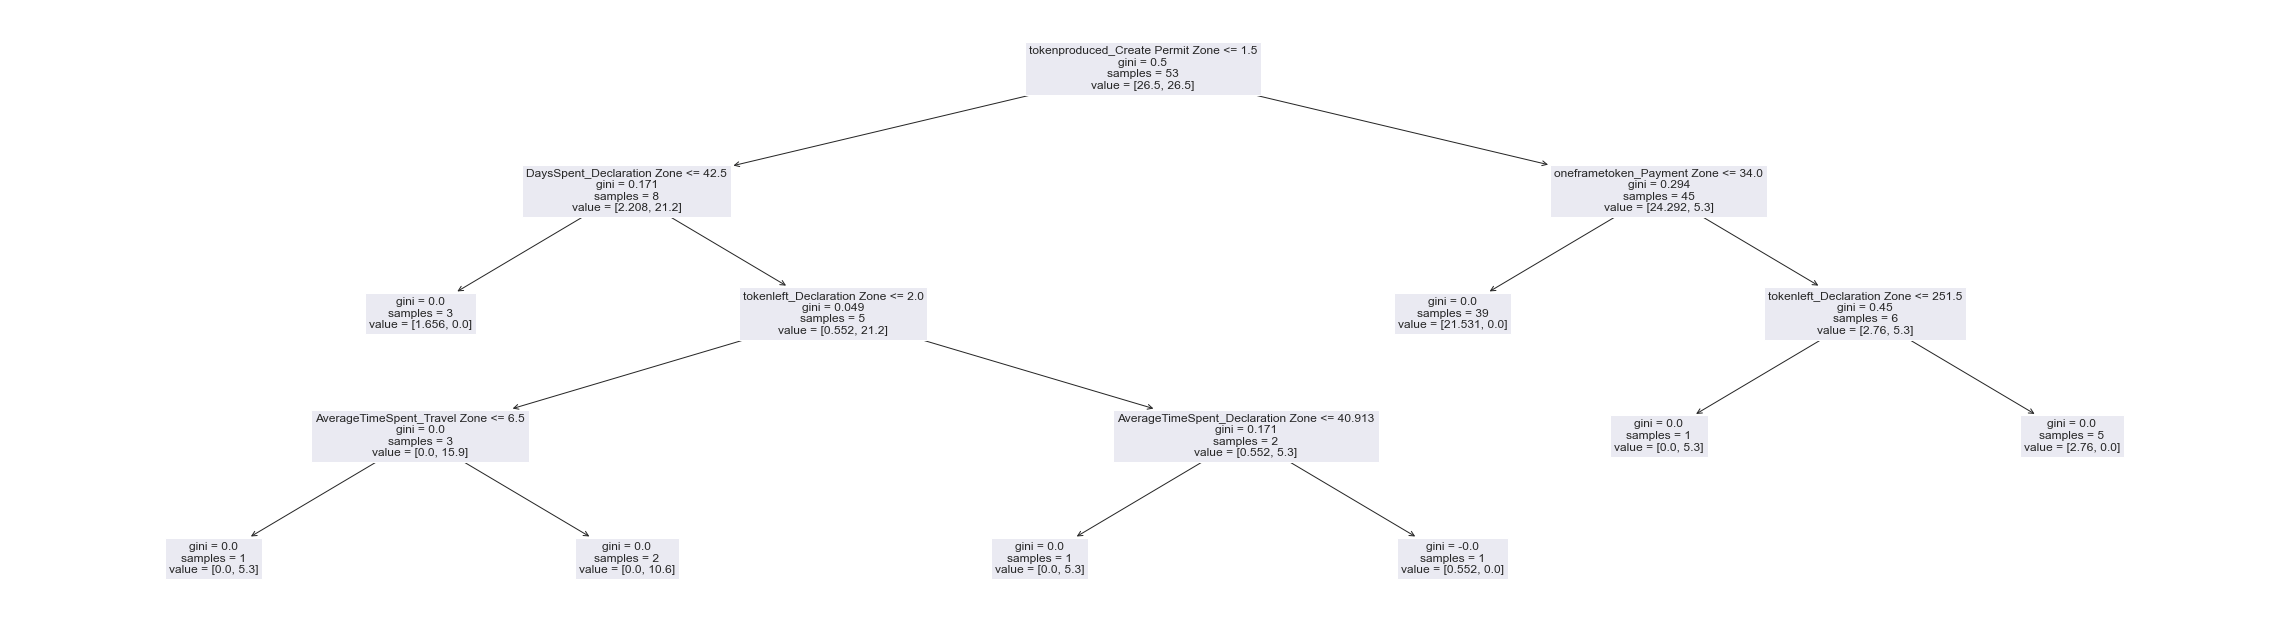

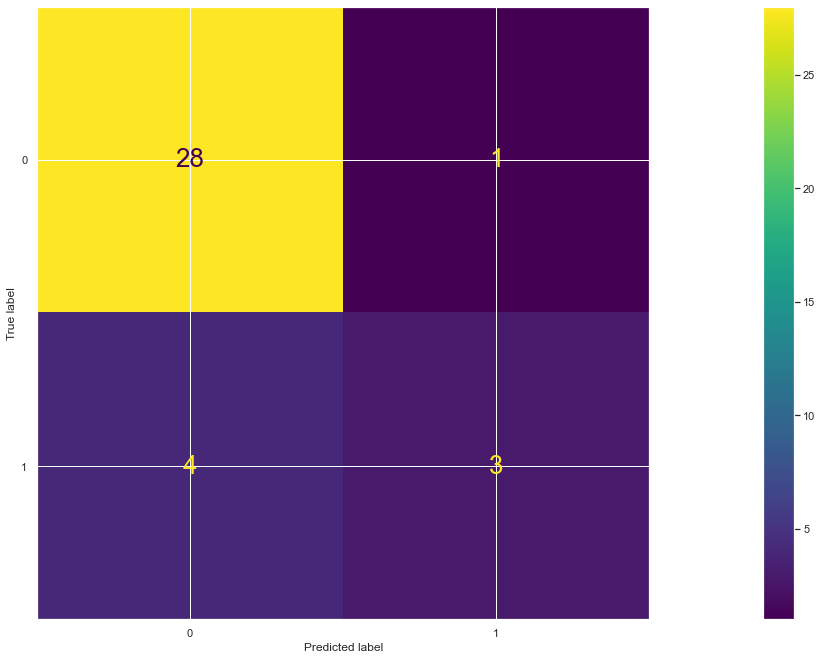

feature- Strange_oneframetoken :  Day : 5
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 5
Mean absolute error LR- 0.1388888888888889
Mean Squared error LR- 0.37267799624996495
Accuracy: 0.8611111111111112
F1: 0.7317436661698956
Precision: 0.6970443349753694
Recall: 0.8125


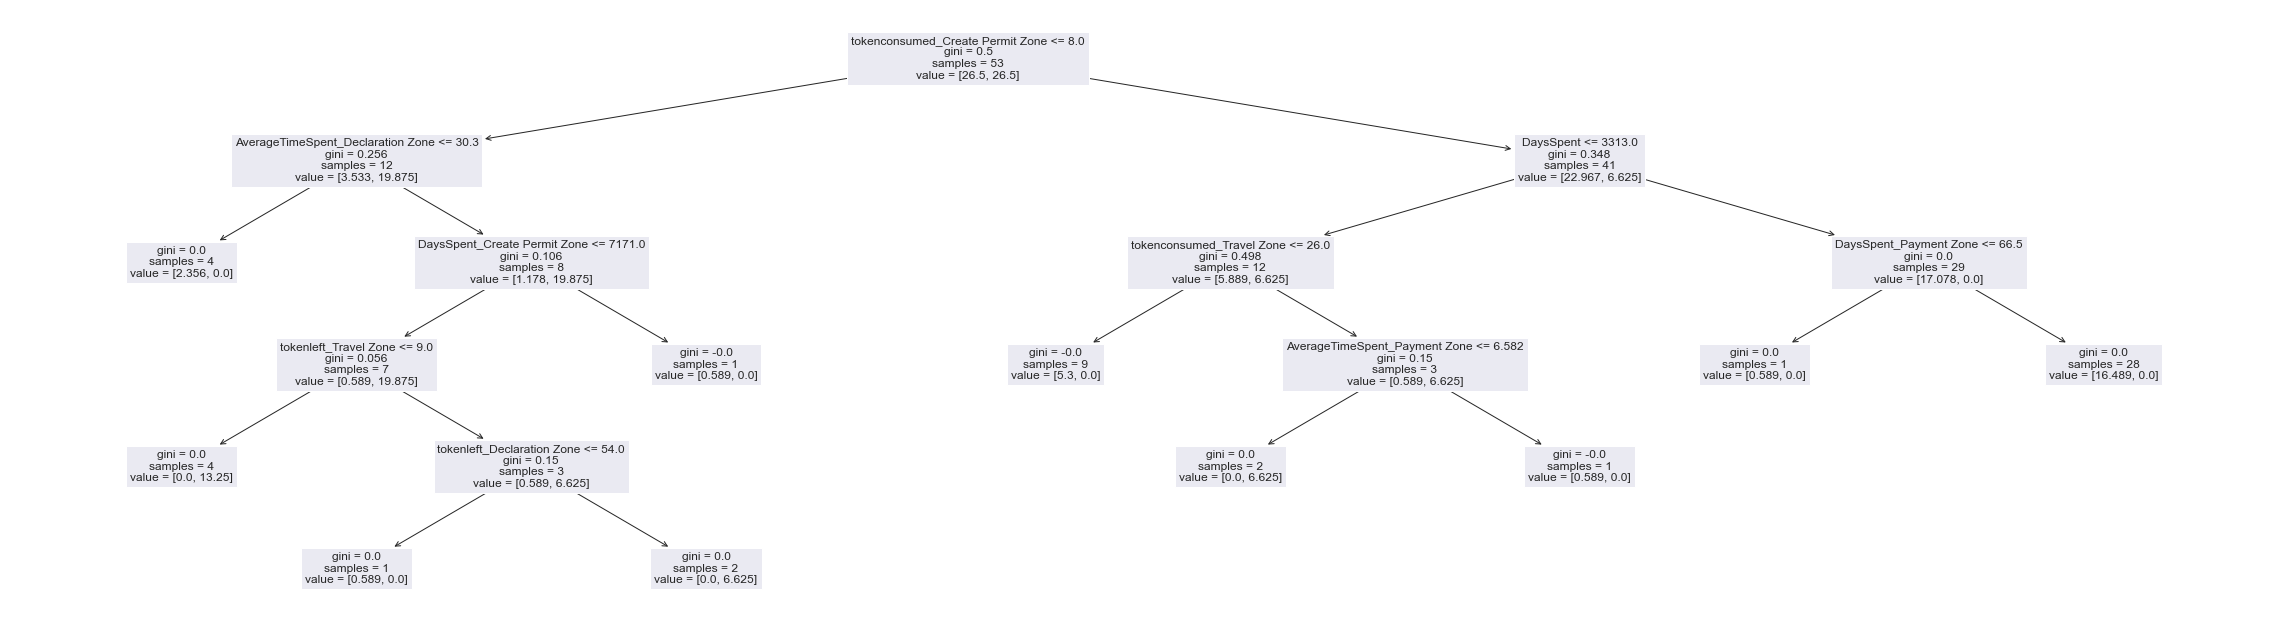

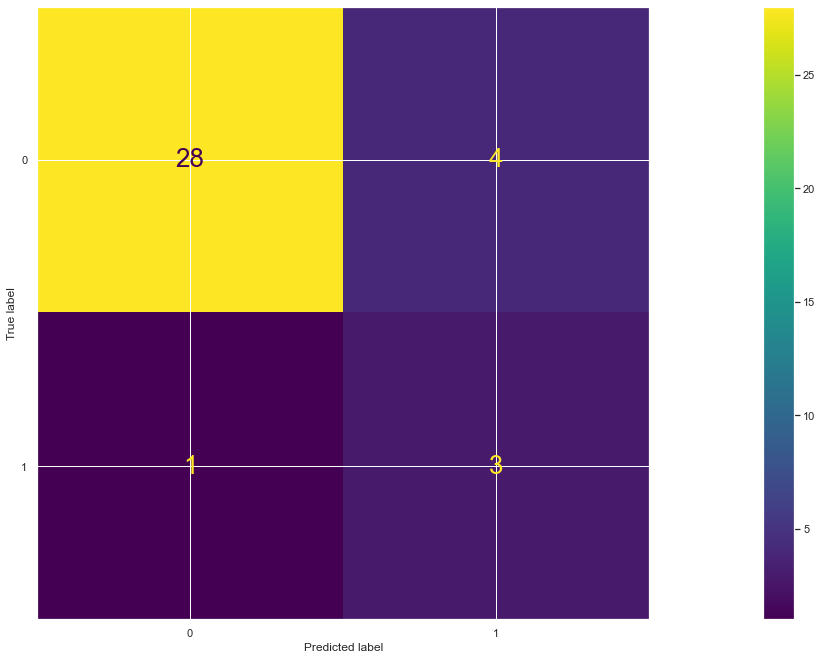

feature- Strange_oneframetoken :  Day : 6
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 6
Mean absolute error LR- 0.1111111111111111
Mean Squared error LR- 0.3333333333333333
Accuracy: 0.8888888888888888
F1: 0.71875
Precision: 0.71875
Recall: 0.71875


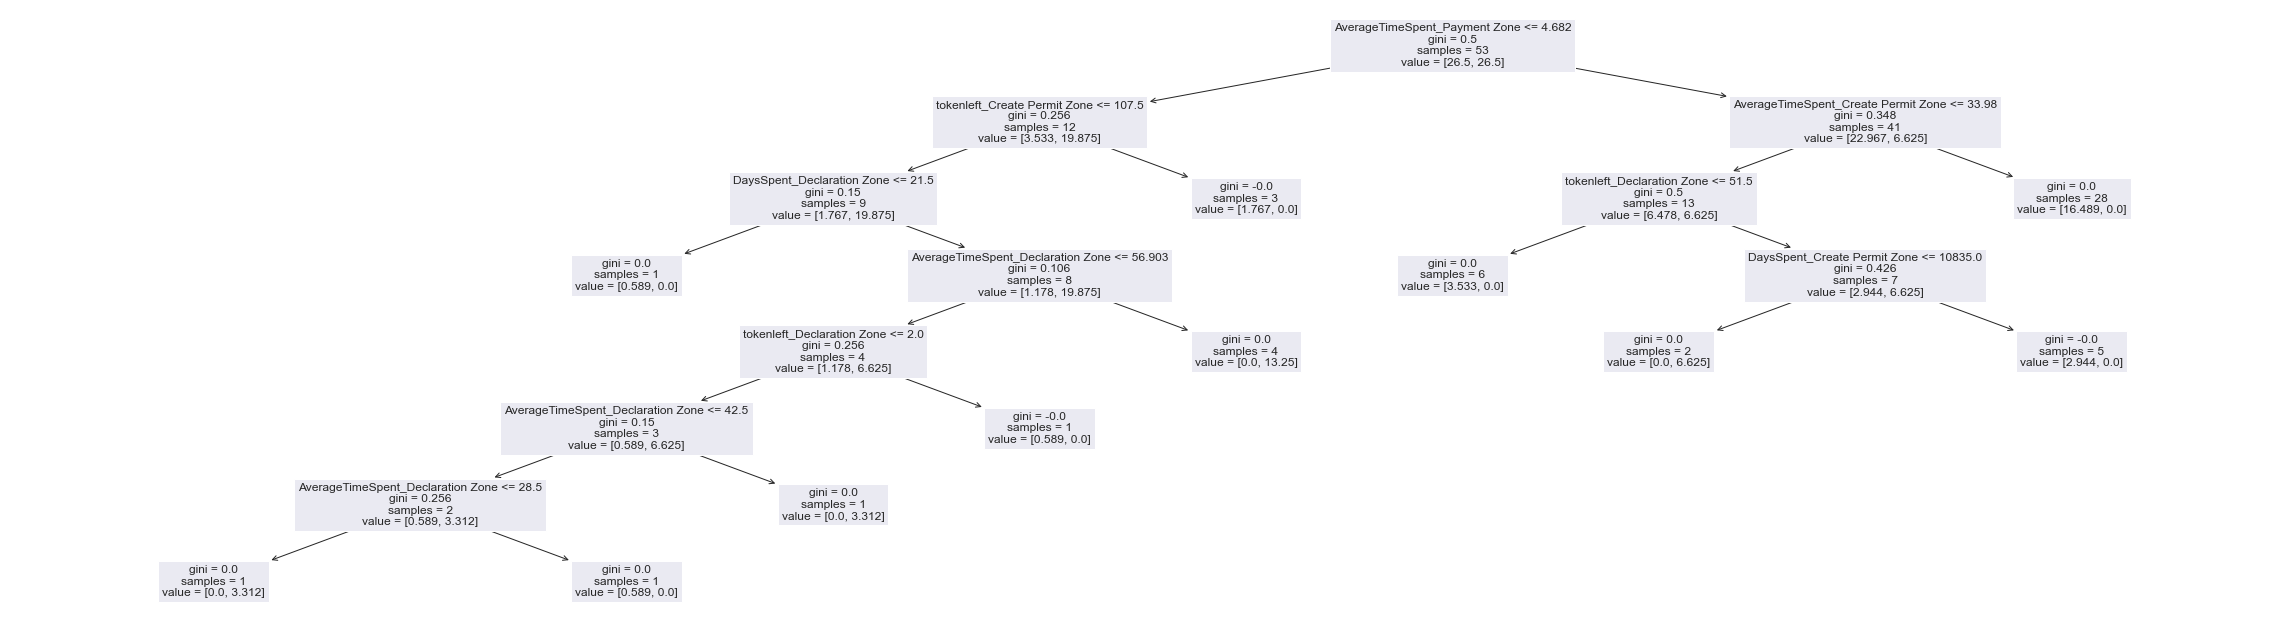

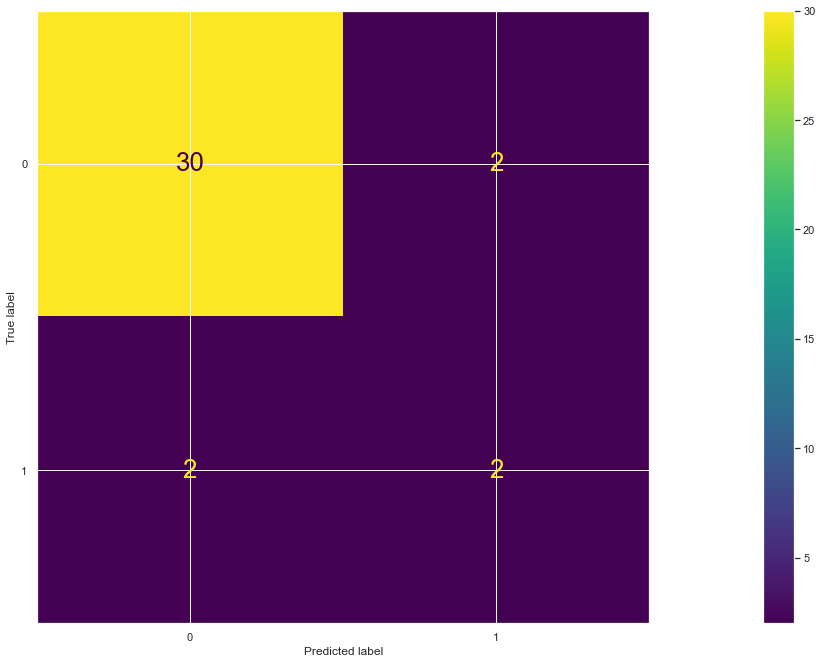

feature- Strange_oneframetoken :  Day : 7
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 8
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 8
Mean absolute error LR- 0.1111111111111111
Mean Squared error LR- 0.3333333333333333
Accuracy: 0.8888888888888888
F1: 0.7677419354838709
Precision: 0.7333333333333334
Recall: 0.828125


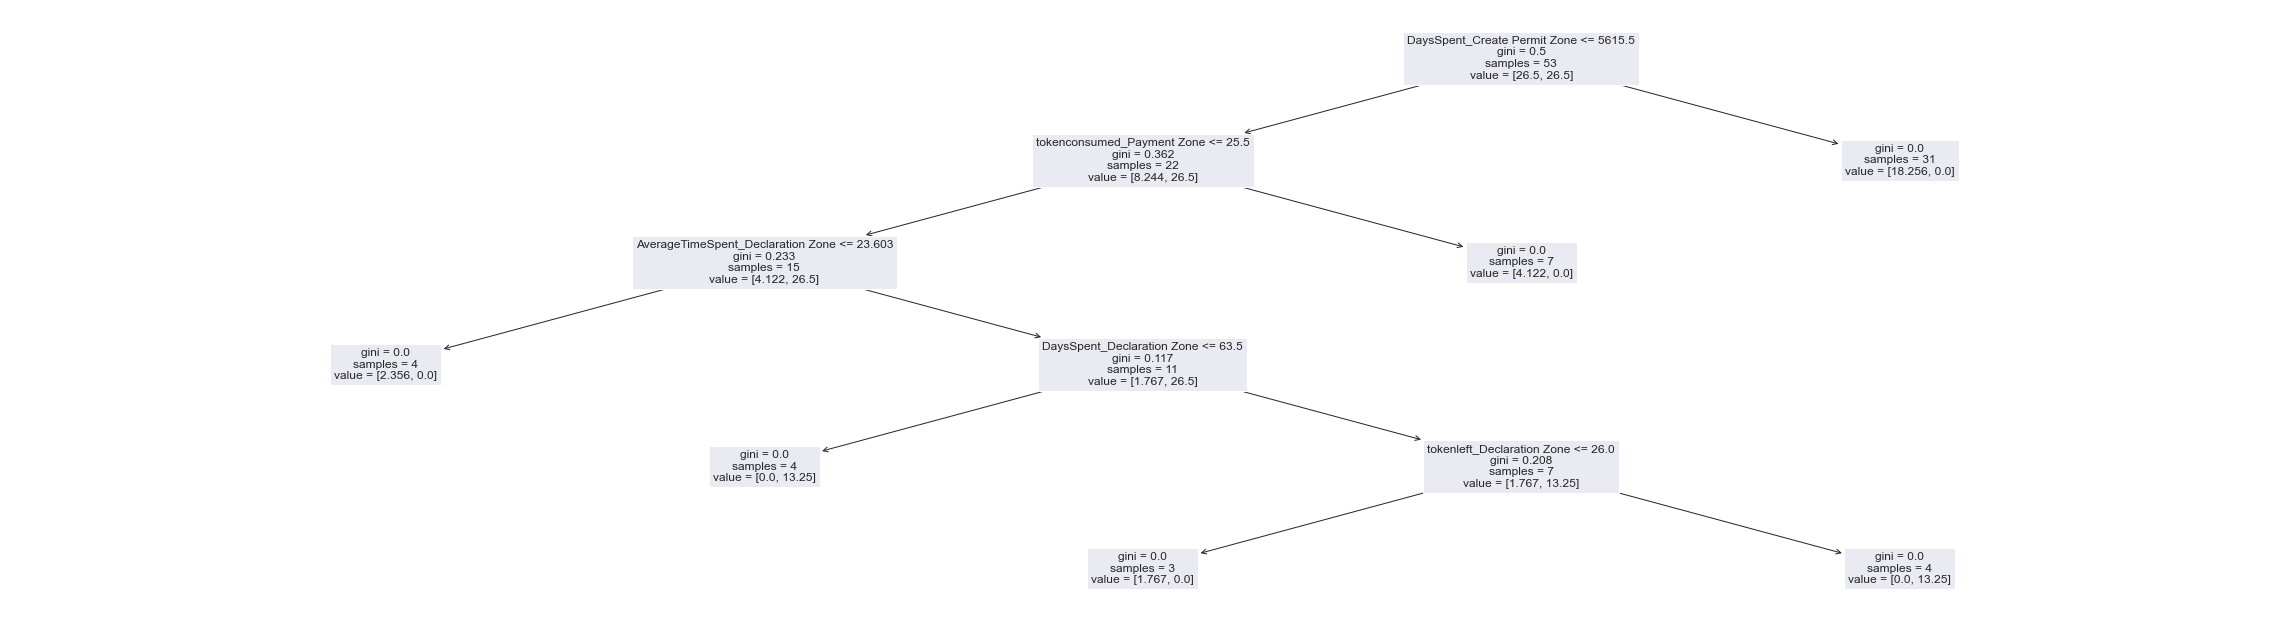

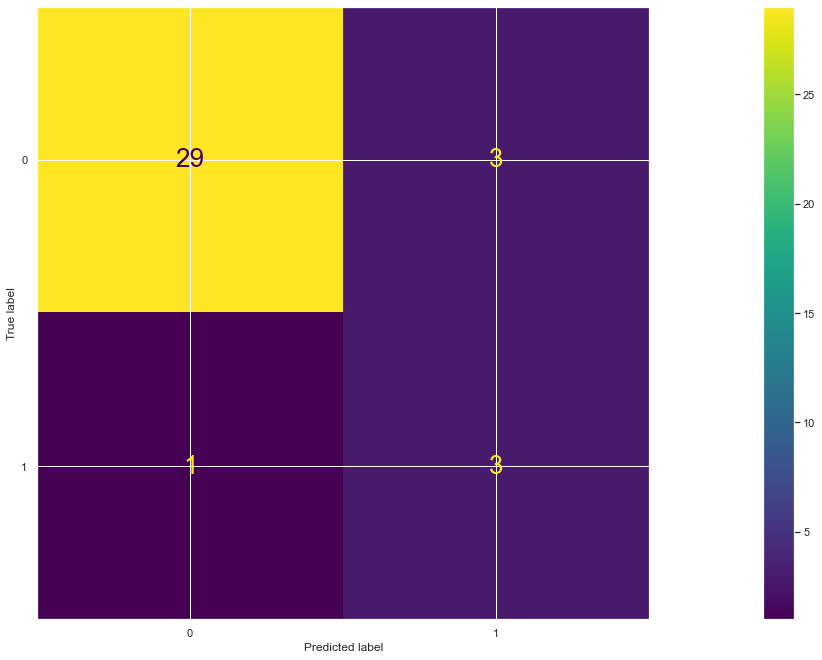

feature- Strange_oneframetoken :  Day : 9
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 10
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 10
Mean absolute error LR- 0.08333333333333333
Mean Squared error LR- 0.28867513459481287
Accuracy: 0.9166666666666666
F1: 0.7626373626373627
Precision: 0.803030303030303
Recall: 0.734375


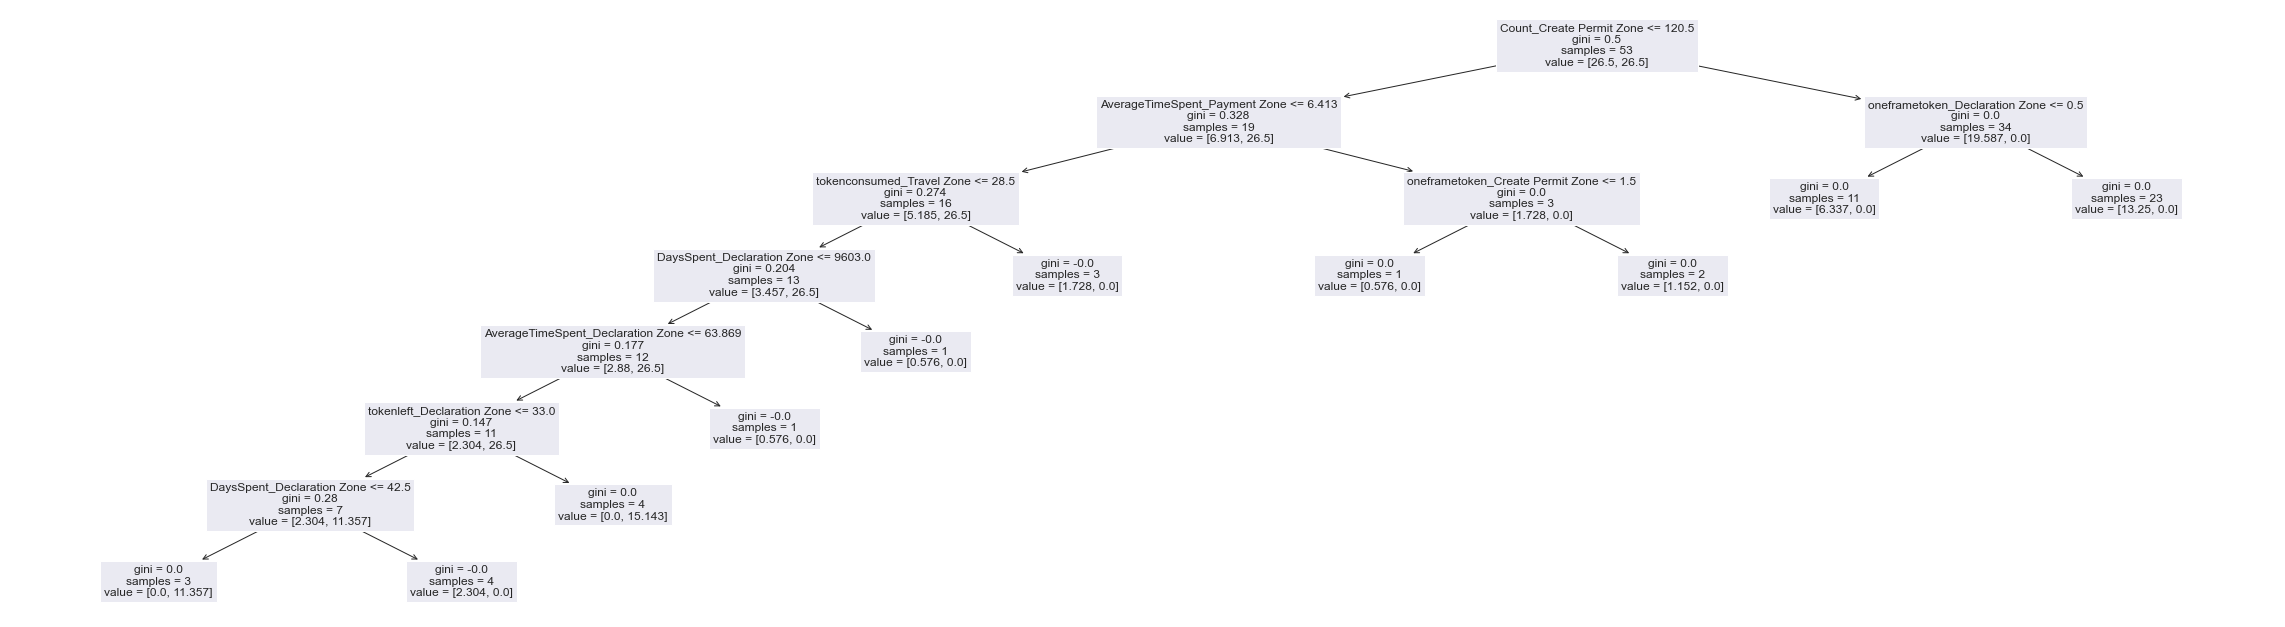

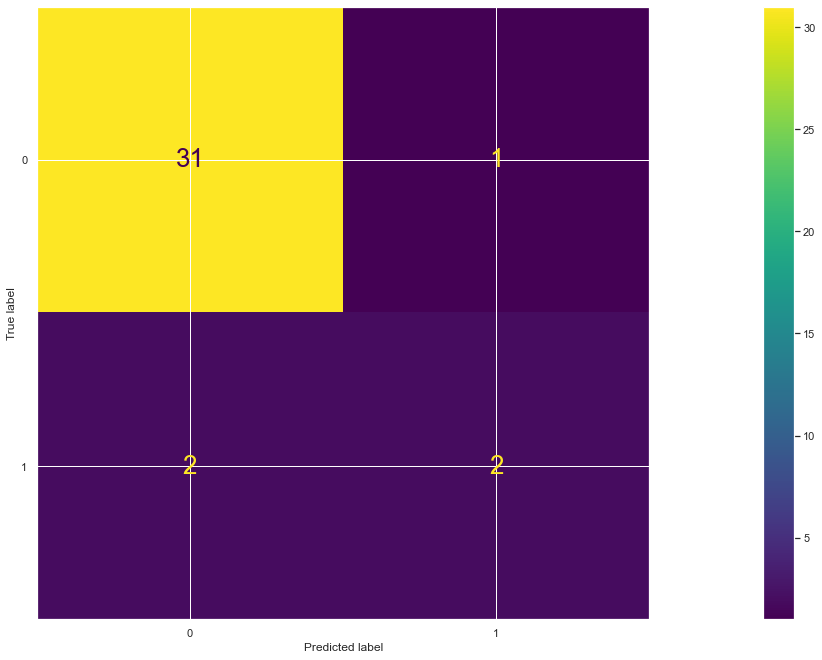

feature- Strange_oneframetoken :  Day : 11
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 11
Mean absolute error LR- 0.05555555555555555
Mean Squared error LR- 0.23570226039551584
Accuracy: 0.9444444444444444
F1: 0.8181818181818181
Precision: 0.8181818181818181
Recall: 0.8181818181818181


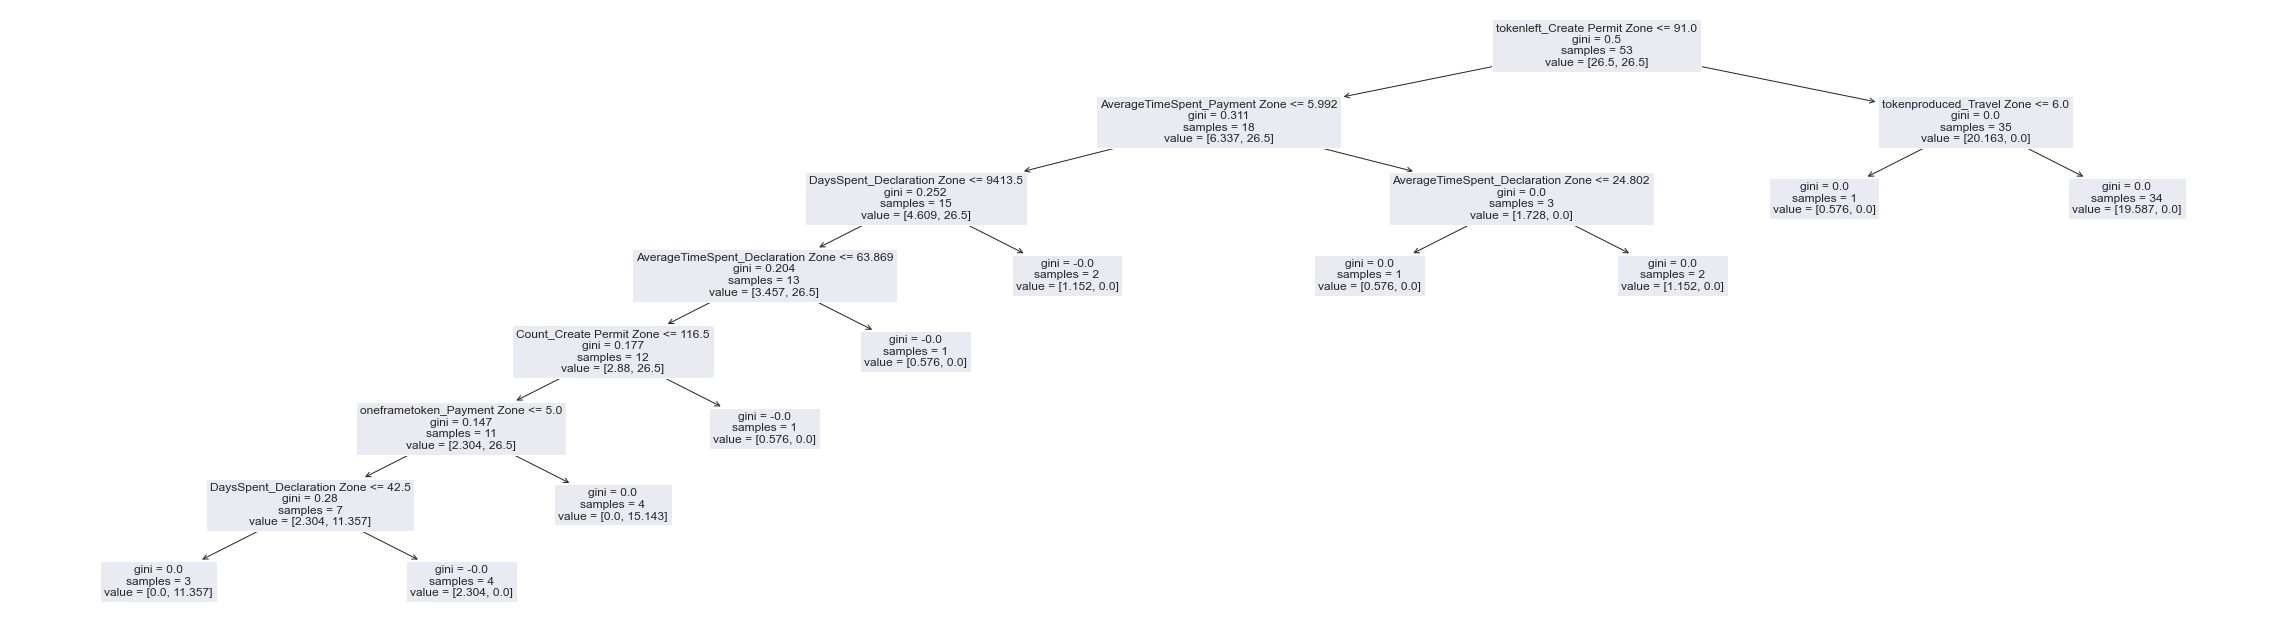

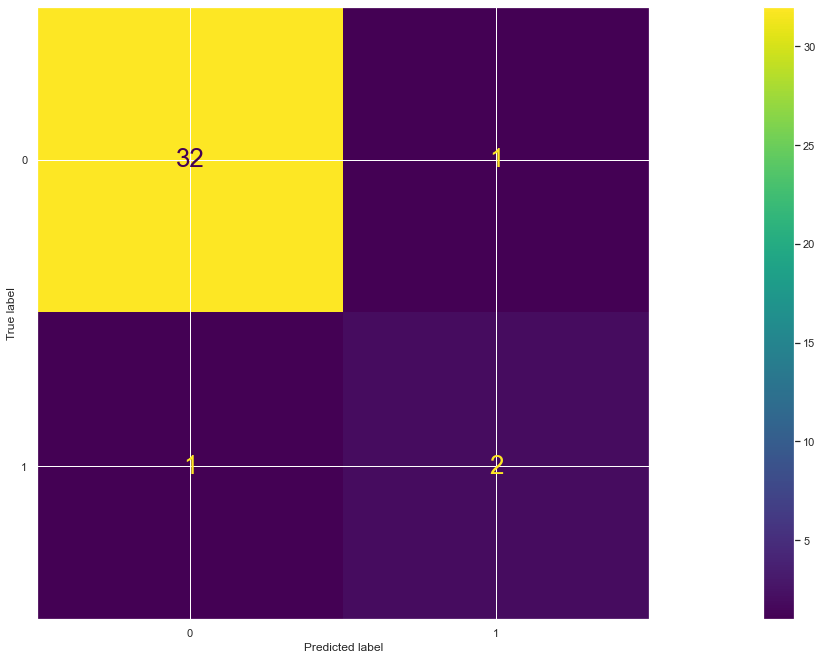

feature- Strange_oneframetoken :  Day : 12
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 13
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 14
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 14
Mean absolute error LR- 0.05555555555555555
Mean Squared error LR- 0.23570226039551584
Accuracy: 0.9444444444444444
F1: 0.7352941176470589
Precision: 0.6666666666666666
Recall: 0.9714285714285714


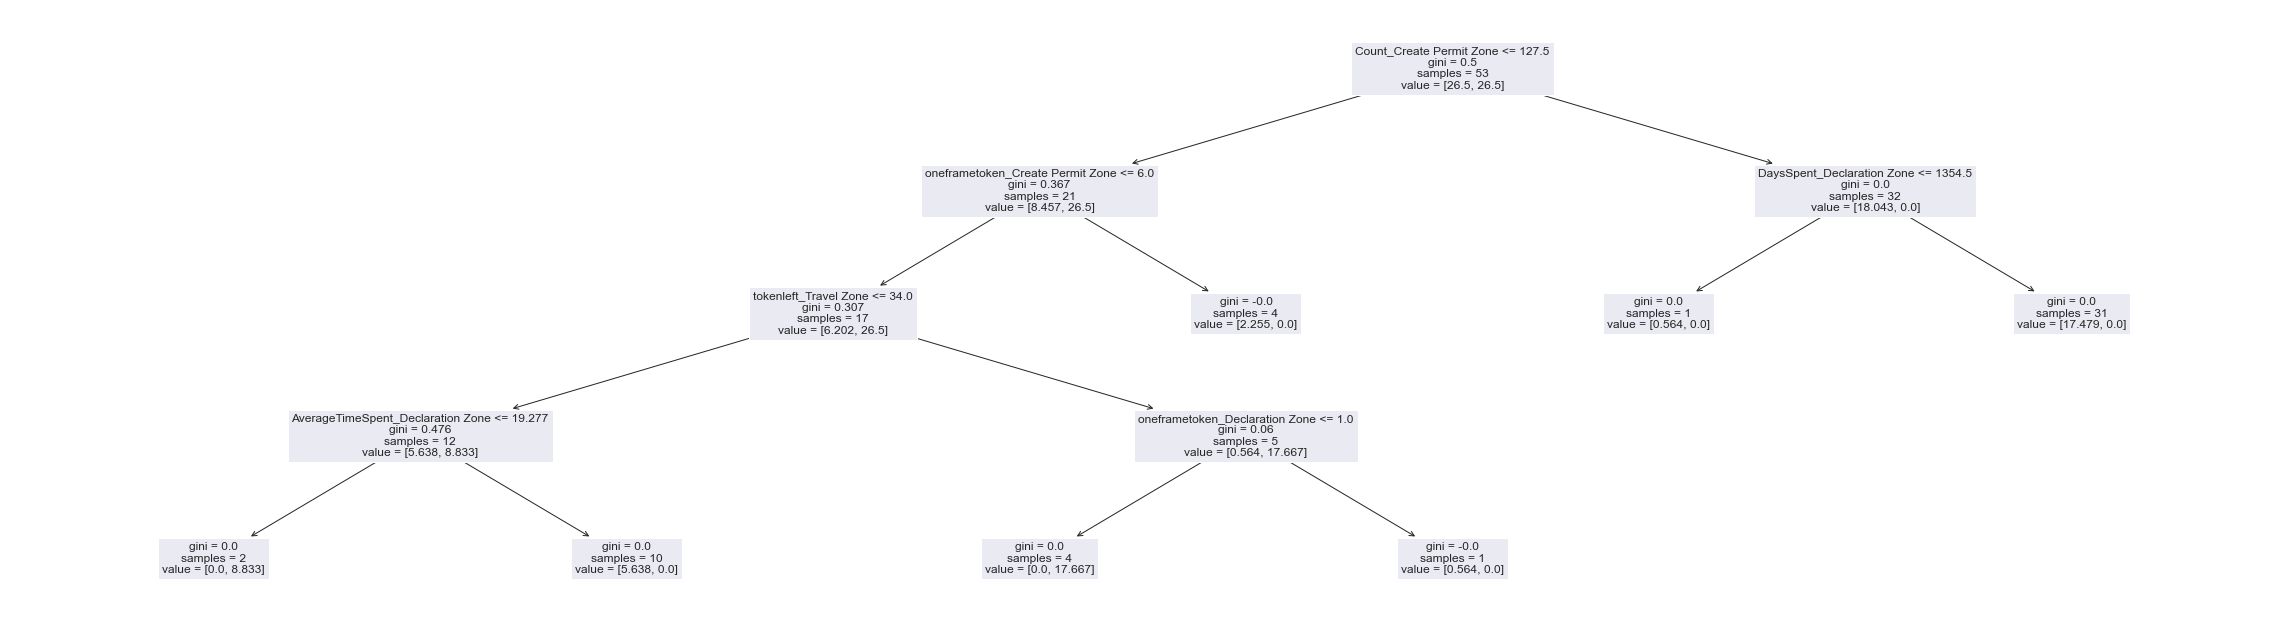

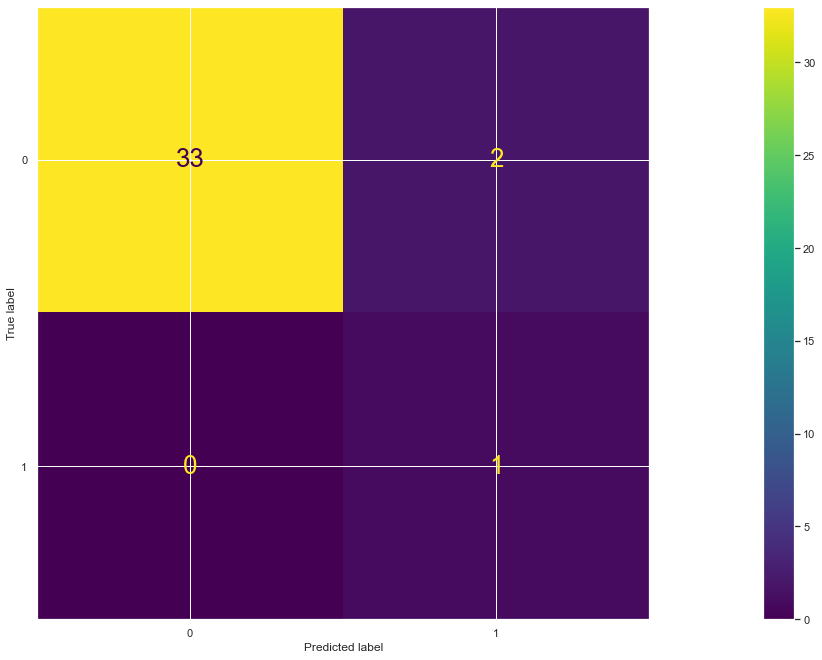

feature- Strange_oneframetoken :  Day : 15
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 16
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 17
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 18
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 19
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 20
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 21
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 22
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 23
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 24
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 25
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 26
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 27
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 28
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 29
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 30
Mean ROC AUC: nan
feature- Strange_onefram

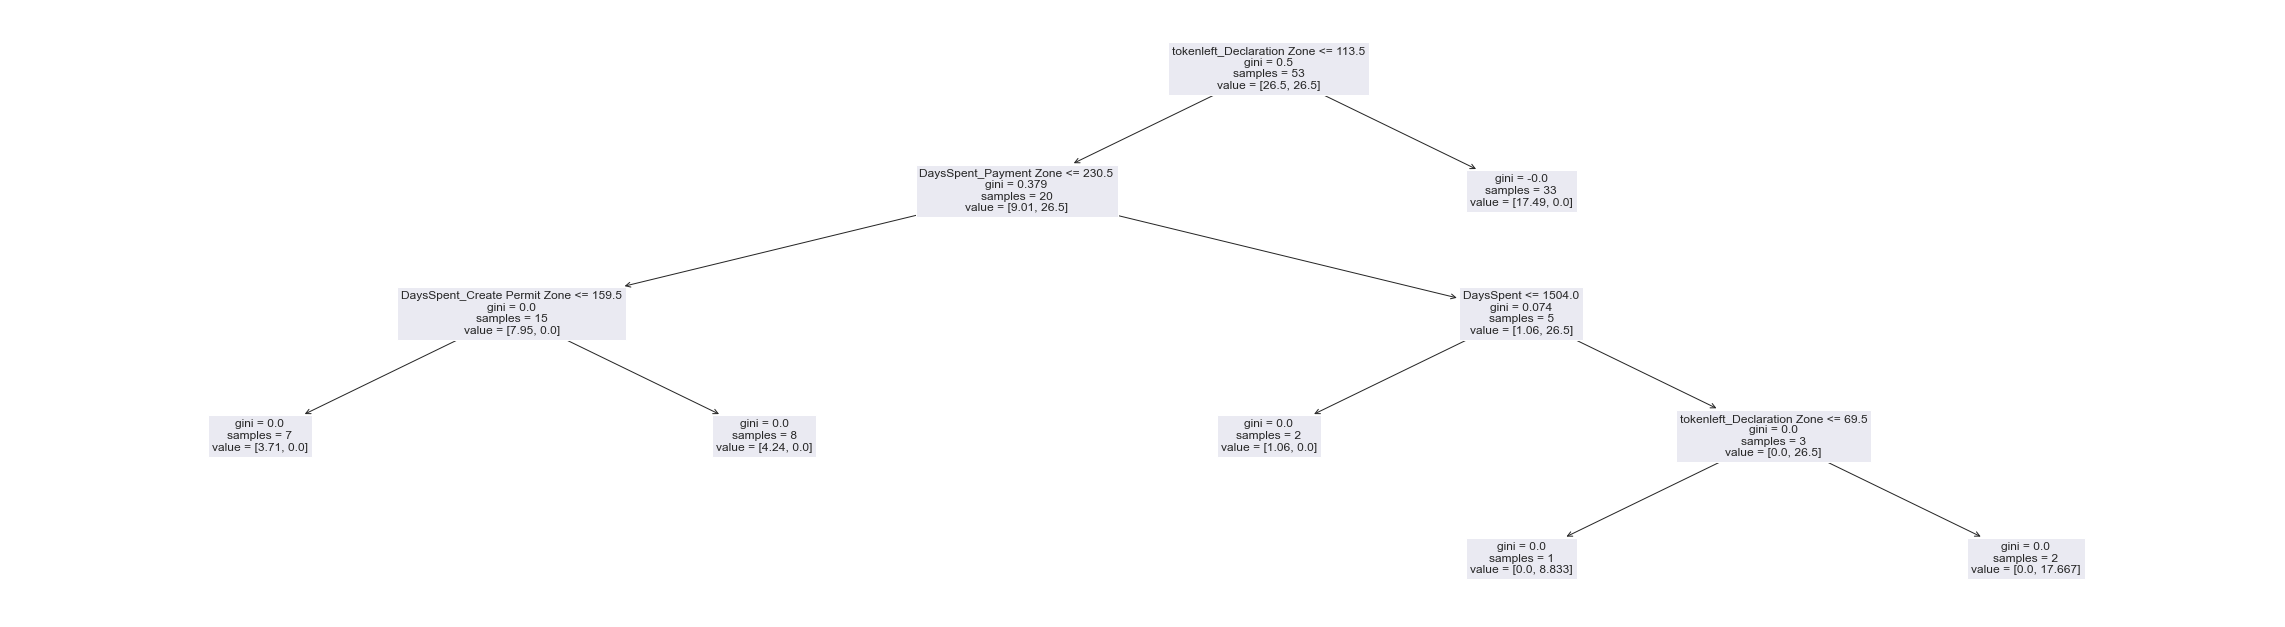

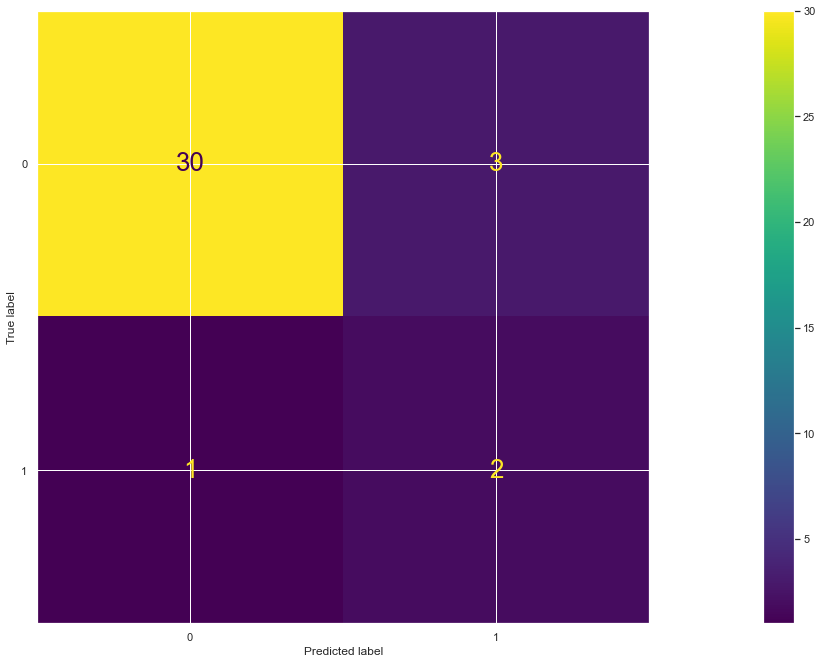

feature- Strange_oneframetoken :  Day : 43
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 44
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 45
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 46
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 47
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 48
Mean ROC AUC: nan
feature- Strange_oneframetoken :  Day : 49
Mean ROC AUC: nan
feature- Strange_Count :  Day : 0
Mean ROC AUC: nan
feature- Strange_Count :  Day : 0
Mean absolute error LR- 0.1875
Mean Squared error LR- 0.4330127018922193
Accuracy: 0.8125
F1: 0.7922077922077921
Precision: 0.7833333333333333
Recall: 0.8090909090909091


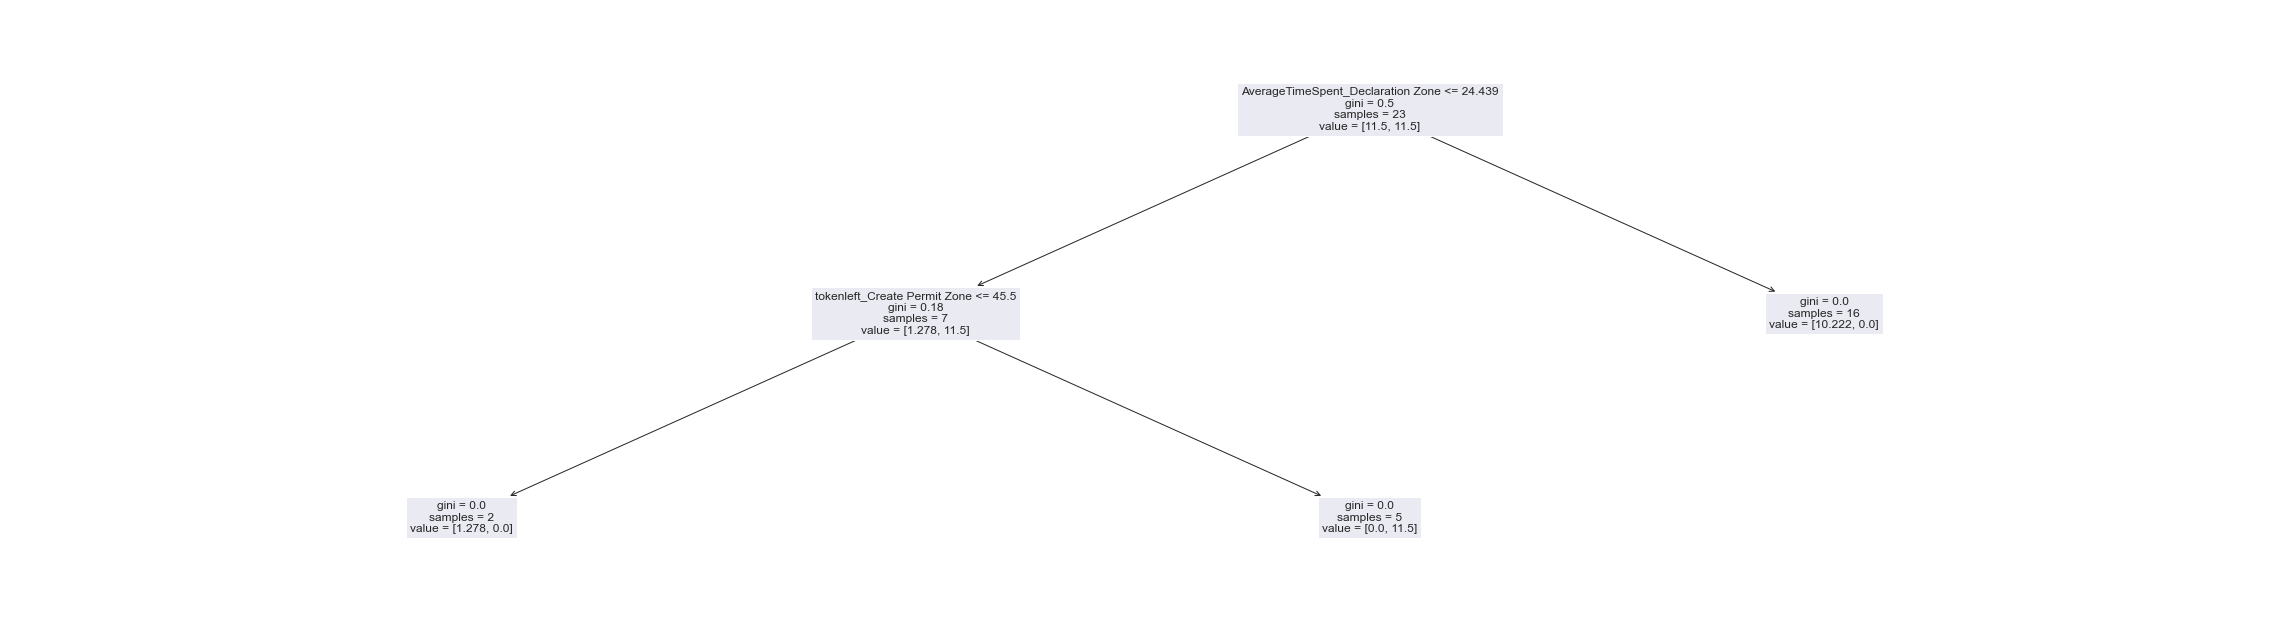

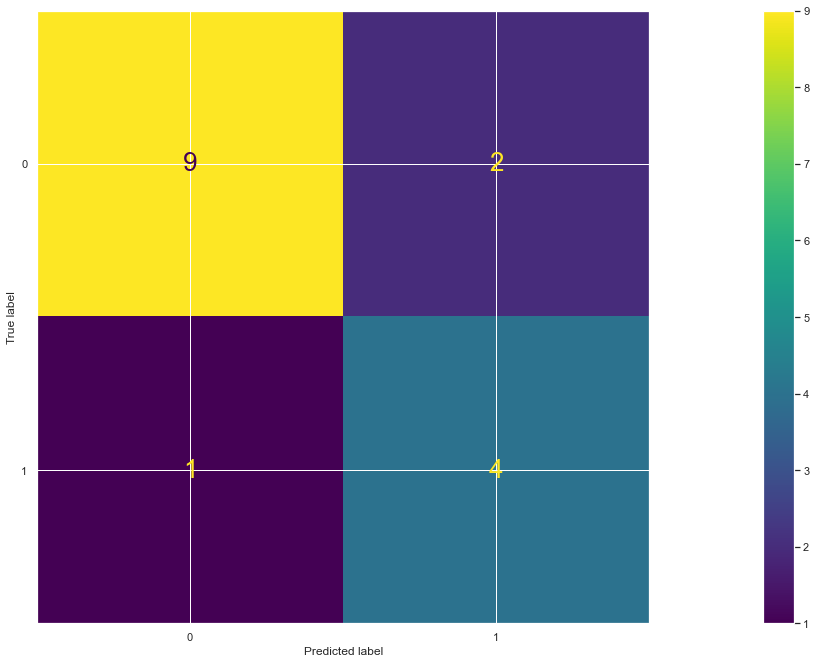

feature- Strange_Count :  Day : 1
Mean ROC AUC: nan
feature- Strange_Count :  Day : 1
Mean absolute error LR- 0.25
Mean Squared error LR- 0.5
Accuracy: 0.75
F1: 0.7090909090909091
Precision: 0.7090909090909091
Recall: 0.7090909090909091


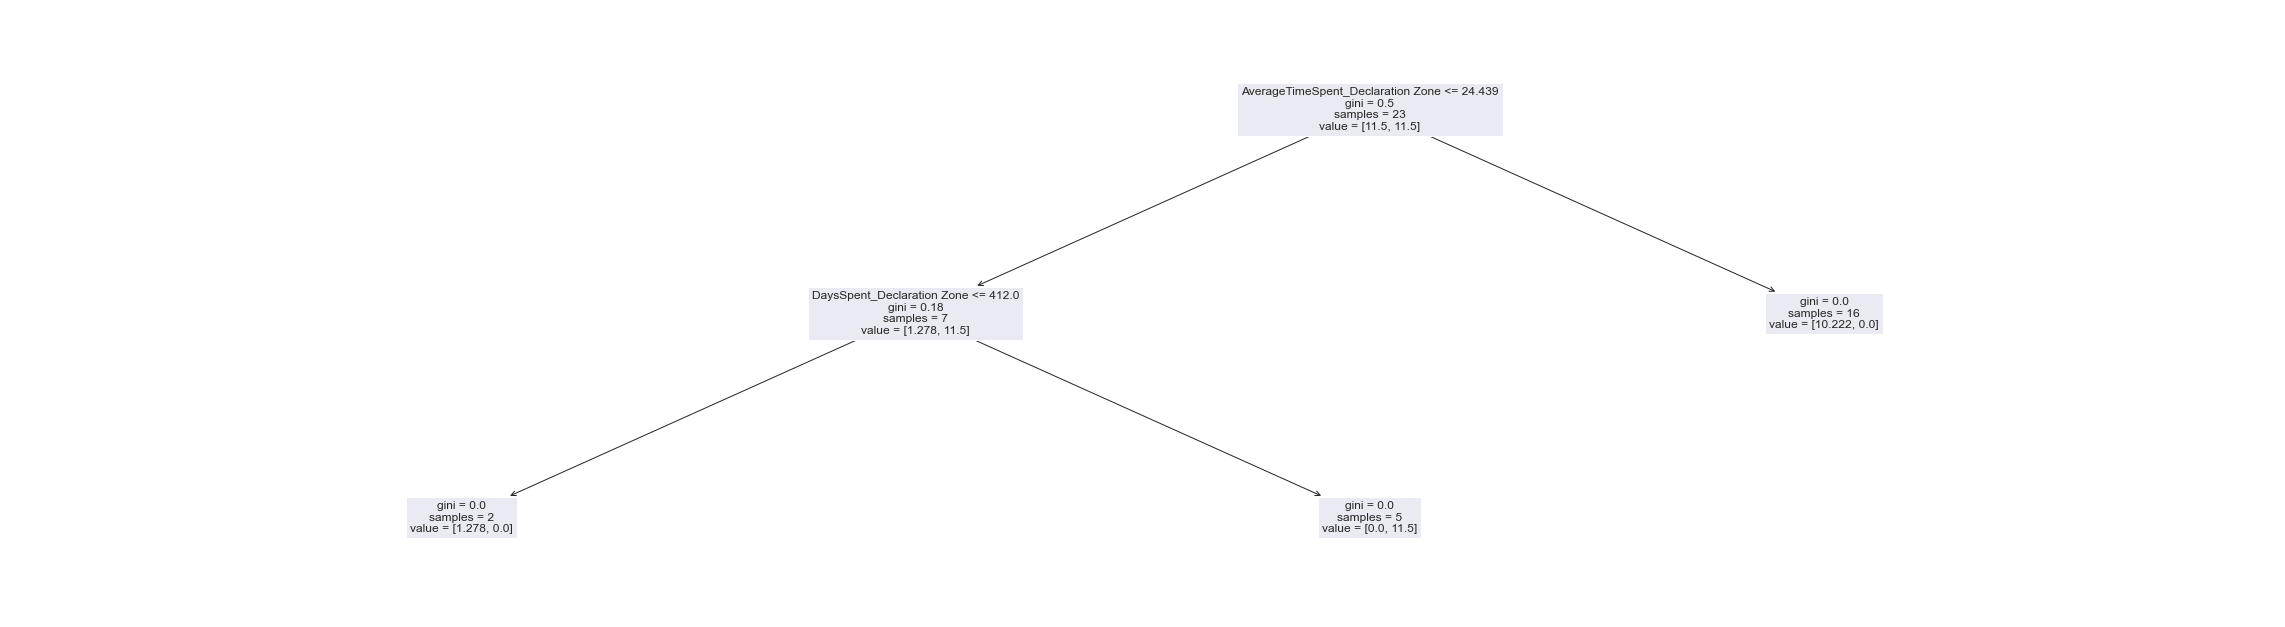

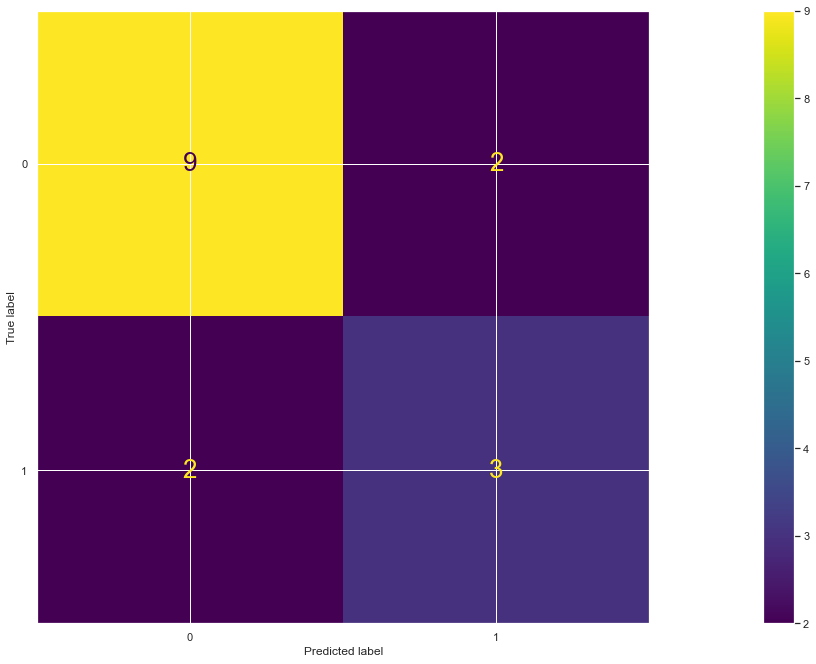

feature- Strange_Count :  Day : 2
Mean ROC AUC: nan
feature- Strange_Count :  Day : 2
Mean absolute error LR- 0.125
Mean Squared error LR- 0.3535533905932738
Accuracy: 0.875
F1: 0.8545454545454545
Precision: 0.8333333333333333
Recall: 0.9166666666666667


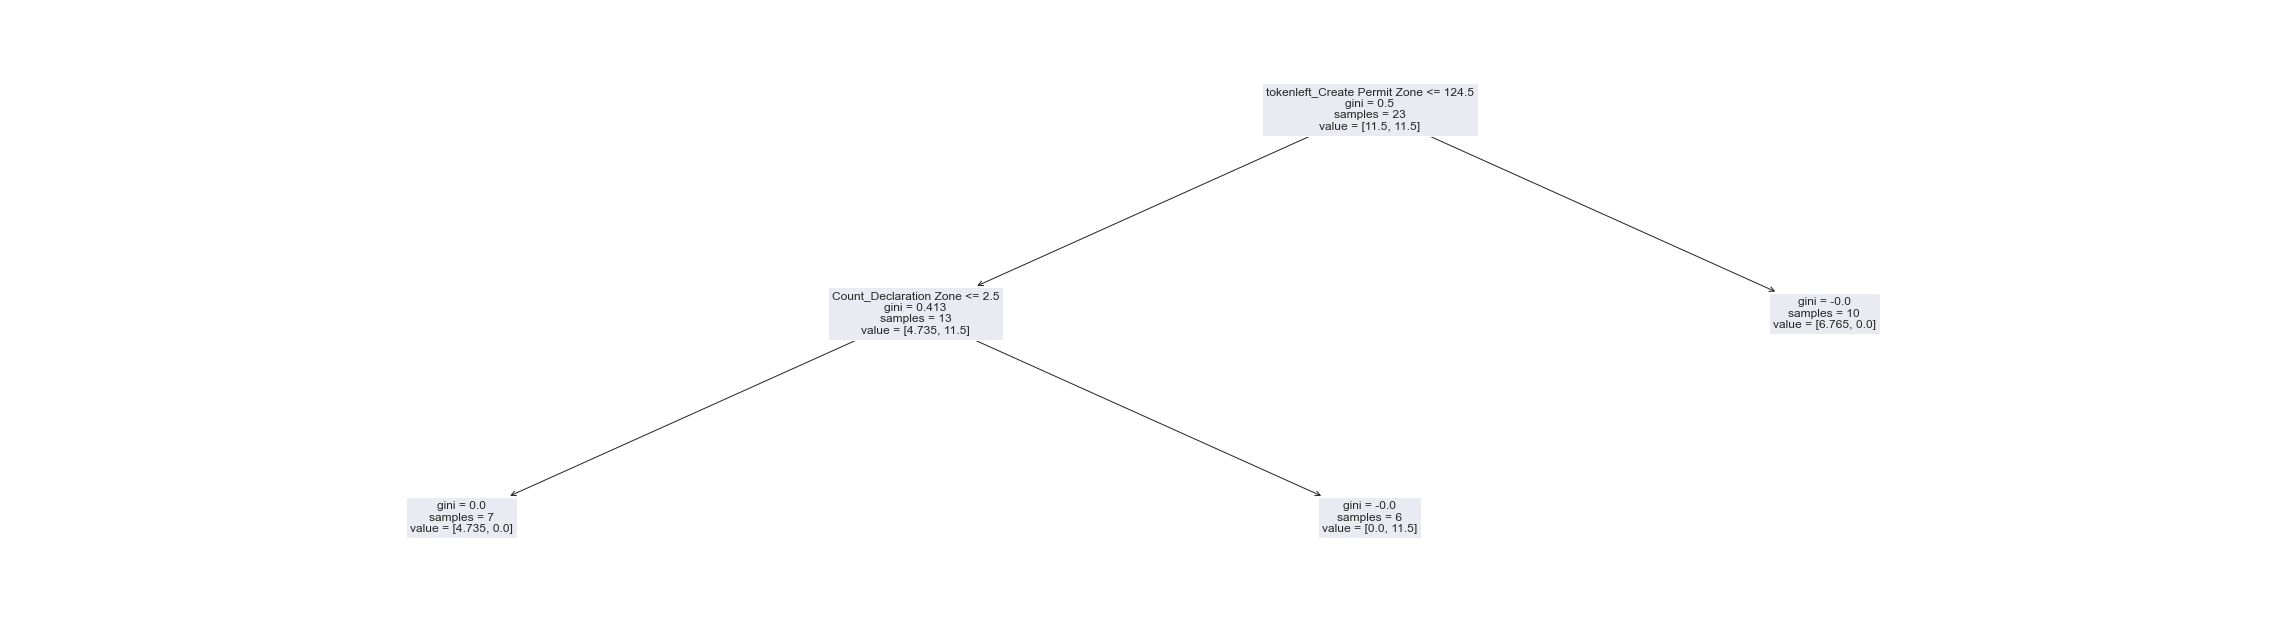

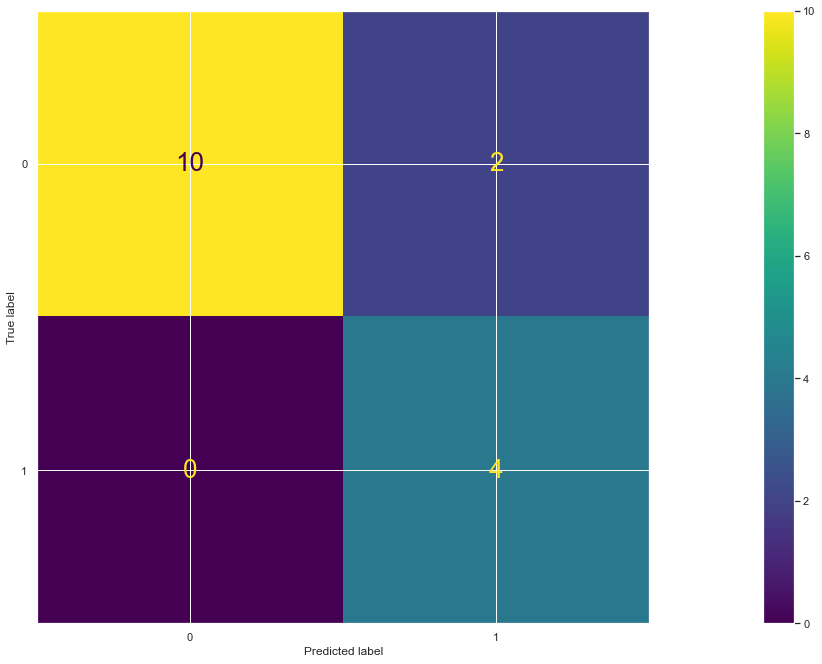

feature- Strange_Count :  Day : 3
Mean ROC AUC: nan
feature- Strange_Count :  Day : 3
Mean absolute error LR- 0.0625
Mean Squared error LR- 0.25
Accuracy: 0.9375
F1: 0.9307359307359306
Precision: 0.9166666666666667
Recall: 0.9545454545454546


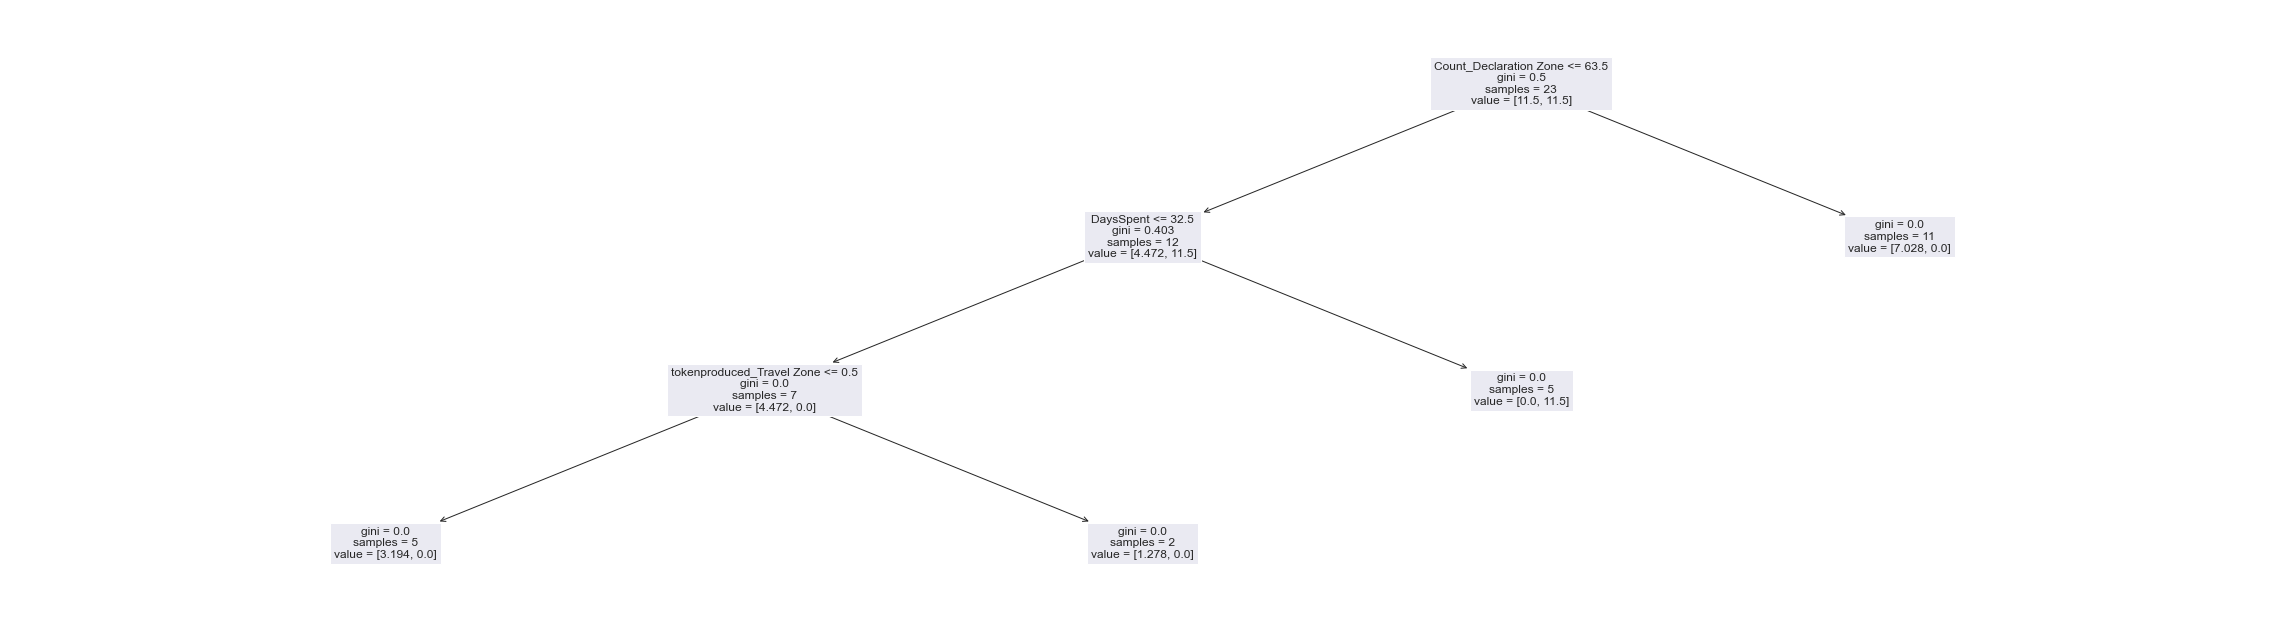

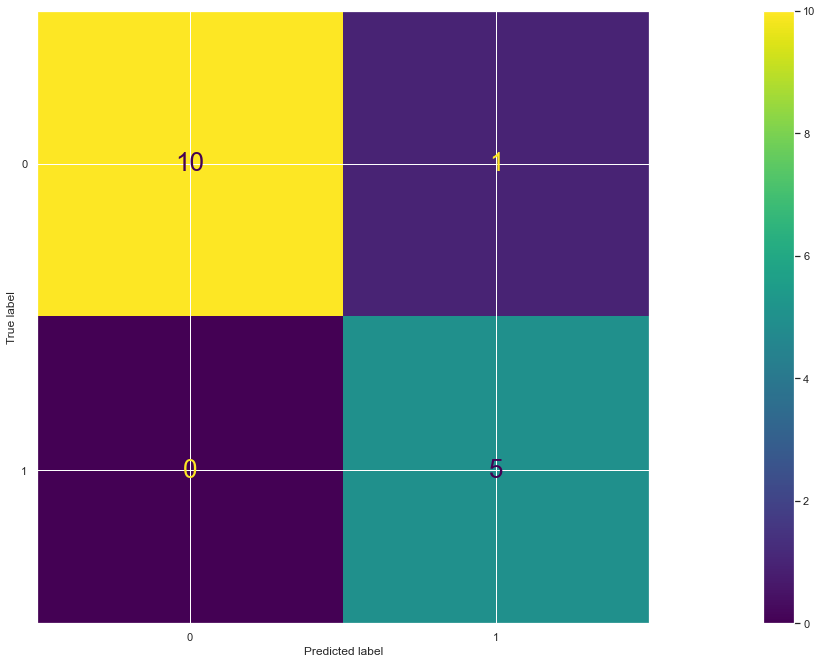

feature- Strange_Count :  Day : 4
Mean ROC AUC: nan
feature- Strange_Count :  Day : 5
Mean ROC AUC: nan
feature- Strange_Count :  Day : 5
Mean absolute error LR- 0.0625
Mean Squared error LR- 0.25
Accuracy: 0.9375
F1: 0.9352226720647774
Precision: 0.95
Recall: 0.9285714285714286


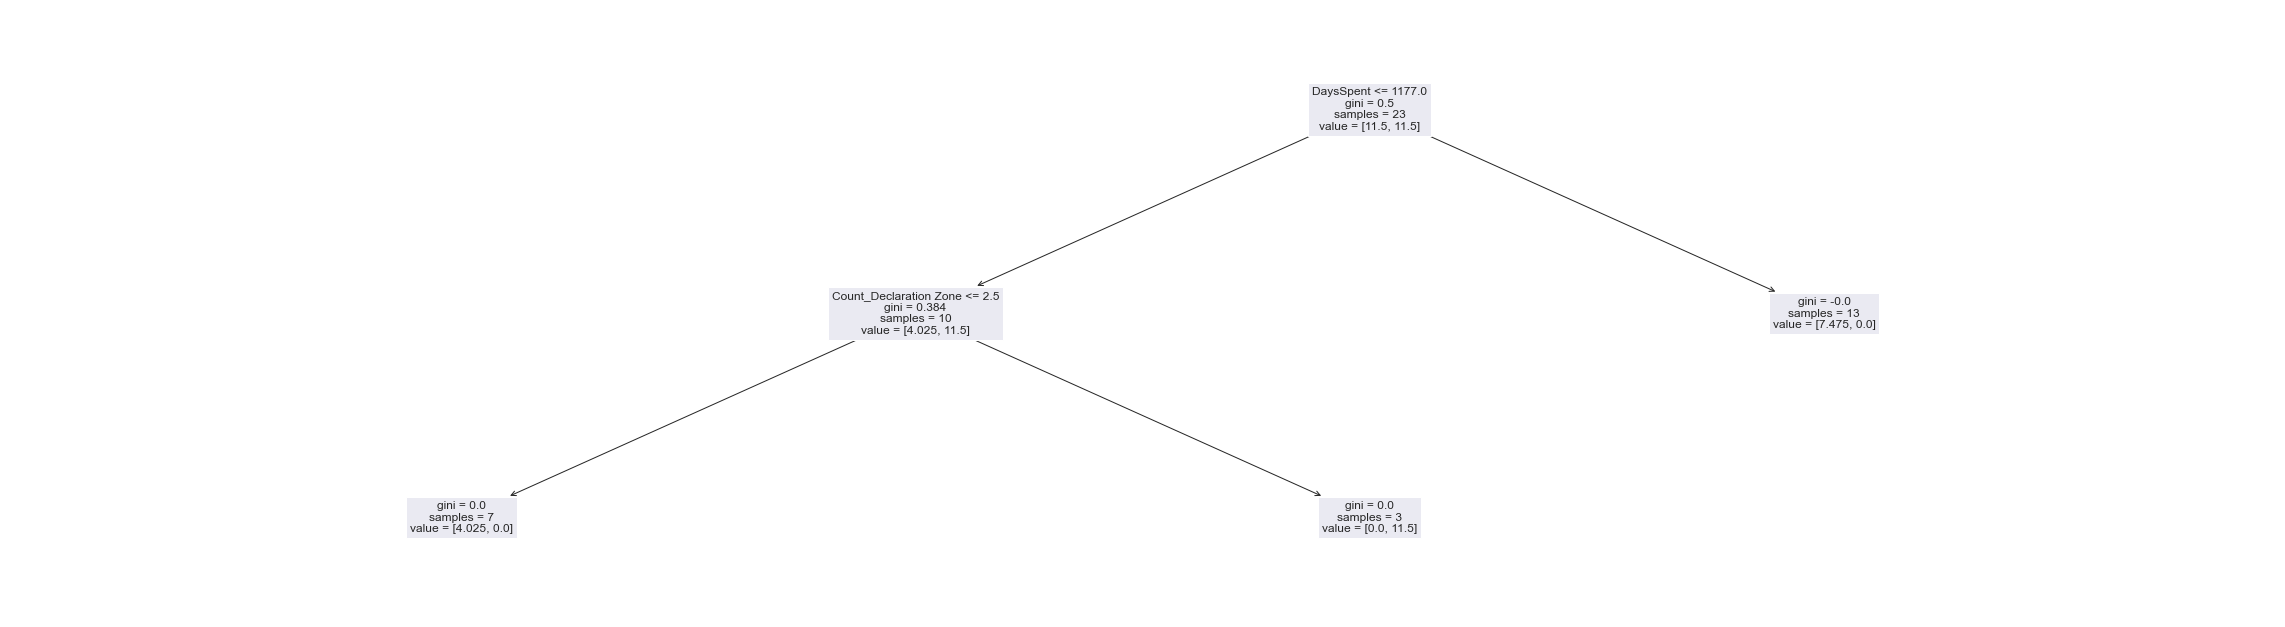

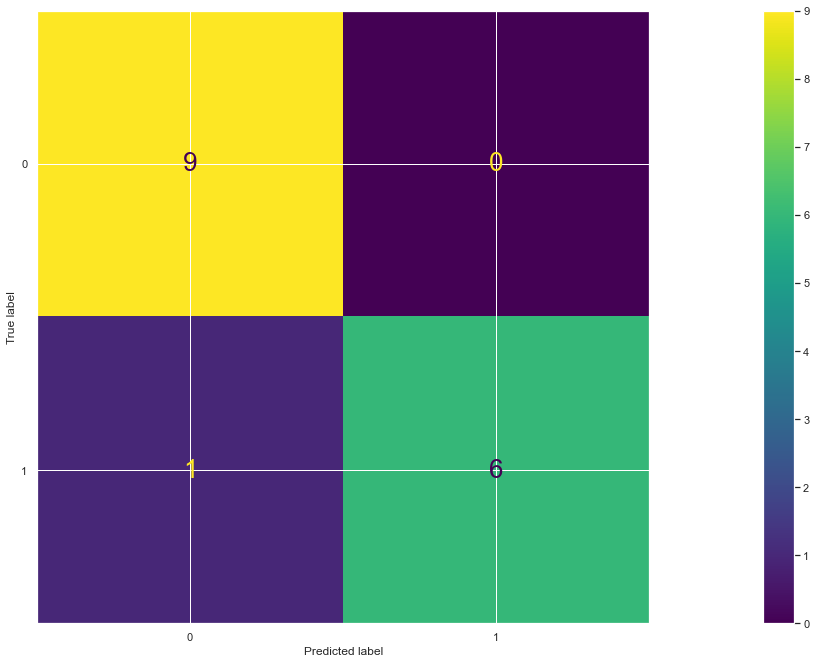

feature- Strange_Count :  Day : 6
Mean ROC AUC: nan
feature- Strange_Count :  Day : 6
Mean absolute error LR- 0.1875
Mean Squared error LR- 0.4330127018922193
Accuracy: 0.8125
F1: 0.805668016194332
Precision: 0.8125
Recall: 0.8636363636363636


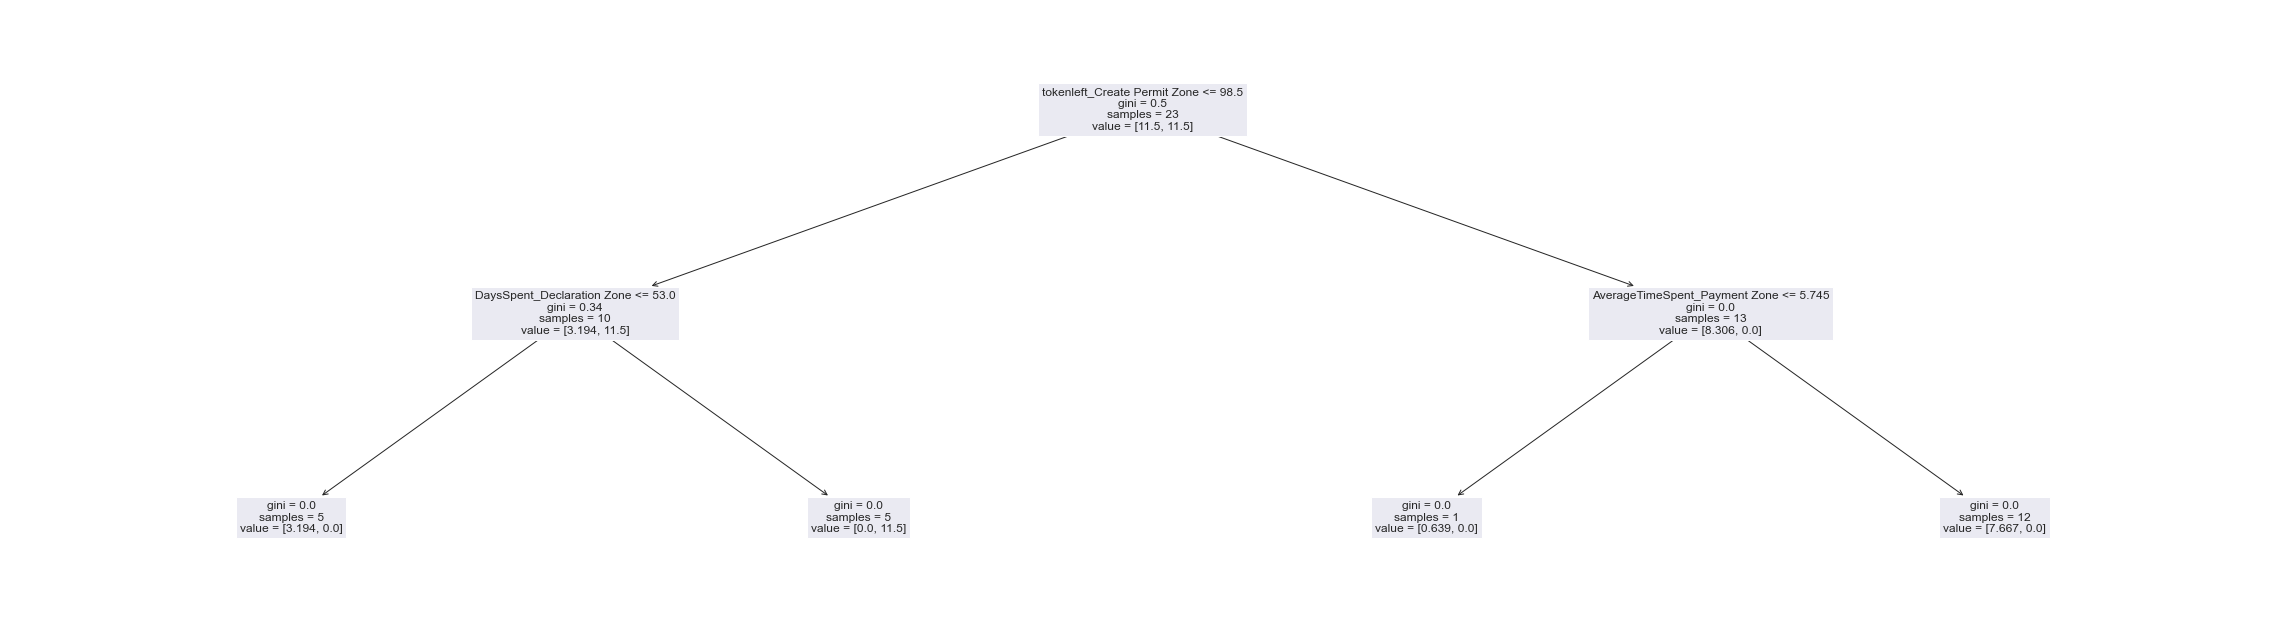

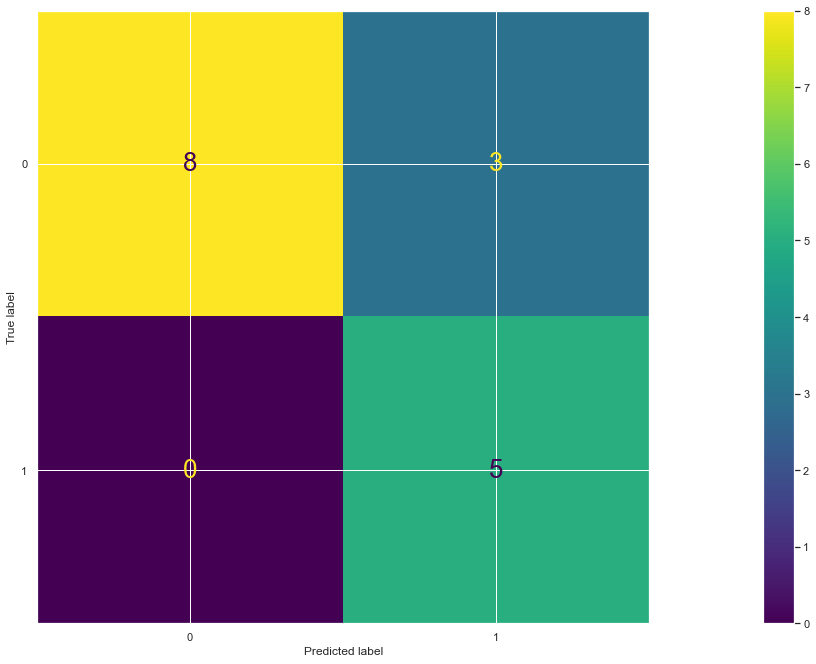

feature- Strange_Count :  Day : 7
Mean ROC AUC: nan
feature- Strange_Count :  Day : 8
Mean ROC AUC: nan
feature- Strange_Count :  Day : 8
Mean absolute error LR- 0.1875
Mean Squared error LR- 0.4330127018922193
Accuracy: 0.8125
F1: 0.7922077922077921
Precision: 0.8090909090909091
Recall: 0.7833333333333333


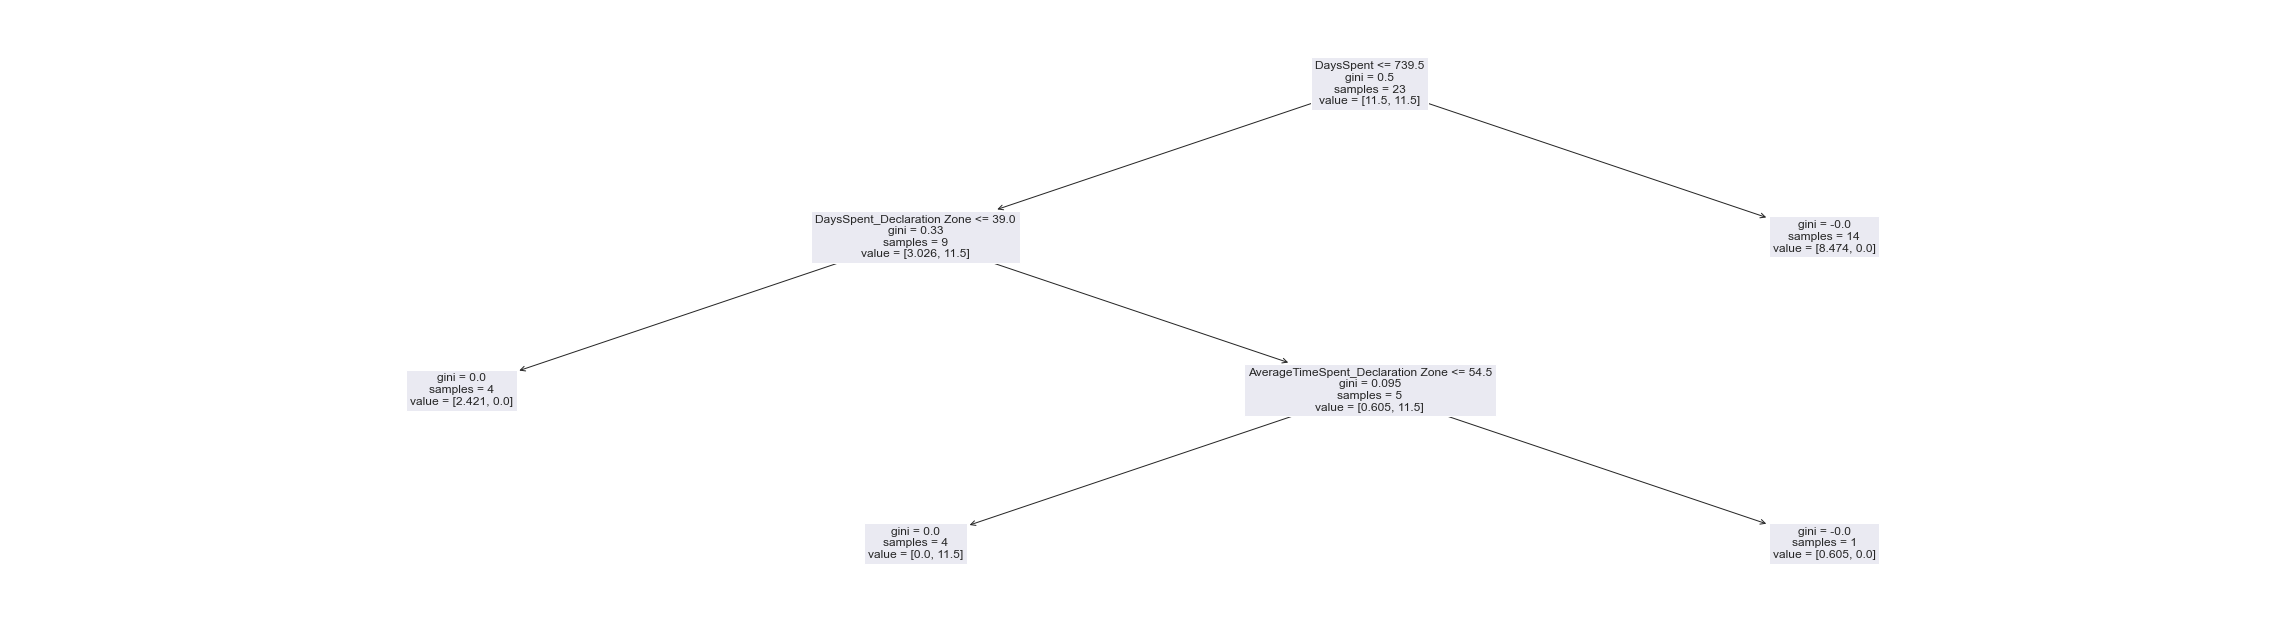

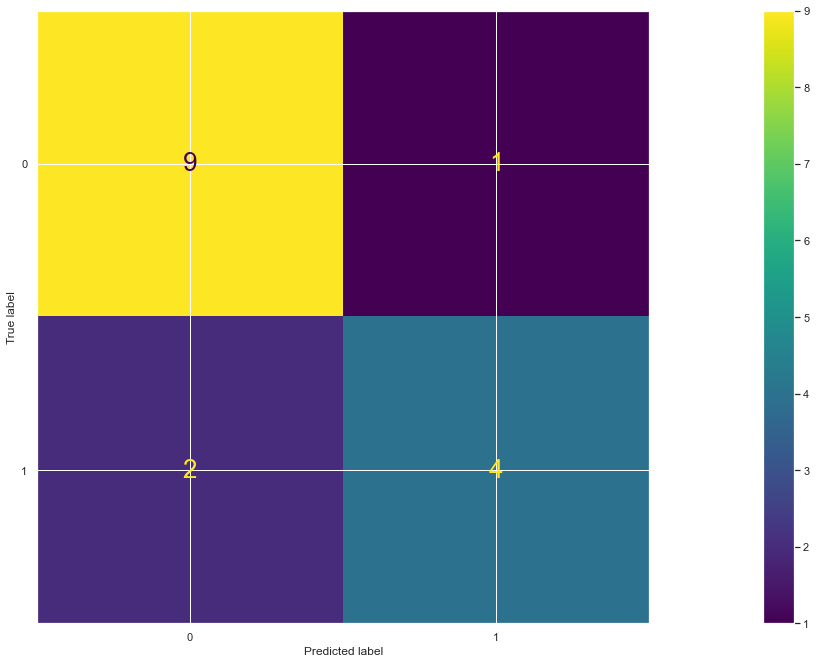

feature- Strange_Count :  Day : 9
Mean ROC AUC: nan
feature- Strange_Count :  Day : 9
Mean absolute error LR- 0.25
Mean Squared error LR- 0.5
Accuracy: 0.75
F1: 0.7333333333333334
Precision: 0.7333333333333334
Recall: 0.7333333333333334


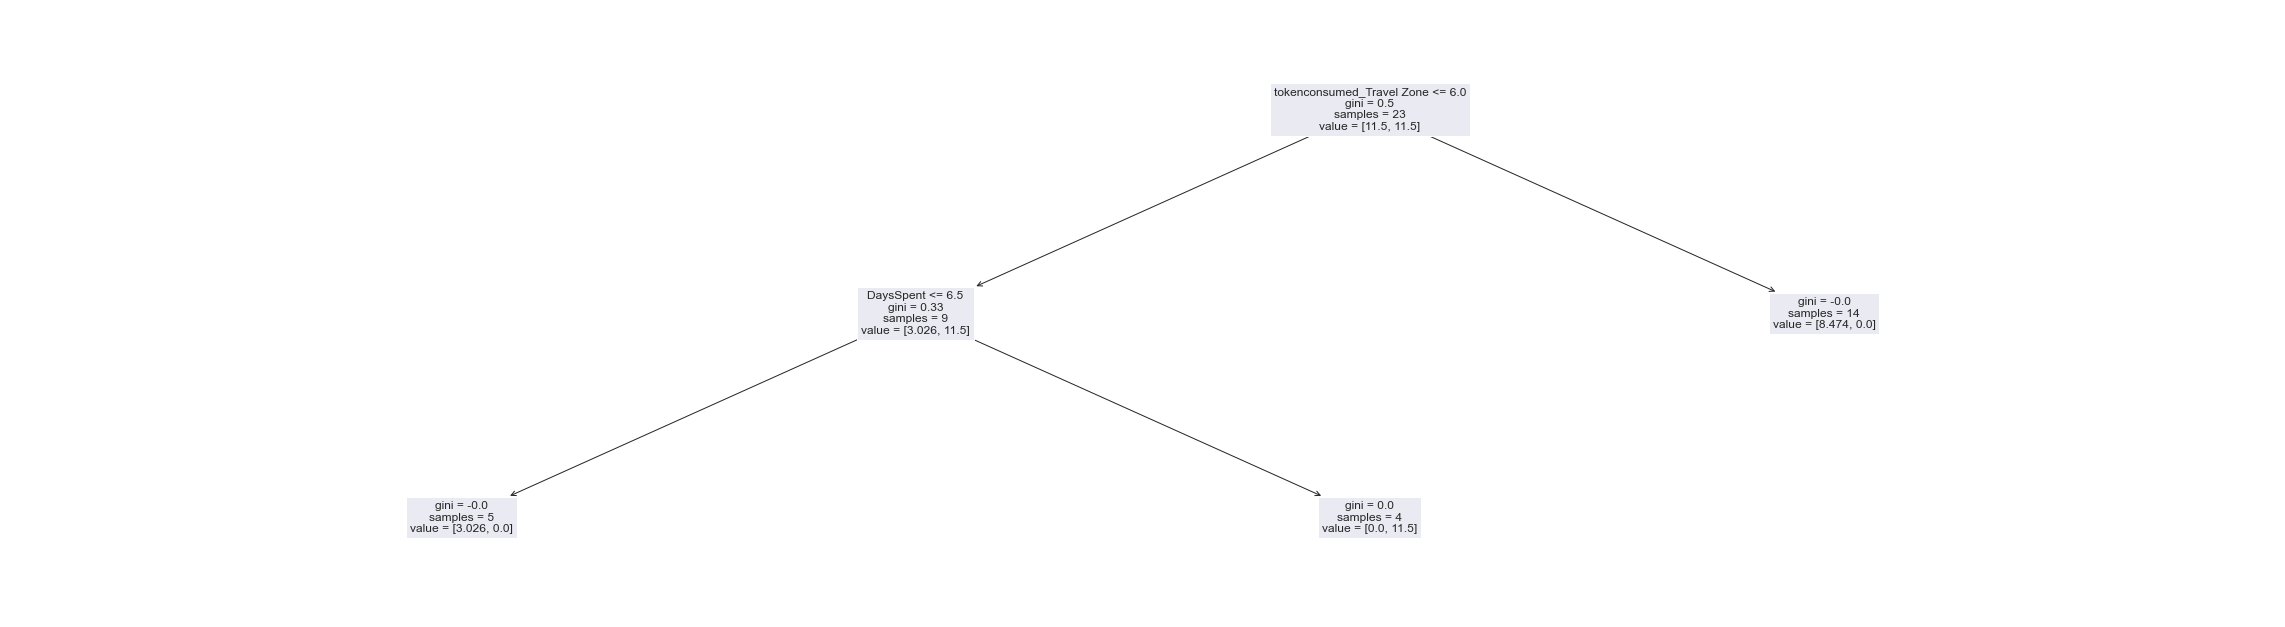

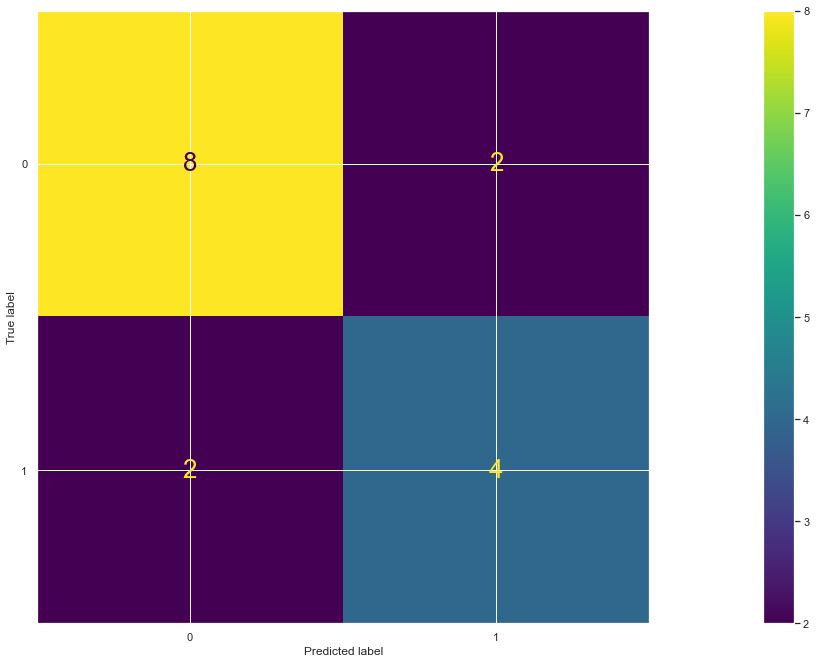

feature- Strange_Count :  Day : 10
Mean ROC AUC: nan
feature- Strange_Count :  Day : 10
Mean absolute error LR- 0.125
Mean Squared error LR- 0.3535533905932738
Accuracy: 0.875
F1: 0.8545454545454546
Precision: 0.8545454545454545
Recall: 0.8545454545454545


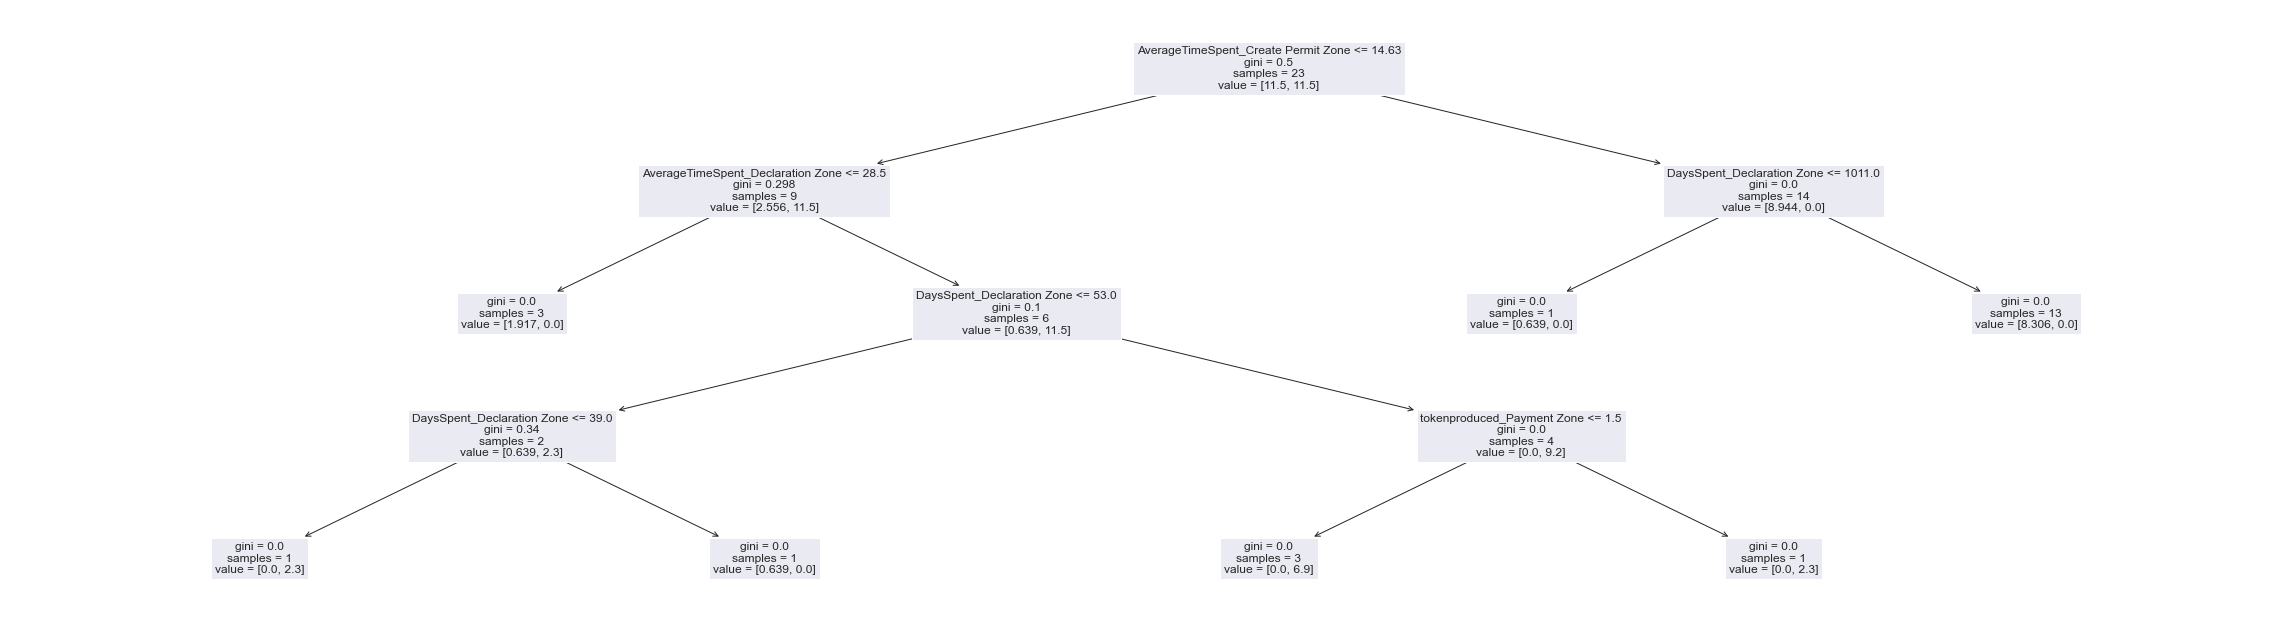

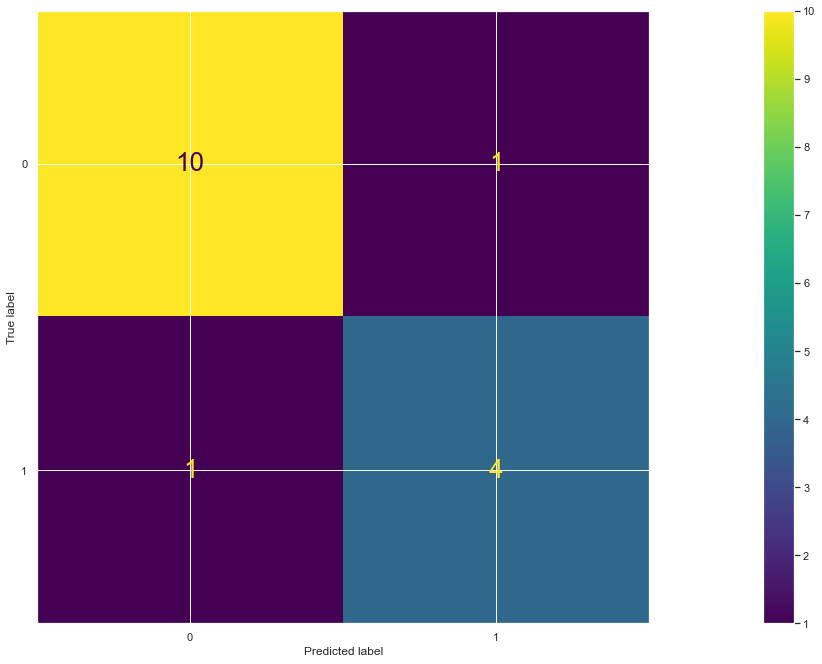

feature- Strange_Count :  Day : 11
Mean ROC AUC: nan
feature- Strange_Count :  Day : 11
Mean absolute error LR- 0.0625
Mean Squared error LR- 0.25
Accuracy: 0.9375
F1: 0.9307359307359306
Precision: 0.9166666666666667
Recall: 0.9545454545454546


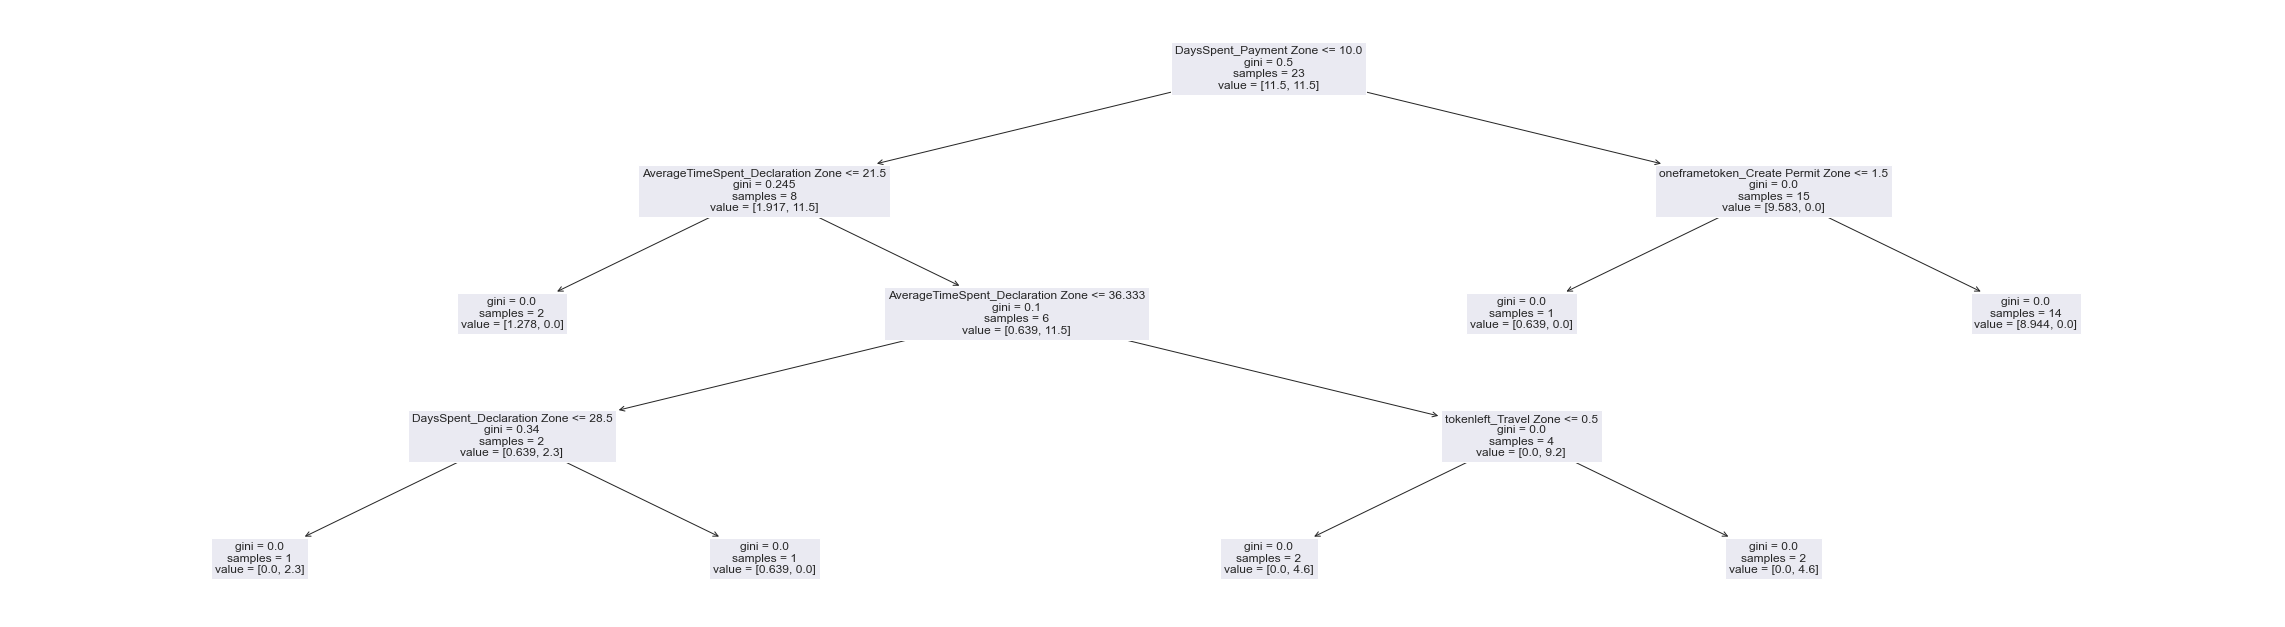

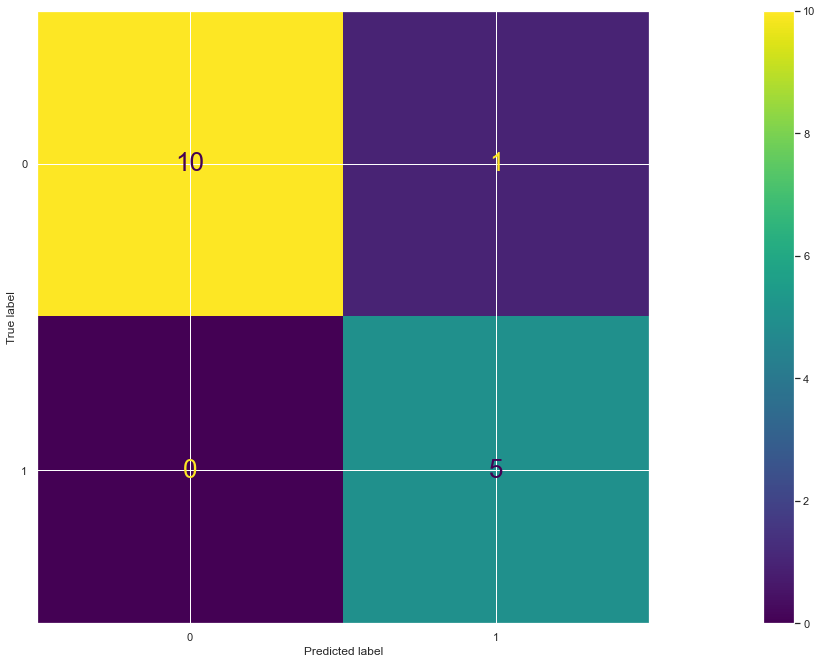

feature- Strange_Count :  Day : 12
Mean ROC AUC: nan
feature- Strange_Count :  Day : 12
Mean absolute error LR- 0.125
Mean Squared error LR- 0.3535533905932738
Accuracy: 0.875
F1: 0.8545454545454546
Precision: 0.8545454545454545
Recall: 0.8545454545454545


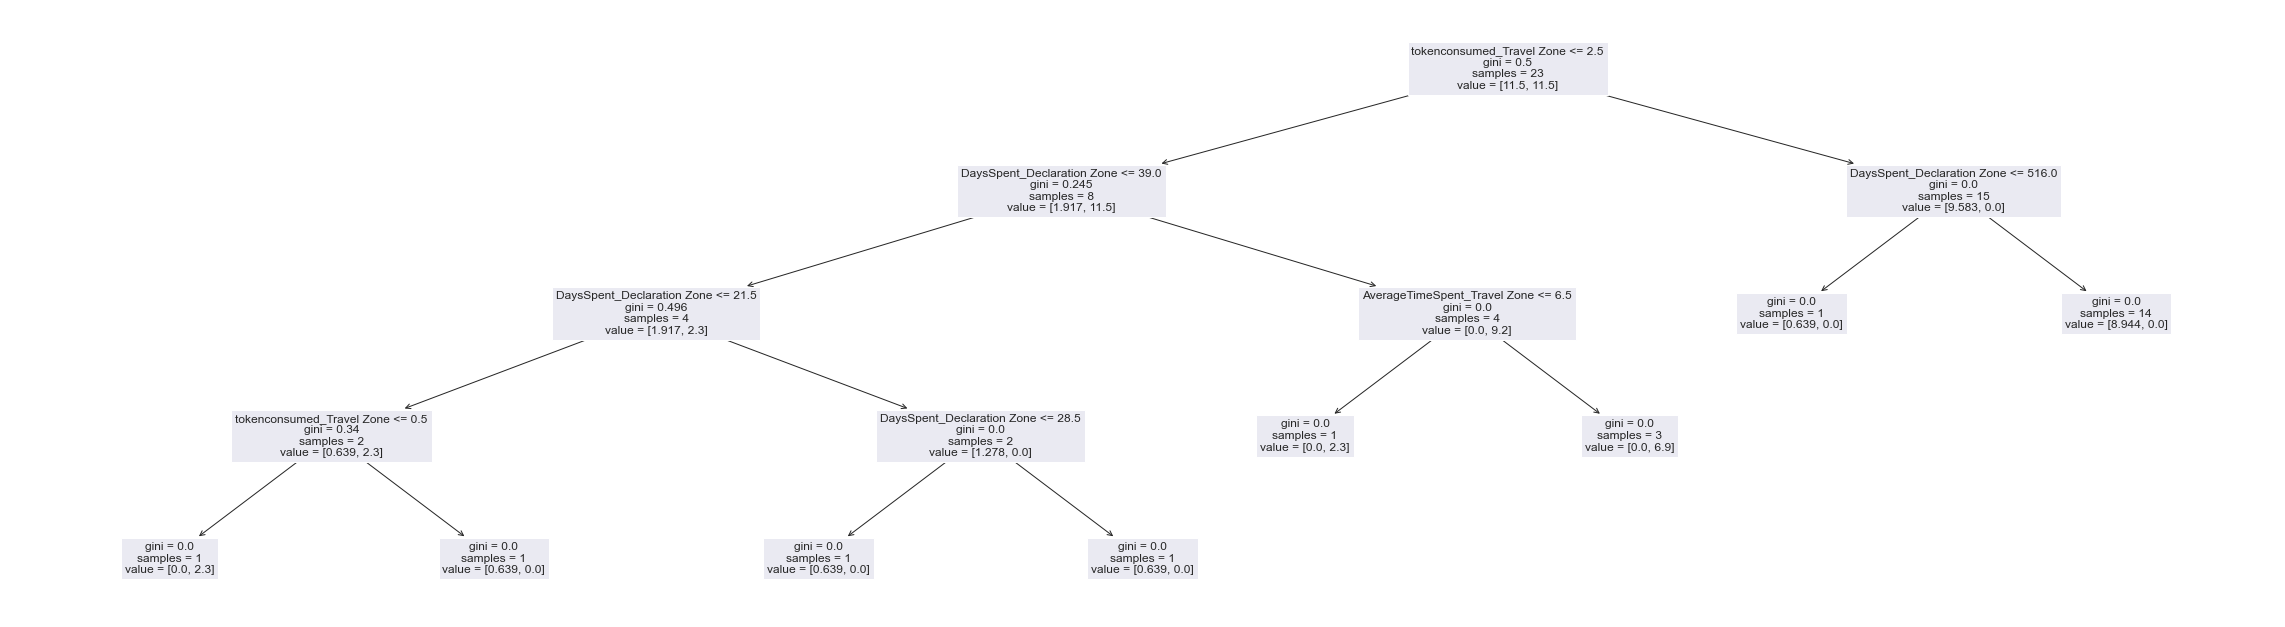

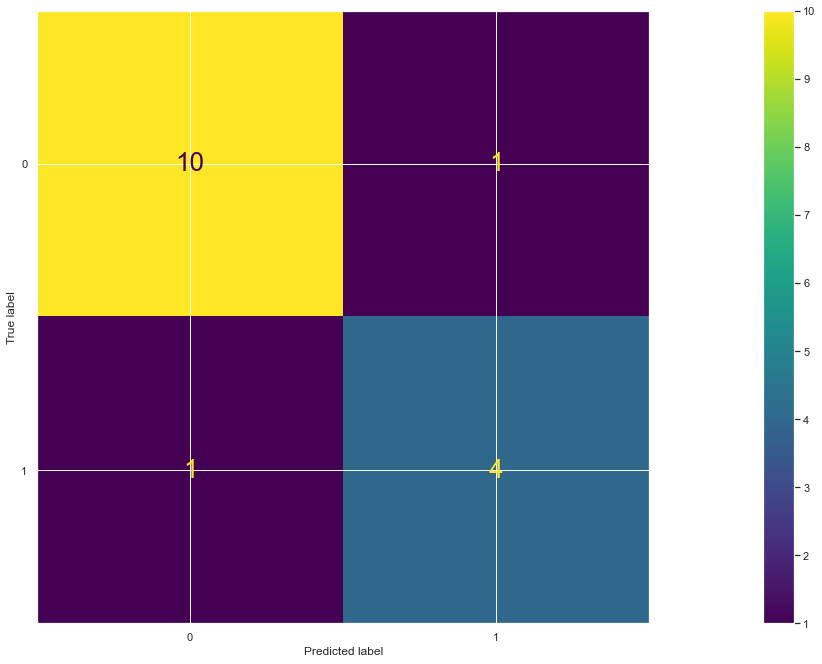

feature- Strange_Count :  Day : 13
Mean ROC AUC: nan
feature- Strange_Count :  Day : 13
Mean absolute error LR- 0.125
Mean Squared error LR- 0.3535533905932738
Accuracy: 0.875
F1: 0.8545454545454545
Precision: 0.8333333333333333
Recall: 0.9166666666666667


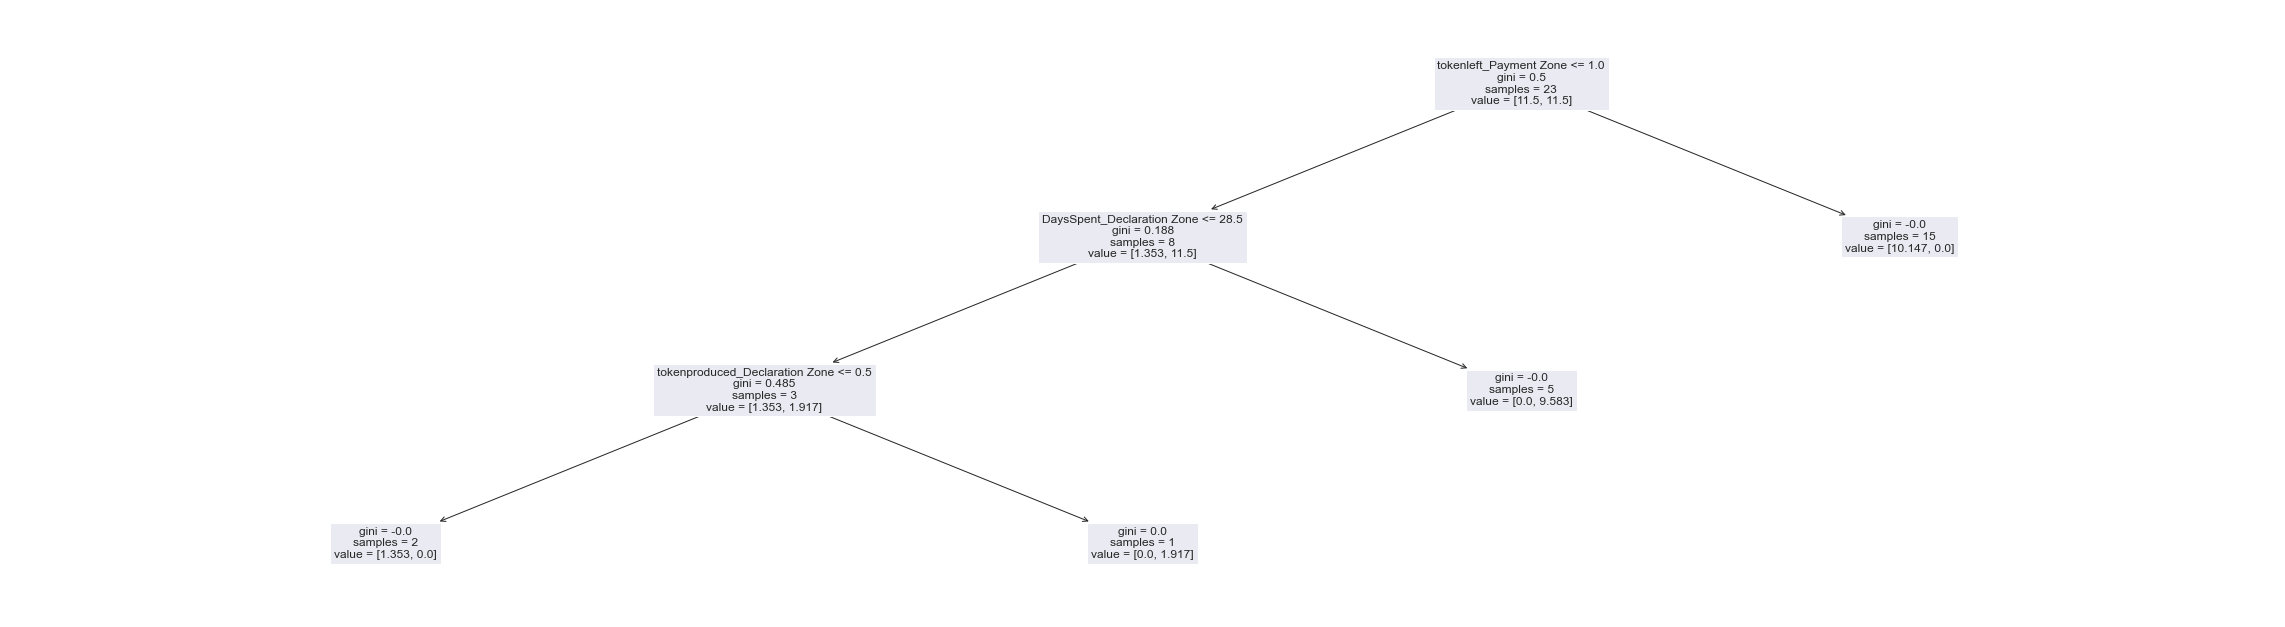

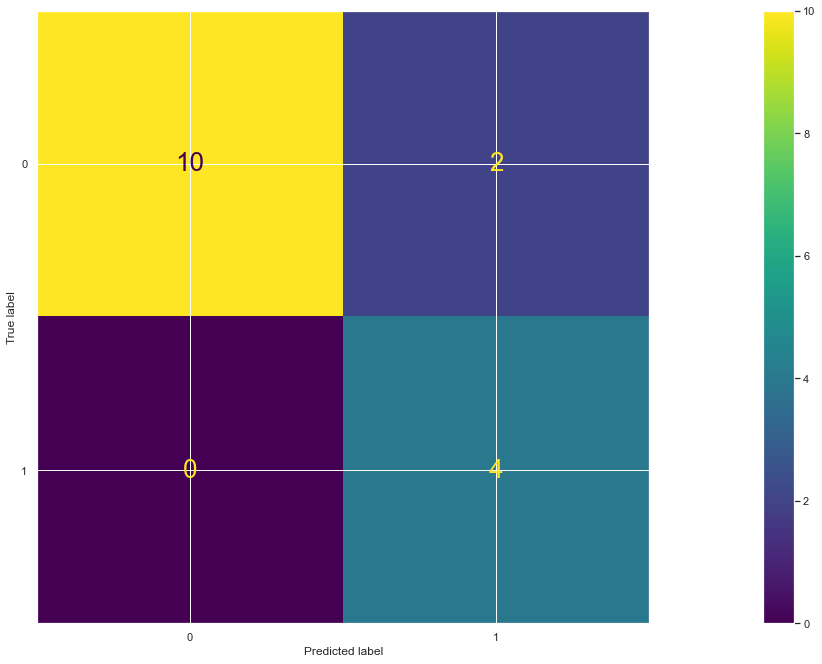

feature- Strange_Count :  Day : 14
Mean ROC AUC: nan
feature- Strange_Count :  Day : 14
Mean absolute error LR- 0.1875
Mean Squared error LR- 0.4330127018922193
Accuracy: 0.8125
F1: 0.7681159420289854
Precision: 0.7545454545454545
Recall: 0.7916666666666667


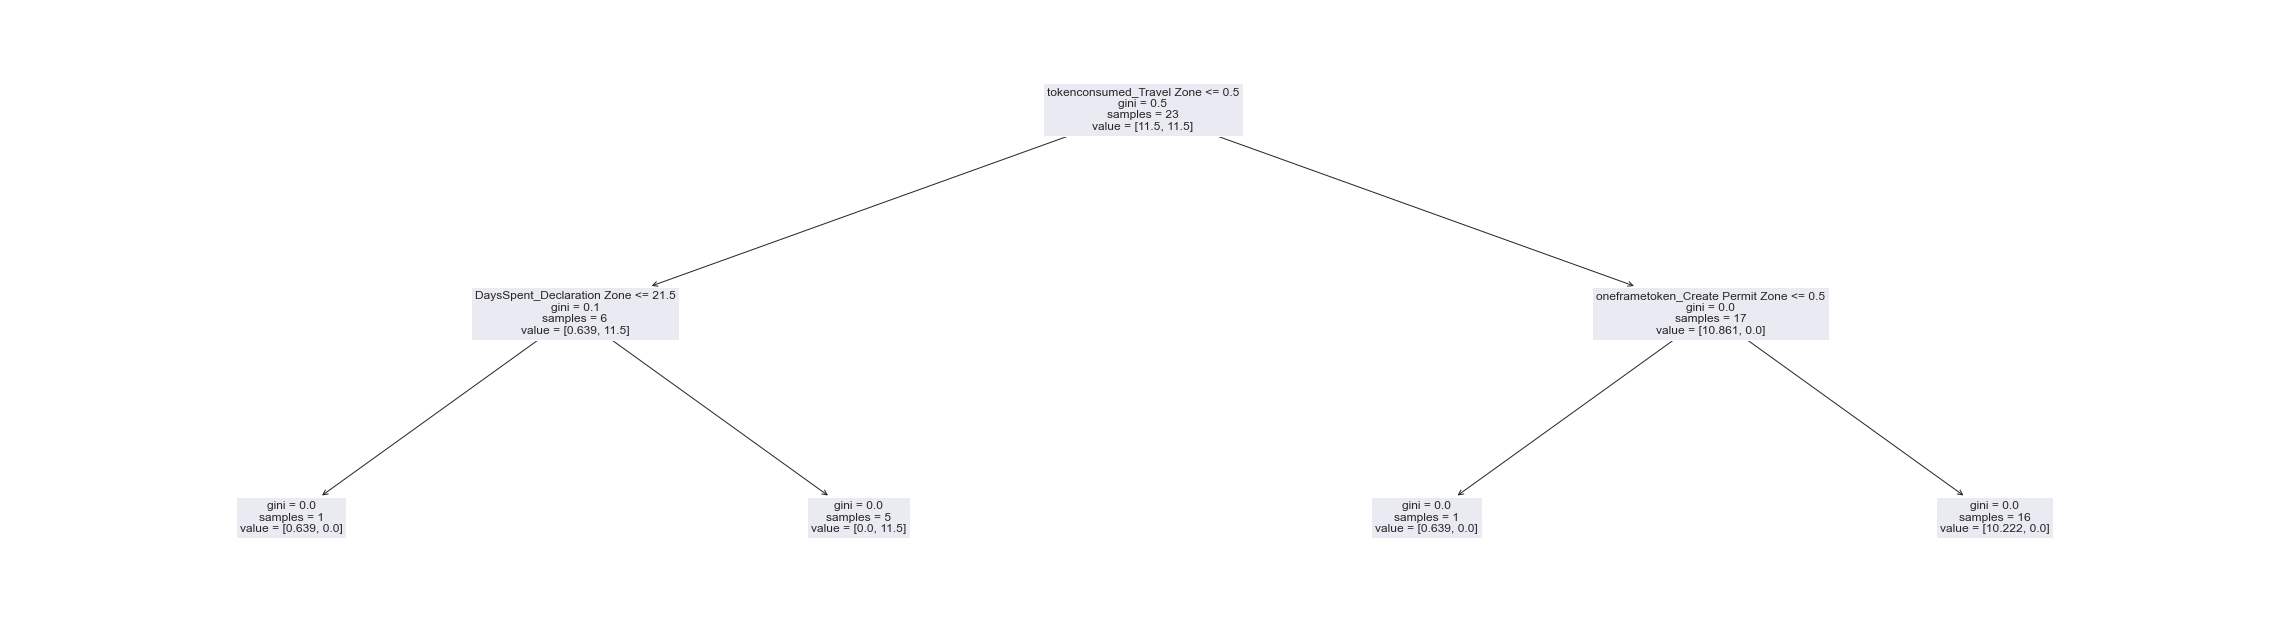

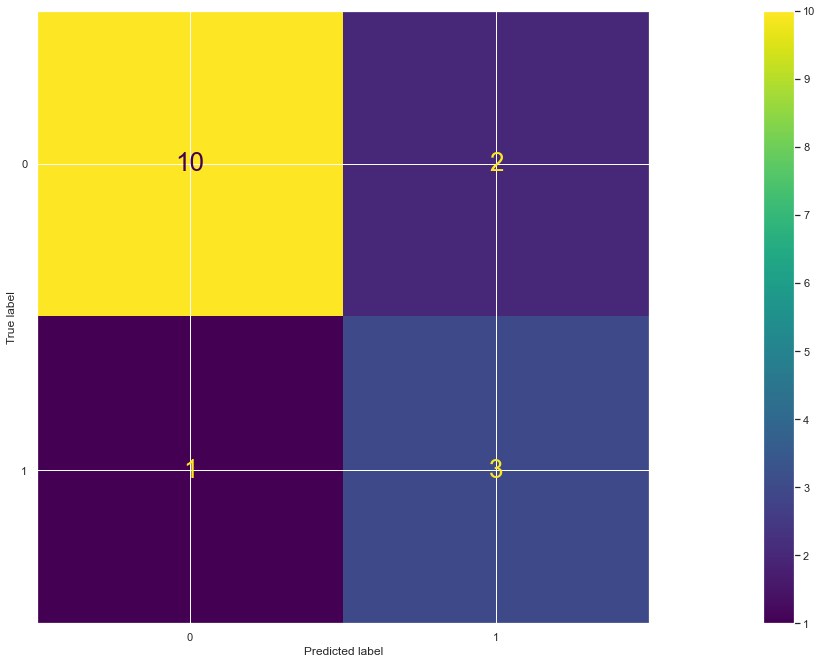

feature- Strange_Count :  Day : 15
Mean ROC AUC: nan
feature- Strange_Count :  Day : 15
Mean absolute error LR- 0.0625
Mean Squared error LR- 0.25
Accuracy: 0.9375
F1: 0.9085714285714286
Precision: 0.9615384615384616
Recall: 0.875


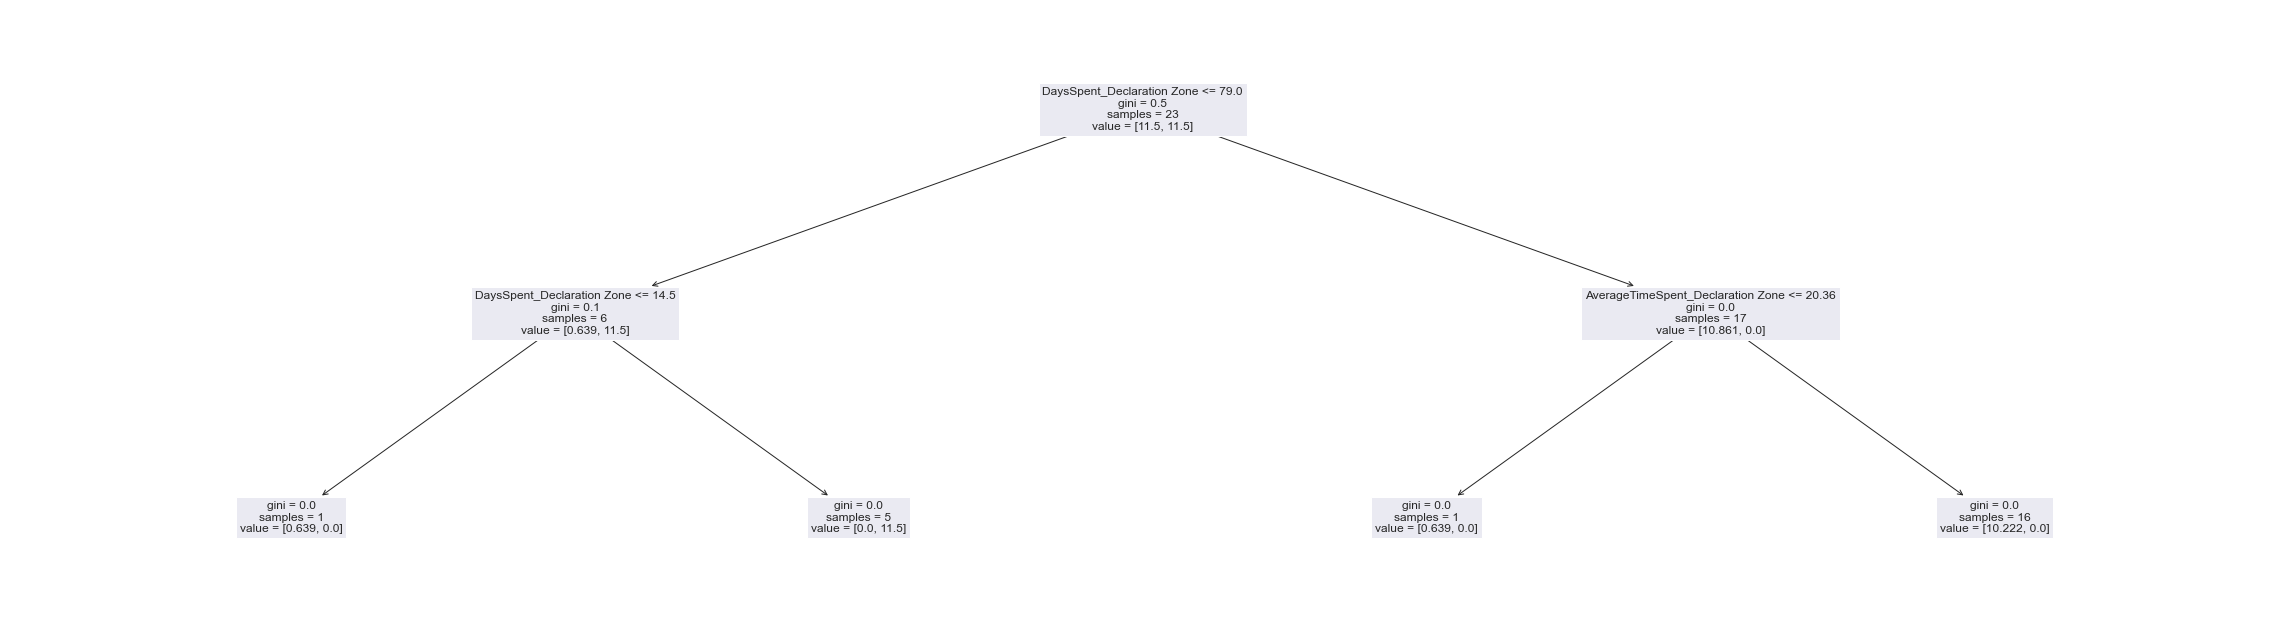

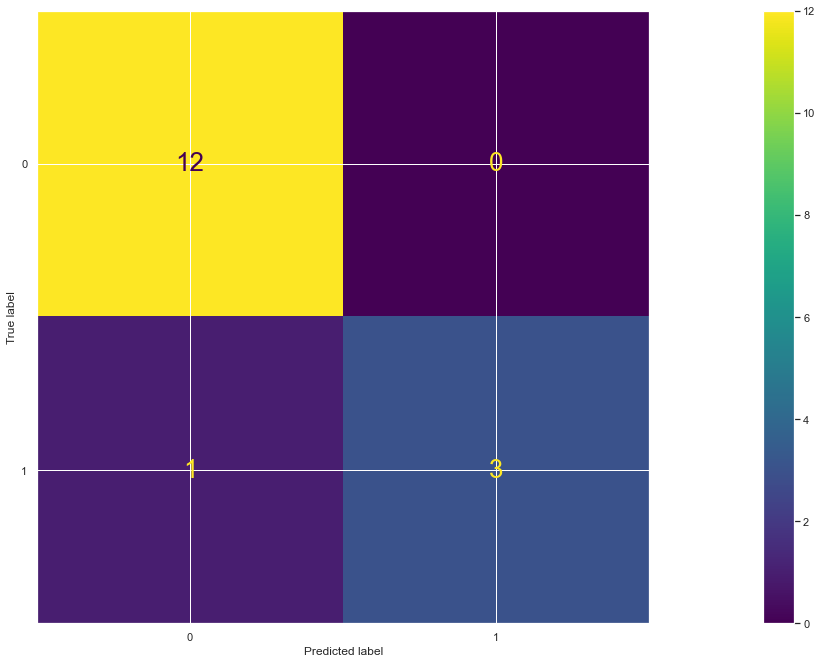

feature- Strange_Count :  Day : 16
Mean ROC AUC: nan
feature- Strange_Count :  Day : 16
Mean absolute error LR- 0.125
Mean Squared error LR- 0.3535533905932738
Accuracy: 0.875
F1: 0.7948717948717949
Precision: 0.7948717948717949
Recall: 0.7948717948717949


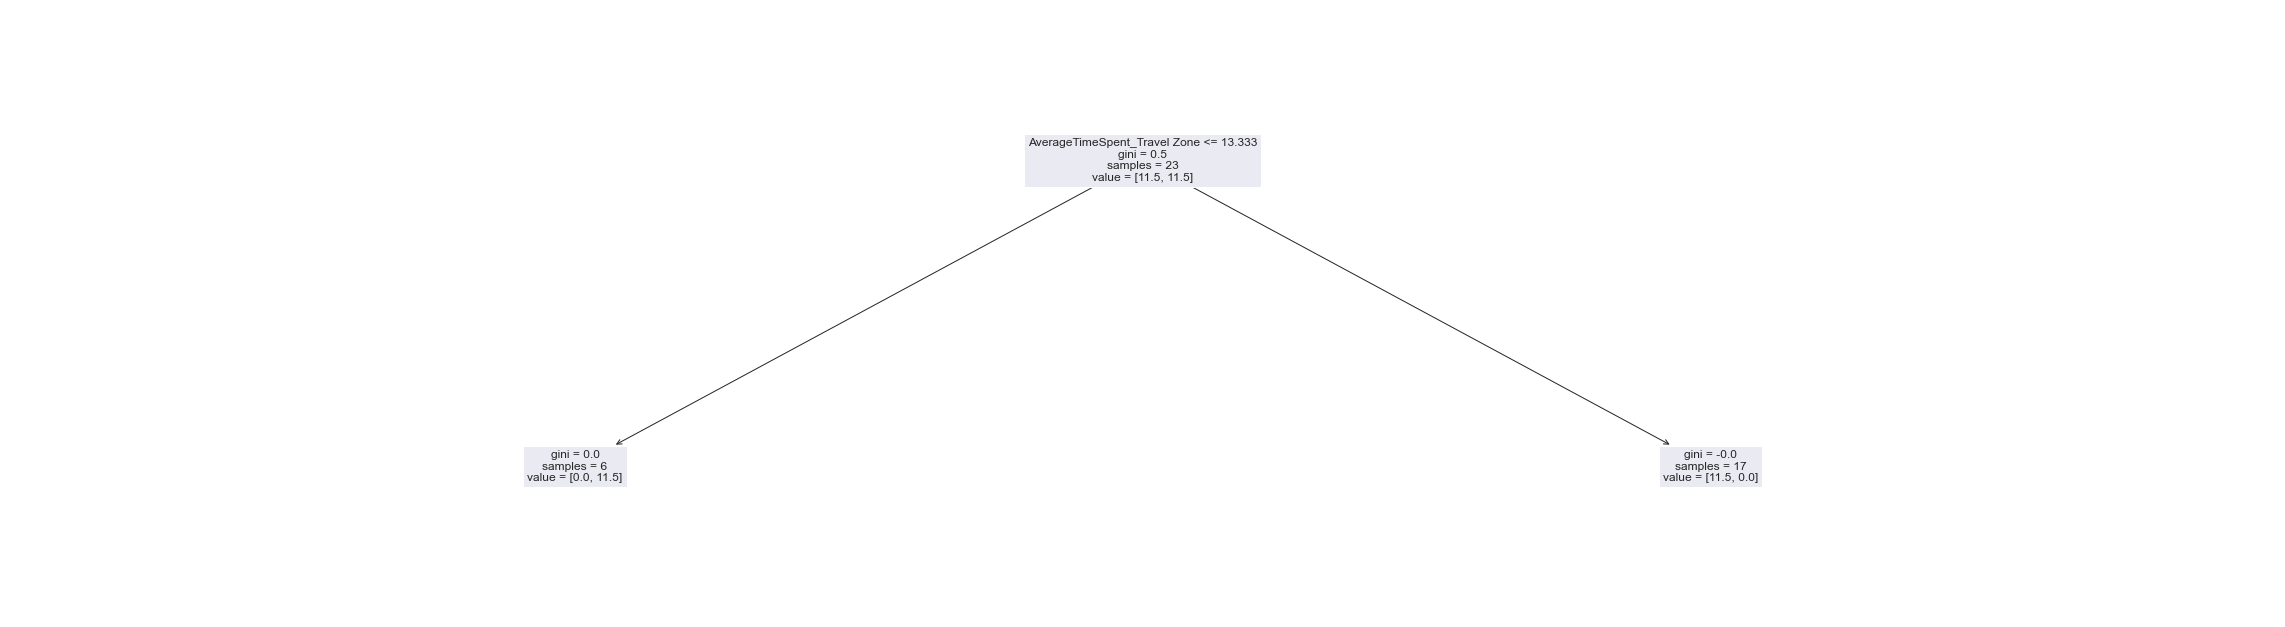

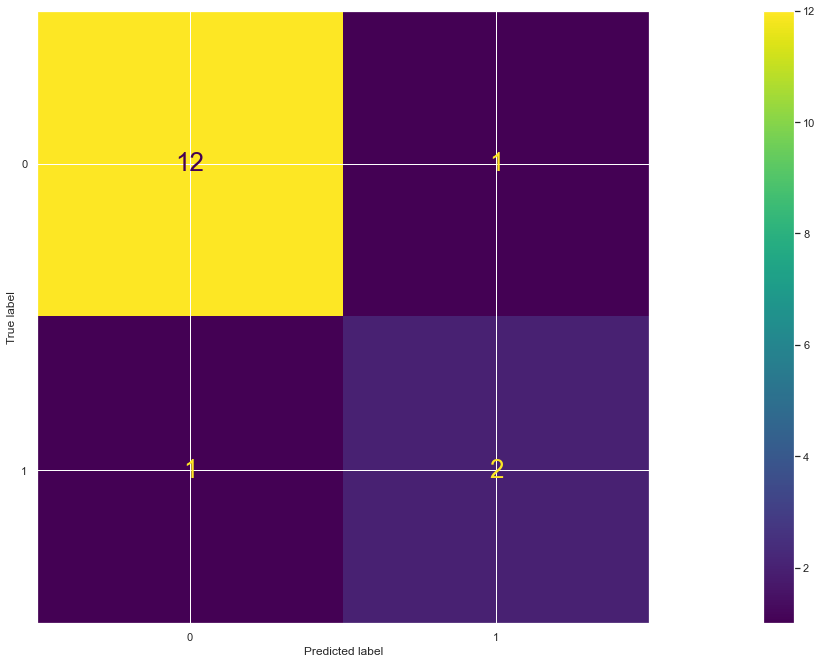

feature- Strange_Count :  Day : 17
Mean ROC AUC: nan
feature- Strange_Count :  Day : 17
Mean absolute error LR- 0.0625
Mean Squared error LR- 0.25
Accuracy: 0.9375
F1: 0.8814814814814815
Precision: 0.8333333333333333
Recall: 0.9642857142857143


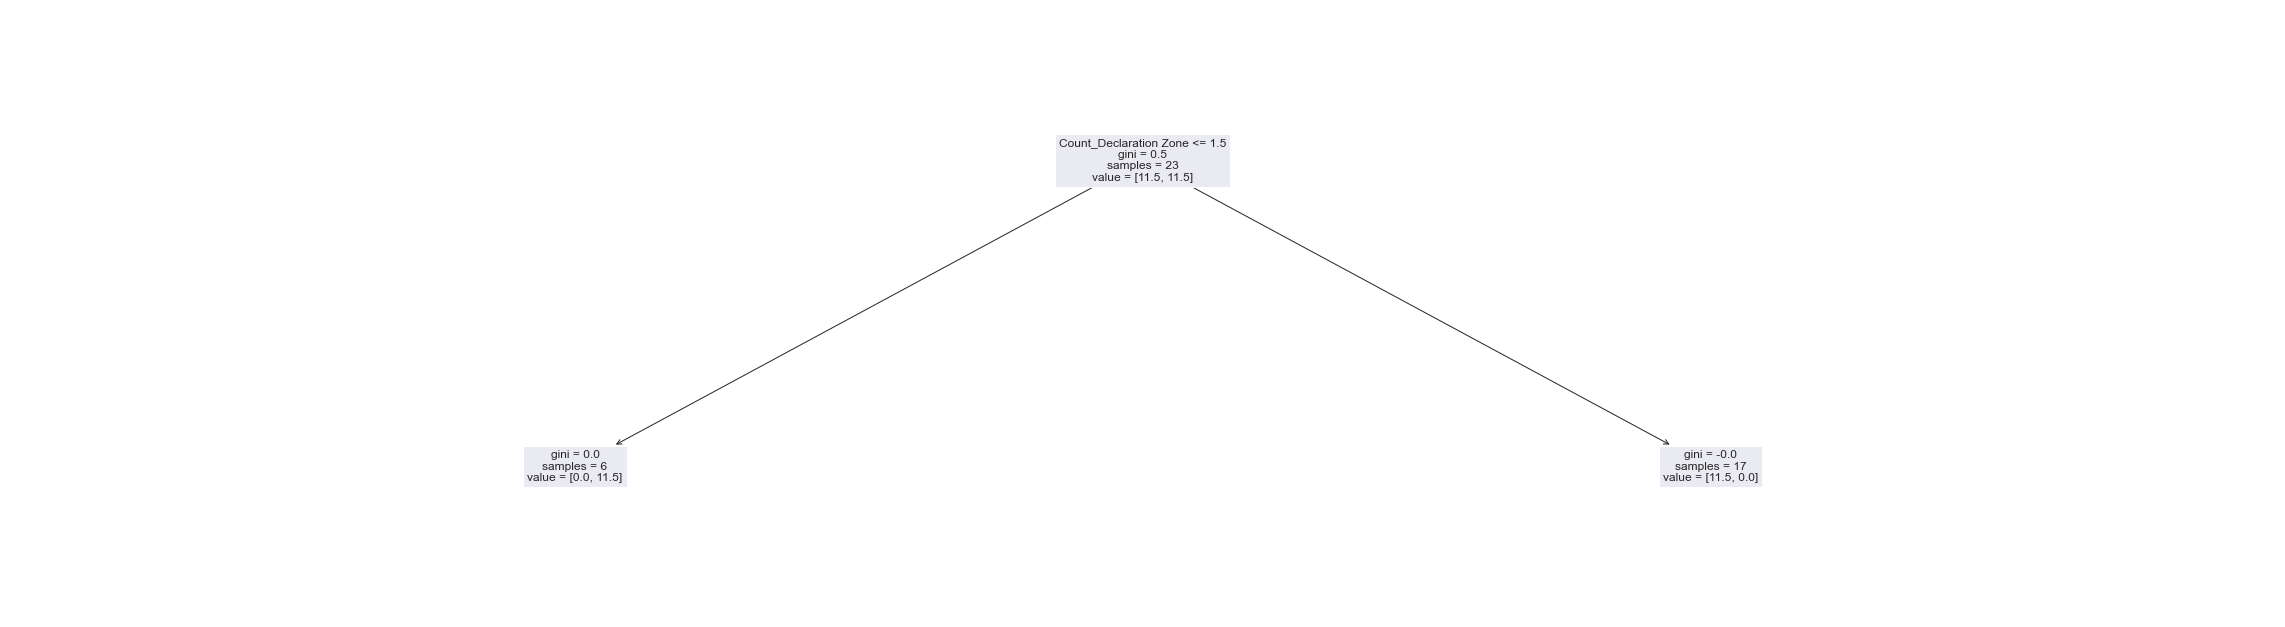

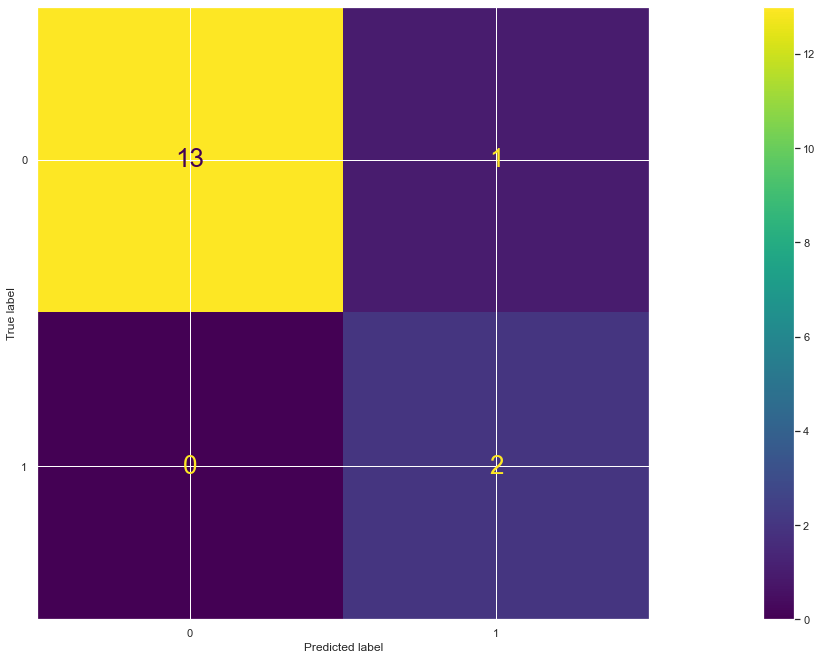

feature- Strange_Count :  Day : 18
Mean ROC AUC: nan
feature- Strange_Count :  Day : 19
Mean ROC AUC: nan
feature- Strange_Count :  Day : 19
Mean absolute error LR- 0.0625
Mean Squared error LR- 0.25
Accuracy: 0.9375
F1: 0.8160919540229885
Precision: 0.75
Recall: 0.9666666666666667


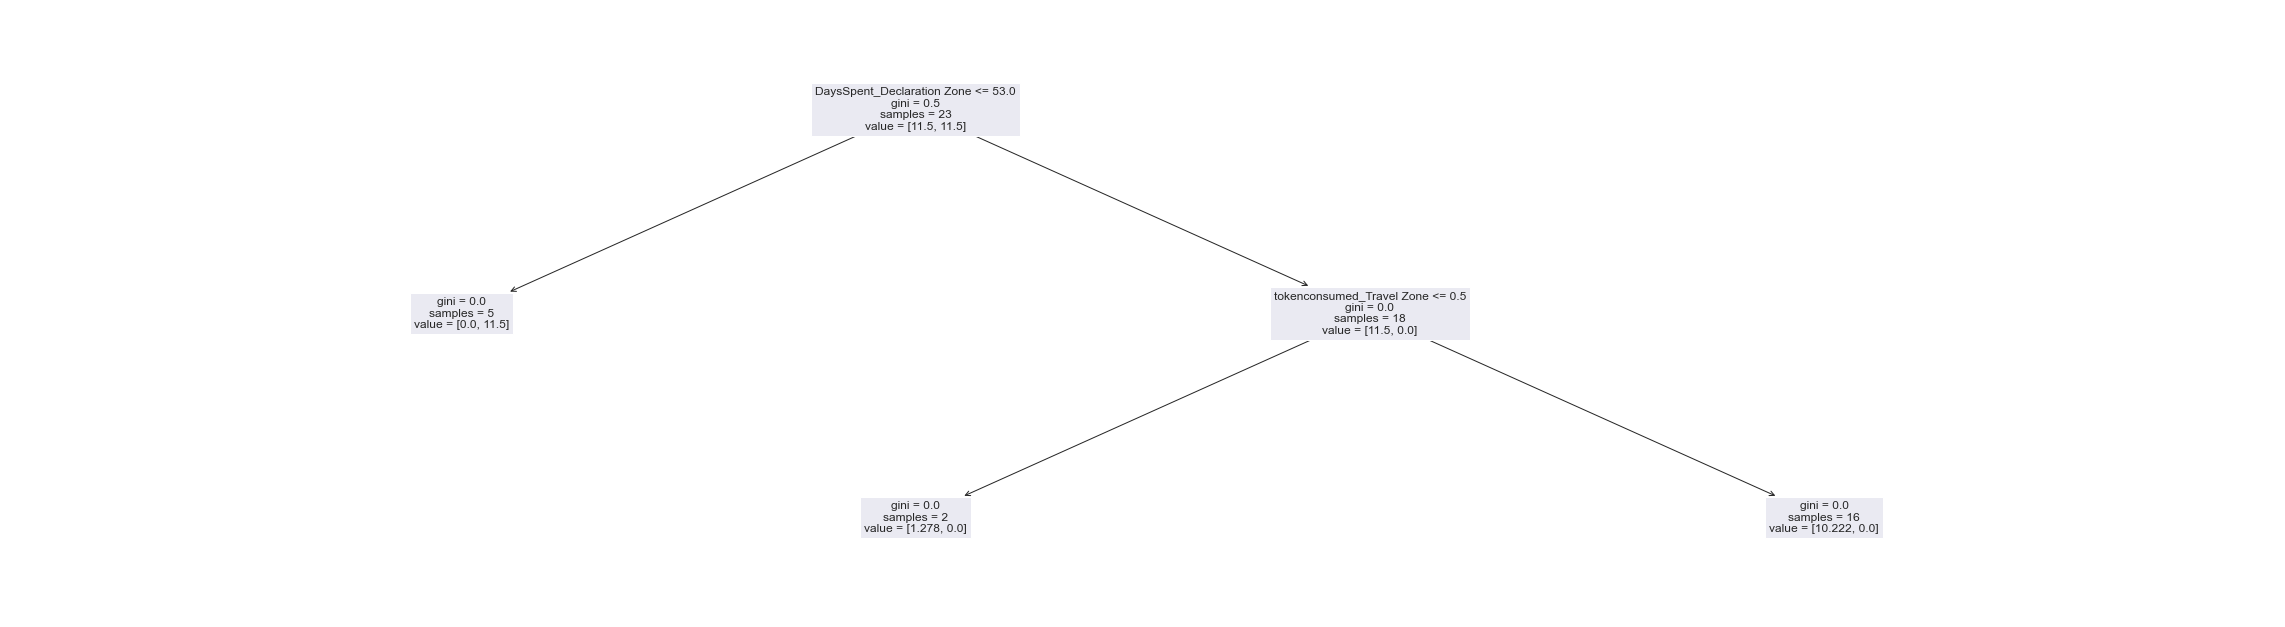

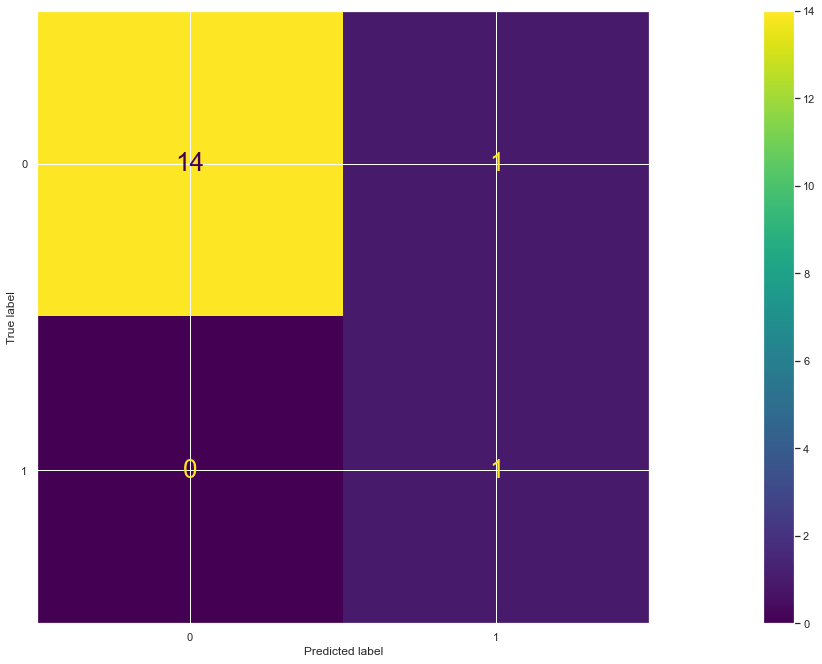

feature- Strange_Count :  Day : 20
Mean ROC AUC: nan
feature- Strange_Count :  Day : 21
Mean ROC AUC: nan
feature- Strange_Count :  Day : 22
Mean ROC AUC: nan
feature- Strange_Count :  Day : 23
Mean ROC AUC: nan
feature- Strange_Count :  Day : 24
Mean ROC AUC: nan
feature- Strange_Count :  Day : 25
Mean ROC AUC: nan
feature- Strange_Count :  Day : 26
Mean ROC AUC: nan
feature- Strange_Count :  Day : 27
Mean ROC AUC: nan
feature- Strange_Count :  Day : 28
Mean ROC AUC: nan
feature- Strange_Count :  Day : 29
Mean ROC AUC: nan
feature- Strange_Count :  Day : 30
Mean ROC AUC: nan
feature- Strange_Count :  Day : 31
Mean ROC AUC: nan
feature- Strange_Count :  Day : 32
Mean ROC AUC: nan
feature- Strange_Count :  Day : 33
Mean ROC AUC: nan
feature- Strange_Count :  Day : 34
Mean ROC AUC: nan
feature- Strange_Count :  Day : 35
Mean ROC AUC: nan
feature- Strange_Count :  Day : 36
Mean ROC AUC: nan
feature- Strange_Count :  Day : 37
Mean ROC AUC: nan
feature- Strange_Count :  Day : 38
Mean ROC AU

ValueError: With n_samples=0, test_size=0.4 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [52]:
predictionDelay=50
targetfeaturelist=['Strange_tokenleft','Strange_oneframetoken', 
             'Strange_Count', 'Strange_AverageTimeSpent']

for targetZone in targetzonelist[1:2]:
    print(targetZone.name)
    predict(targetZone.copy(),zonelist.copy(),targetfeaturelist,predictionDelay)

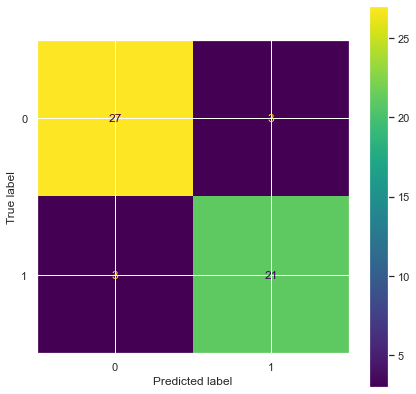

In [21]:
import sys
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

sns.set(rc={'figure.figsize':(7,7)})
cm = metrics.confusion_matrix(actual, predicted)
cm[0][0]=27
cm[0][1]=3
cm[1][0]=3
cm[1][1]=21

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1],)

cm_display.plot()
plt.show()
